# <font color='steelblue'>
______________________________________________________________________________________________________________________________________________________
### <center> <font color='steelblue'> Post-graduation in Data Science for Finance
##### <center> <font color='steelblue'> 2024 / 25
# <center> <font color='steelblue'> Credit Risk Scoring
### <center> <font color='steelblue'><font> Prof. Afshin Ashofteh </font>
______________________________________________________________________________________________________________________________________________________
### <center> <font color='steelblue'><font> Group 7:</font>
##### <center> <font color='steelblue'><font> Francisco Perestrello, 20241560 </font>
##### <center> <font color='steelblue'><font> Gonçalo Gomes, m20211007 </font>
##### <center> <font color='steelblue'><font> Nuno Vieira, 20241111 </font>
##### <center> <font color='steelblue'><font> Petr Terletskiy, 20211580 </font>
______________________________________________________________________________________________________________________________________________________
### <center> <font color='steelblue'><font> Statistical, Machine Learning, and Deep Learning Approaches for Predicting Loan Default </font>
______________________________________________________________________________________________________________________________________________________


# 0. Dependencies

In [ ]:
!pip install catboost
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 17.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

# visualization settings set up
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (7, 5)

import re
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix # evaluation metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


# 1. Data Load

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# path = "/content/drive/MyDrive/NOVA IMS/Data Science for Finance/T4-CRS/data/"
path = "/content/drive/MyDrive/Nova Ims/Credit Risk Scoring/Project/"

In [ ]:
df = pd.read_csv(path + "1_Credit_Scoring_Project_Data_Modeling.csv", encoding='latin1')
df.sample(3)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,loan_status
51272,996176,35000,35000,34975.0,60 months,11.49,769.57,B,Director of research administration,3 years,MORTGAGE,132600.0,Verified,15-Nov,debt_consolidation,VA,25.23,1,7-Sep,2.0,12,0,2129,79.0,19,0.0,6823.410000,Charged Off
235093,809938,20000,20000,20000.0,36 months,6.49,612.89,A,firefighter paramedic,9 years,MORTGAGE,140000.0,Source Verified,16-Jan,moving,FL,21.68,0,Jan-97,0.0,7,0,2796,58.3,23,0.0,3406.482077,Fully Paid
49293,952701,23000,23000,23000.0,36 months,6.24,702.21,A,Marketing Director,1 year,RENT,150000.0,Source Verified,15-Dec,debt_consolidation,CA,28.38,0,Aug-93,0.0,6,0,30857,95.5,15,0.0,6416.440000,Charged Off


In [ ]:
df_test = pd.read_csv("unseen_kaggle.csv", encoding='latin1')

df_test.rename(columns={"total_pymnt;": "total_pymnt"}, inplace=True)
df_test['total_pymnt'] = df_test['total_pymnt'].str.replace(';', '')
df_test['total_pymnt'] = df_test['total_pymnt'].astype(float)

# 2. Exploratory Data Analysis

In [ ]:
print("Columns of the provided dataset:")
for col in df.columns.to_list():
    print(f"- {col}")

Columns of the provided dataset:
- id
- loan_amnt
- funded_amnt
- funded_amnt_inv
- term
- int_rate
- installment
- grade
- emp_title
- emp_length
- home_ownership
- annual_inc
- verification_status
- issue_d
- purpose
- addr_state
- dti
- delinq_2yrs
- earliest_cr_line
- inq_last_6mths
- open_acc
- pub_rec
- revol_bal
- revol_util
- total_acc
- out_prncp
- total_pymnt
- loan_status


In [ ]:
id_feature = 'id'
target_feature = 'loan_status'

### 2.1. Target Variable



Information for the loan_status feature:




,count
loan_status,
Fully Paid,207036
Charged Off,84180
Late (31-120 days),12154
In Grace Period,5151
Late (16-30 days),2162
Default,21




____________________________________________________________________________________________________




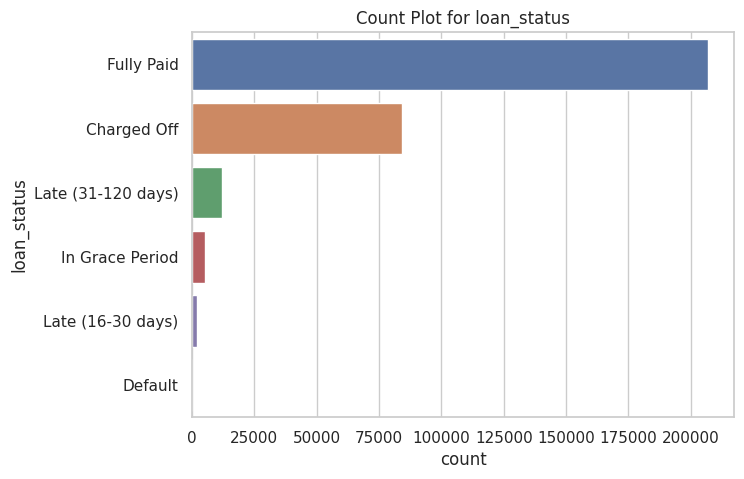



____________________________________________________________________________________________________




In [ ]:
print('\n')
print(f'Information for the {target_feature} feature:')
print('\n')

# value counts
value_counts = df[target_feature].value_counts(dropna=False)
display(value_counts)

print('\n')
print('_' * 100)
print('\n')

# countplot
order = df[target_feature].value_counts().index
sns.countplot(y=df[target_feature], palette='deep', order=order)
plt.title(f'Count Plot for {target_feature}')
plt.show()

print('\n')
print('_' * 100)
print('\n')

In [ ]:
# Define the mapping for loan_status to binary (0 = Non-Default, 1 = Default)
status_mapping = {
    'Fully Paid': 0,
    'In Grace Period': 0,
    'Late (16-30 days)': 1,
    'Late (31-120 days)': 1,
    'Charged Off': 1,
    'Default': 1
}

df['loan_status'] = df['loan_status'].map(status_mapping)

### 2.2. Dataset Split

* In order to eliminate any leakage from the validation set, the first step, after transforming the target feature into a binary one, is to split the data.

* Following this thought, keep in mind that all transformations executed in this notebook, are fitted in the training set and then applied in the validation set to prevent the models to learn from the validation data.

In [ ]:
df_train, df_val = train_test_split(df, random_state = 42, stratify = df["loan_status"].values)

print("Shape of Training Data:", df_train.shape)
print("Shape of Validation Data:", df_val.shape)

Shape of Training Data: (233028, 28)
Shape of Validation Data: (77676, 28)


### 2.3. Dataset Overview

In [ ]:
print(f'The dataset that will be used for training has {df_train.shape[0]} rows and {df_train.shape[1]} columns.')
print(f'The validation dataset has {df_val.shape[0]} rows and {df_val.shape[1]} columns.')

The dataset that will be used for training has 233028 rows and 28 columns.
The validation dataset has 77676 rows and 28 columns.


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233028 entries, 194787 to 306702
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   233028 non-null  int64  
 1   loan_amnt            233028 non-null  int64  
 2   funded_amnt          233028 non-null  int64  
 3   funded_amnt_inv      233028 non-null  float64
 4   term                 233028 non-null  object 
 5   int_rate             233028 non-null  float64
 6   installment          233028 non-null  float64
 7   grade                233028 non-null  object 
 8   emp_title            210840 non-null  object 
 9   emp_length           216099 non-null  object 
 10  home_ownership       233028 non-null  object 
 11  annual_inc           233028 non-null  float64
 12  verification_status  233028 non-null  object 
 13  issue_d              233028 non-null  object 
 14  purpose              233028 non-null  object 
 15  addr_state       

In [ ]:
# numerical features
df_train.describe()

,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,loan_status
count,2.330280e+05,233028.000000,233028.000000,233028.000000,233028.000000,233028.000000,2.330280e+05,232912.000000,233028.000000,233027.000000,233028.000000,233028.000000,2.330280e+05,232876.000000,233028.000000,233028.000000,233028.000000,233028.000000
mean,6.198450e+05,15521.572837,15521.572837,15514.759596,12.561894,452.798670,8.051328e+04,19.018132,0.337874,0.608183,11.887305,0.247387,1.605752e+04,48.477627,24.913101,721.131297,13436.250658,0.317078
std,3.931203e+05,9196.966834,9196.966834,9195.645964,4.691522,264.307424,9.279442e+04,12.700097,0.919673,0.889029,5.803179,0.679144,2.326488e+04,24.809977,12.313457,3595.640991,10014.726698,0.465339
min,1.000000e+00,1000.000000,1000.000000,725.000000,5.320000,14.770000,0.000000e+00,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000
25%,7.747075e+04,8300.000000,8300.000000,8275.000000,8.810000,259.420000,4.800000e+04,12.060000,0.000000,0.000000,8.000000,0.000000,5.513750e+03,29.600000,16.000000,0.000000,5787.804169,0.000000
50%,7.584795e+05,14000.000000,14000.000000,14000.000000,11.990000,387.660000,6.700000e+04,18.180000,0.000000,0.000000,11.000000,0.000000,1.058600e+04,48.000000,23.000000,0.000000,10748.396295,0.000000
75%,9.707752e+05,20800.000000,20800.000000,20750.000000,15.310000,603.150000,9.500000e+04,25.080000,0.000000,1.000000,15.000000,0.000000,1.908800e+04,67.200000,32.000000,0.000000,18590.768980,1.000000
max,1.048575e+06,40000.000000,40000.000000,40000.000000,30.990000,1618.240000,9.757200e+06,999.000000,21.000000,5.000000,80.000000,86.000000,1.044210e+06,182.800000,176.000000,40000.000000,59808.262090,1.000000


In [ ]:
# categorical features
df_train.describe(include=['object'])

,term,grade,emp_title,emp_length,home_ownership,verification_status,issue_d,purpose,addr_state,earliest_cr_line
count,233028,233028,210840,216099,233028,233028,233028,233028,233028,233028
unique,2,7,72453,11,4,3,9,13,50,673
top,36 months,B,Teacher,10+ years,MORTGAGE,Source Verified,16-Mar,debt_consolidation,CA,4-Sep
freq,161978,68958,4237,76868,115986,93813,42480,133171,32506,1848


In [ ]:
# Number of unique values per feature
for column in df_train.columns:
    unique_count = df_train[column].nunique()
    print(f"Column '{column}' has {unique_count} unique values.")

Column 'id' has 233028 unique values.
Column 'loan_amnt' has 1508 unique values.
Column 'funded_amnt' has 1508 unique values.
Column 'funded_amnt_inv' has 1523 unique values.
Column 'term' has 2 unique values.
Column 'int_rate' has 149 unique values.
Column 'installment' has 32813 unique values.
Column 'grade' has 7 unique values.
Column 'emp_title' has 72453 unique values.
Column 'emp_length' has 11 unique values.
Column 'home_ownership' has 4 unique values.
Column 'annual_inc' has 16655 unique values.
Column 'verification_status' has 3 unique values.
Column 'issue_d' has 9 unique values.
Column 'purpose' has 13 unique values.
Column 'addr_state' has 50 unique values.
Column 'dti' has 5555 unique values.
Column 'delinq_2yrs' has 22 unique values.
Column 'earliest_cr_line' has 673 unique values.
Column 'inq_last_6mths' has 6 unique values.
Column 'open_acc' has 68 unique values.
Column 'pub_rec' has 27 unique values.
Column 'revol_bal' has 48985 unique values.
Column 'revol_util' has 1

In [ ]:
# Organizing the features into categories
categorical_features = ['term', 'grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status',
                        'issue_d', 'purpose', 'addr_state', 'earliest_cr_line']
numerical_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc',
                      'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
                      'total_acc', 'out_prncp', 'total_pymnt']

print((len([id_feature]) + len([target_feature]) + len(categorical_features) + len(numerical_features)) == df_train.shape[1])

True


In [ ]:
# Organizing the numerical features into categories
discrete_features = ['delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc']

continuous_features = [feature for feature in numerical_features if feature not in discrete_features]

print((len(discrete_features) + len(continuous_features) == len(numerical_features)))

True


### 2.4. Visualizations

#### Target Variable



Information for the loan_status feature:




,count
loan_status,
0,159140
1,73888




____________________________________________________________________________________________________




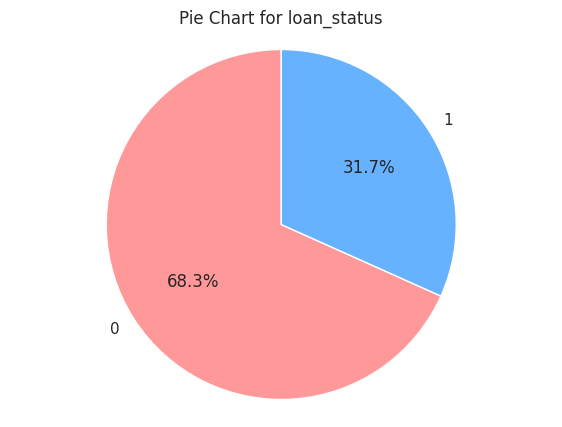



____________________________________________________________________________________________________




In [ ]:
print('\n')
print(f'Information for the {target_feature} feature:')
print('\n')

# value counts
value_counts = df_train[target_feature].value_counts(dropna=False)
display(value_counts)

print('\n')
print('_' * 100)
print('\n')

# pie chart
labels = value_counts.index
plt.pie(value_counts, labels=labels, autopct='%1.1f%%', colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99FF', '#99CCCC'], startangle=90)
plt.title(f'Pie Chart for {target_feature}')
plt.axis('equal')
plt.show()


print('\n')
print('_' * 100)
print('\n')

#### Numerical Variables

In [ ]:
print(f'There are {len(numerical_features)} numerical features in the dataset.')

There are 16 numerical features in the dataset.


##### **Continuous Variables**

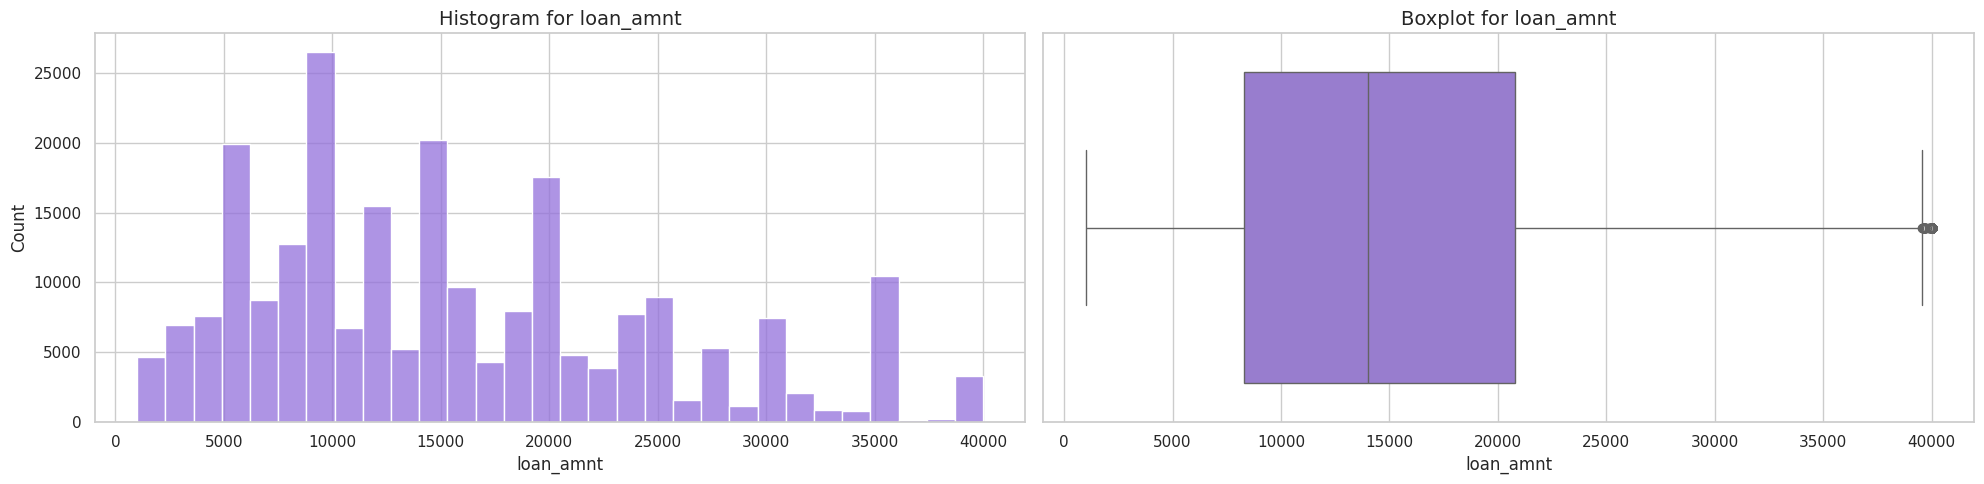

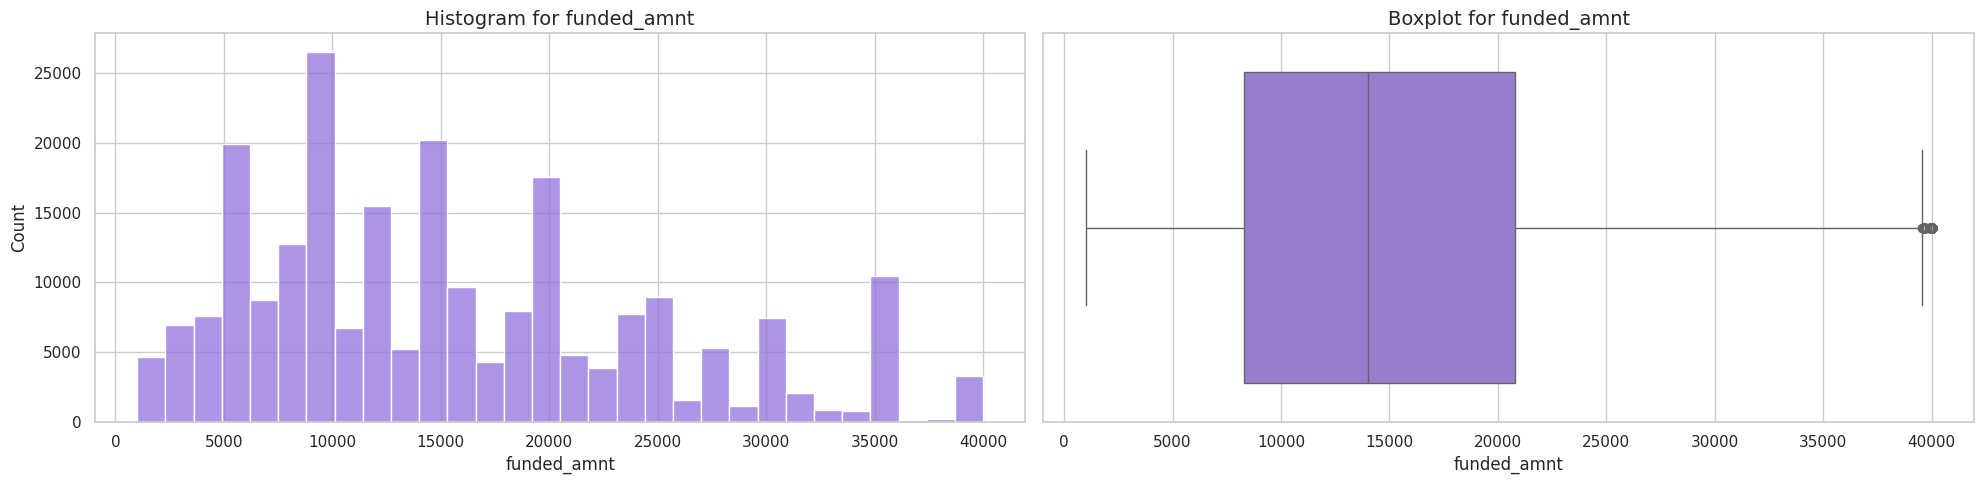

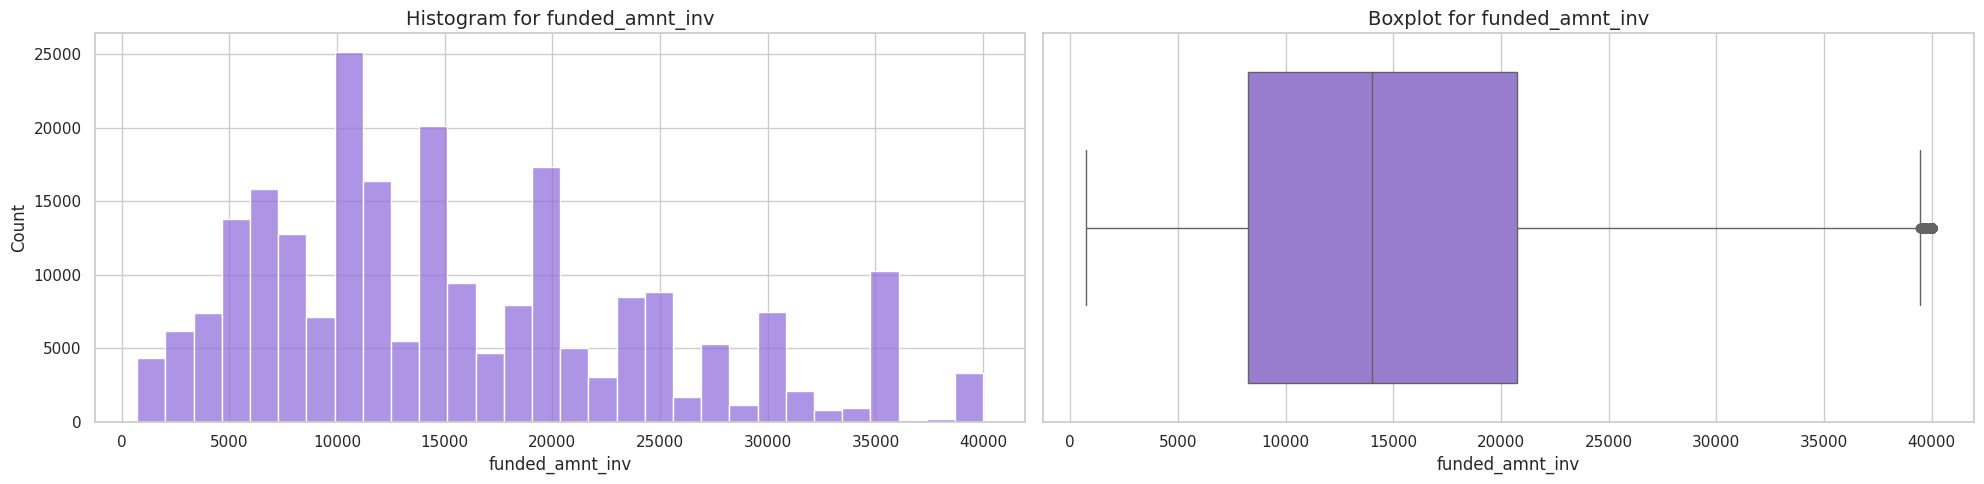

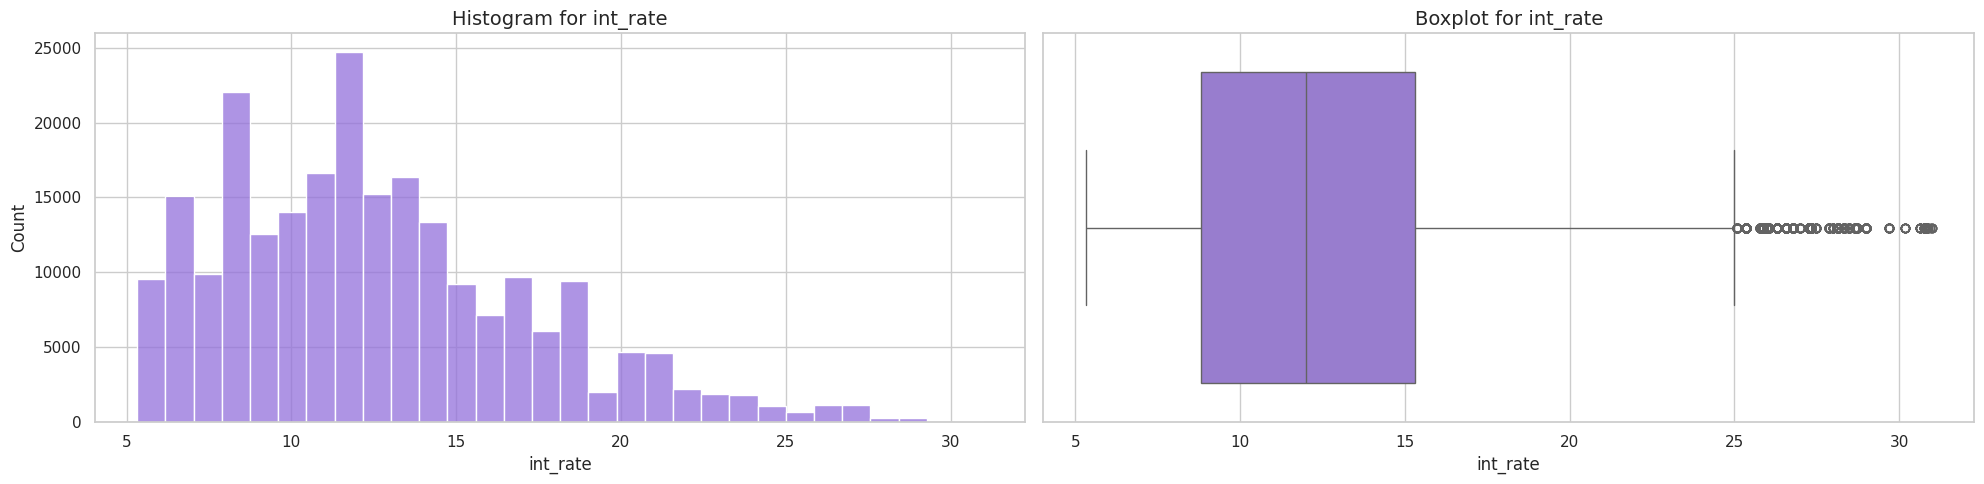

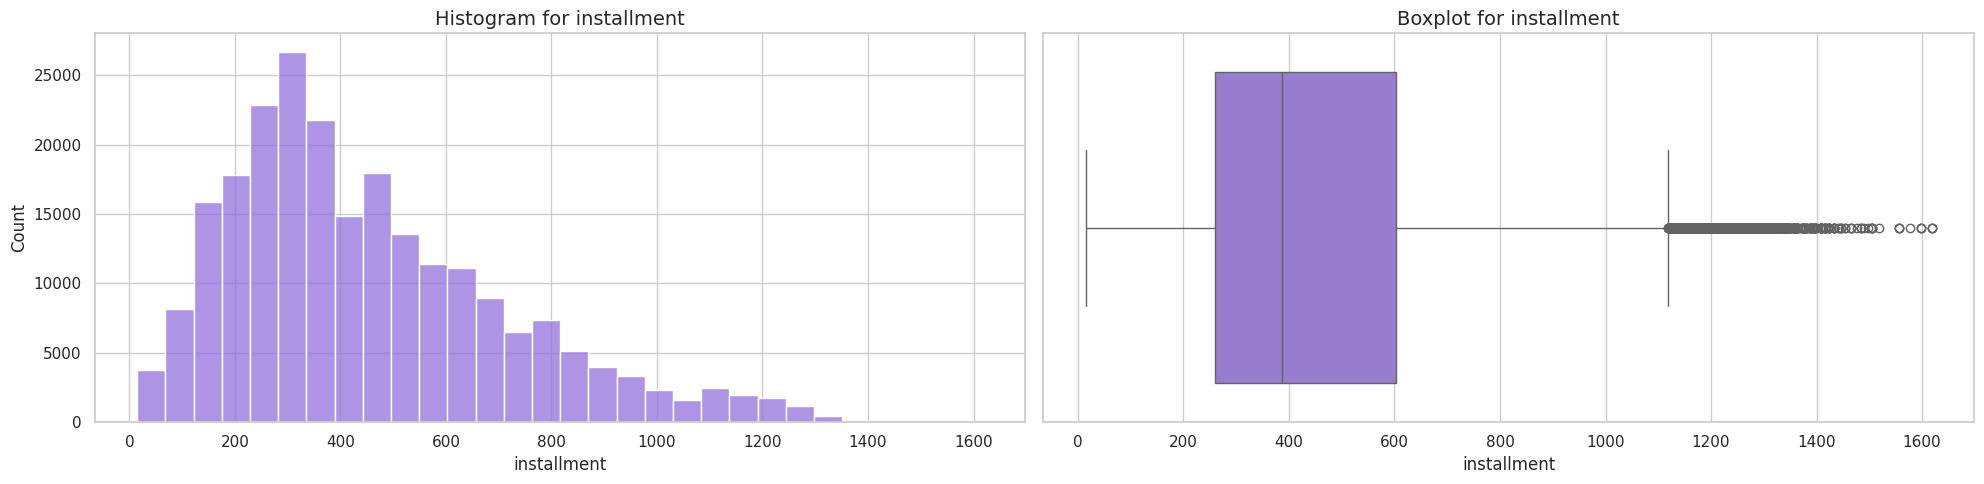

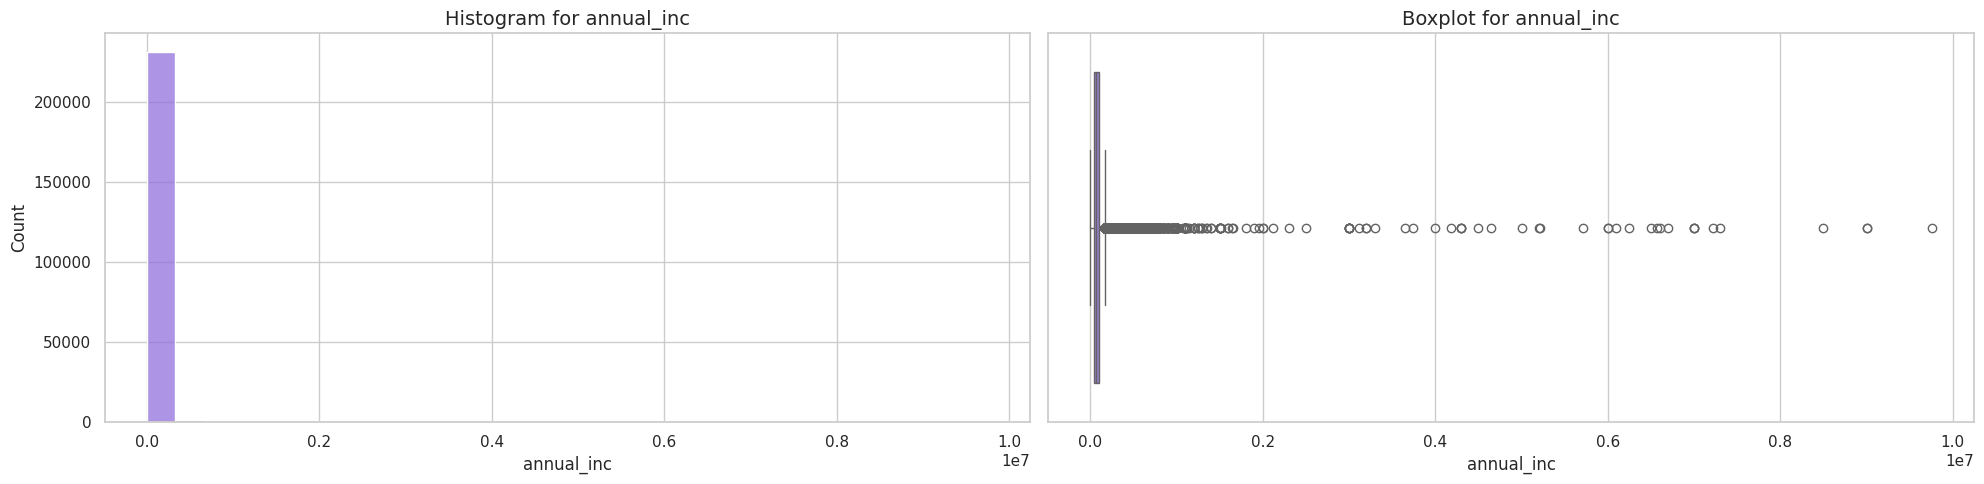

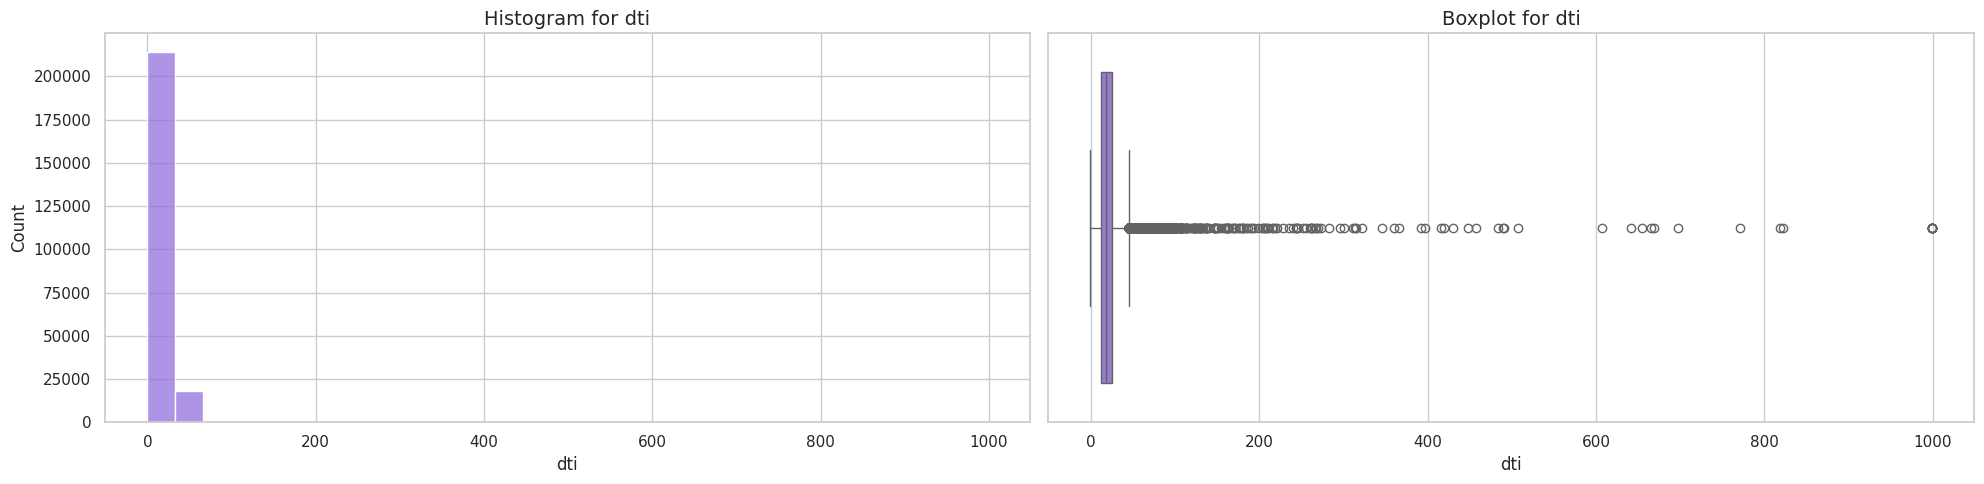

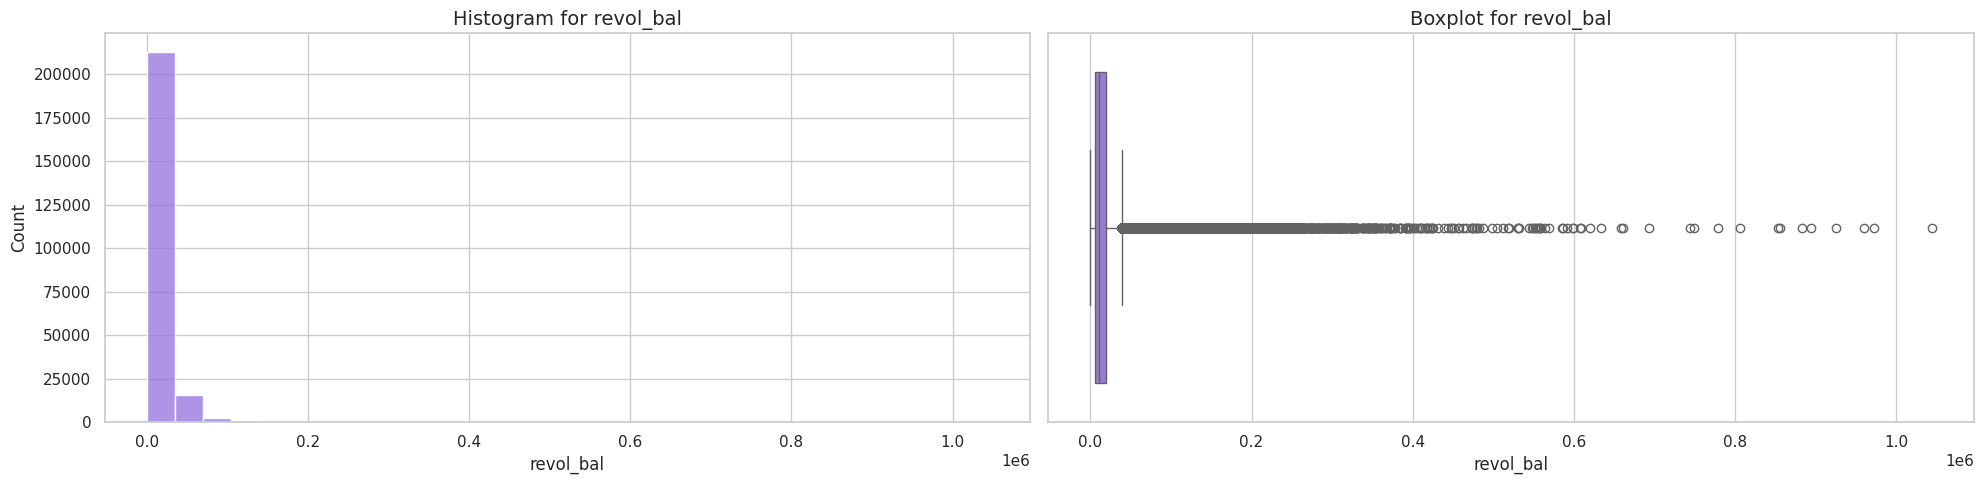

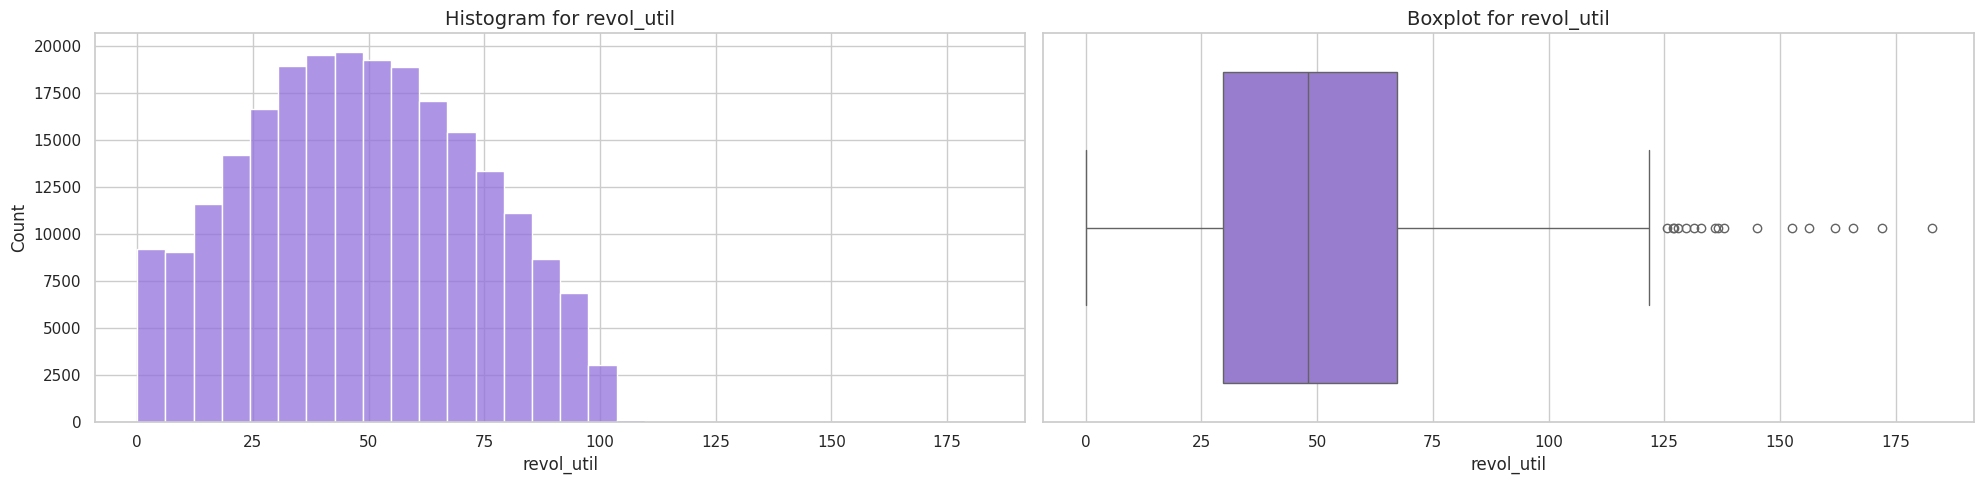

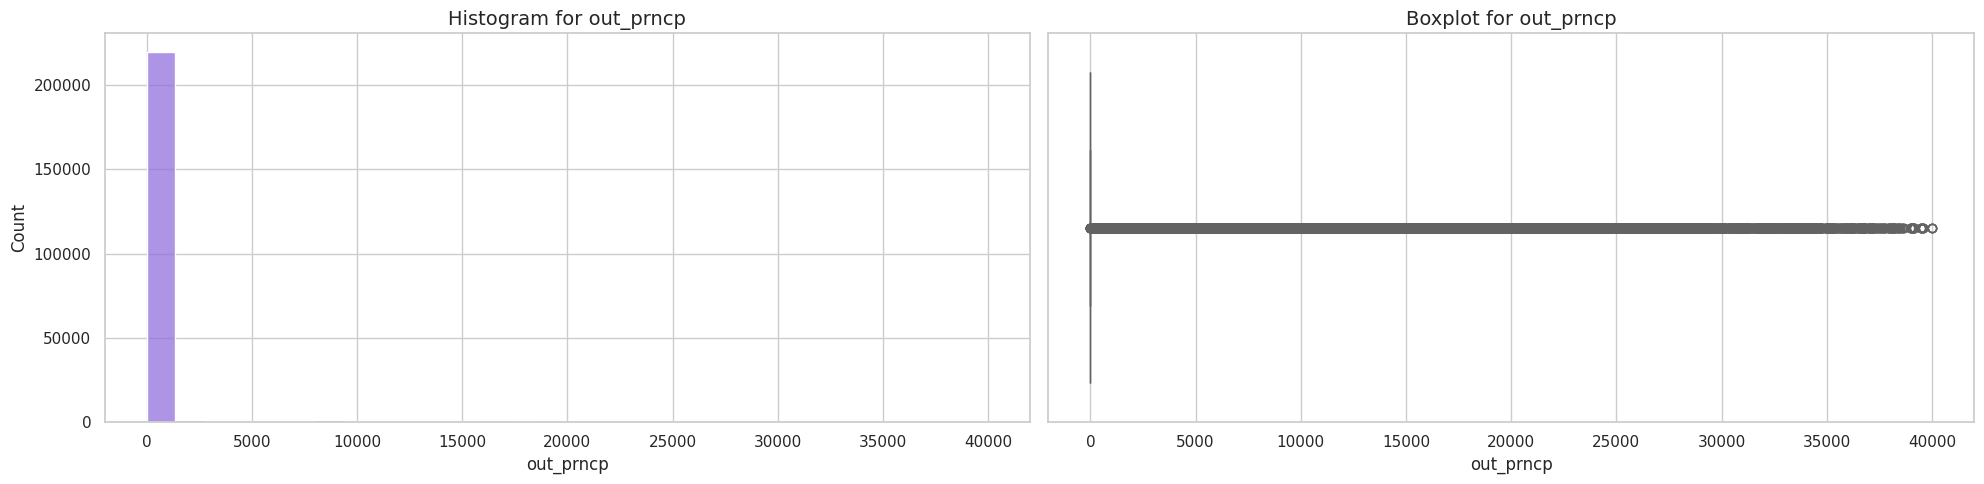

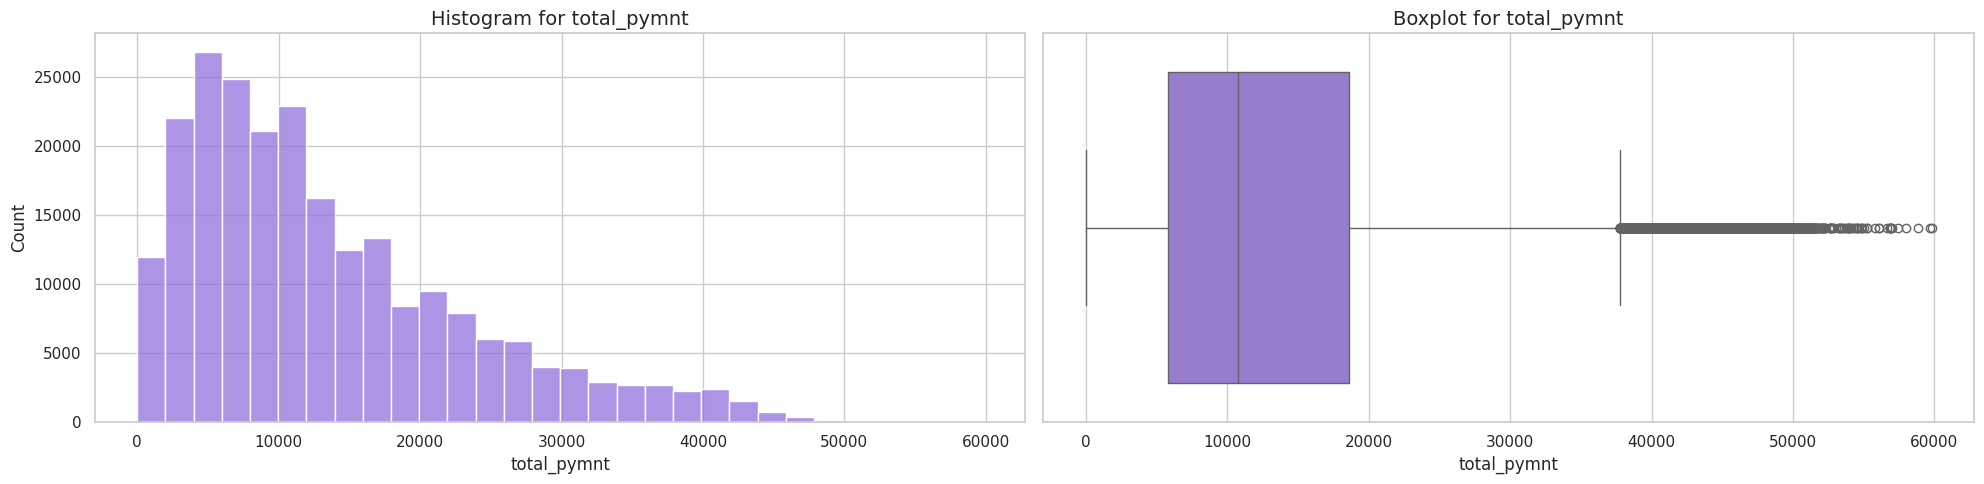

In [ ]:
# Looping through numerical variables and create plots
for var in continuous_features:
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    # Histogram
    sns.histplot(data=df_train, x=var, bins=30, kde=False, ax=axes[0], color="mediumpurple")
    axes[0].set_title(f'Histogram for {var}', fontsize=14)
    axes[0].set_xlabel(var, fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)

    # Boxplot
    sns.boxplot(data=df_train, x=var, ax=axes[1], color="mediumpurple")
    axes[1].set_title(f'Boxplot for {var}', fontsize=14)
    axes[1].set_xlabel(var, fontsize=12)

    plt.tight_layout()
    plt.show()

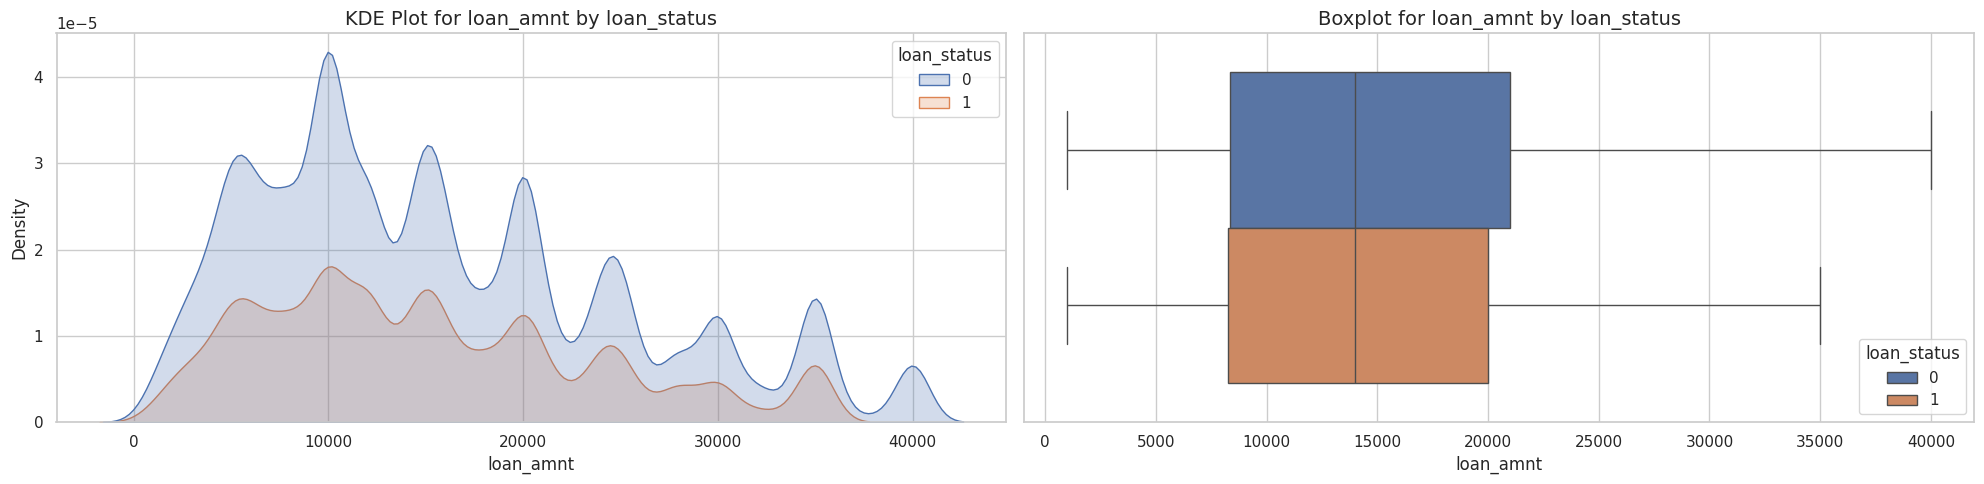

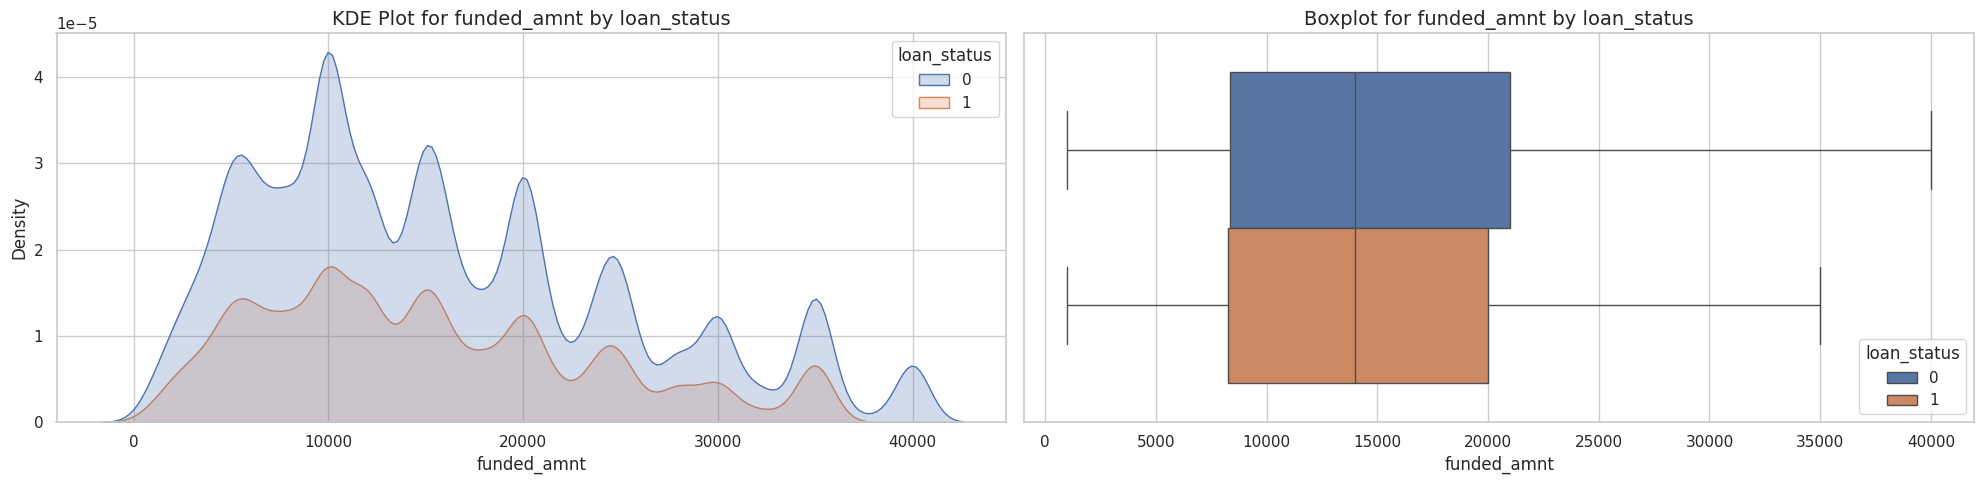

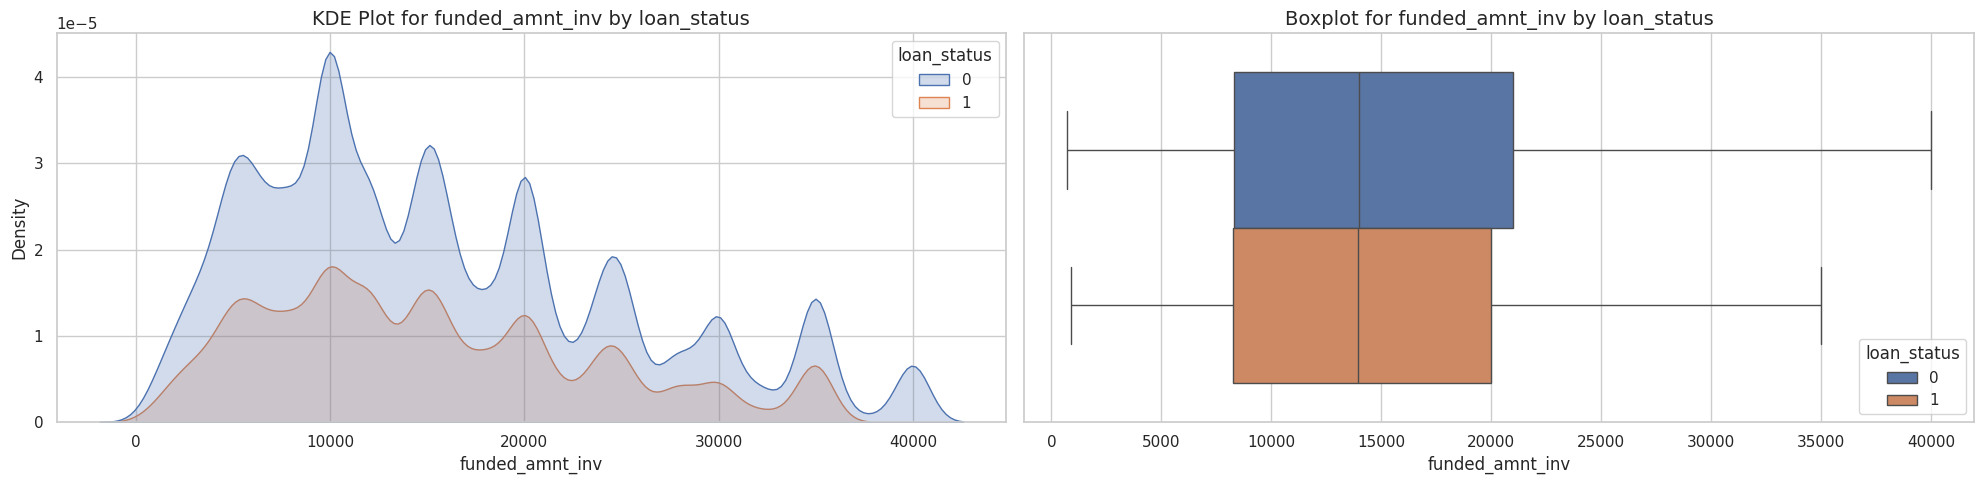

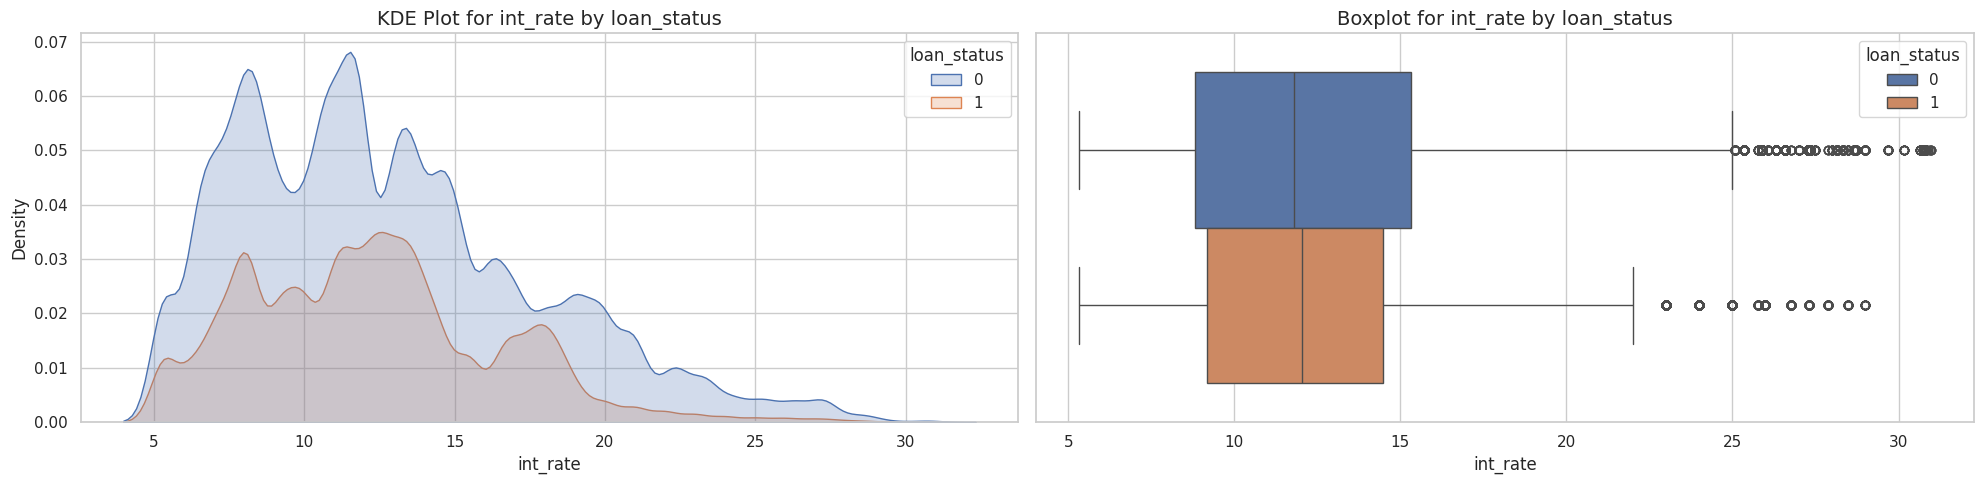

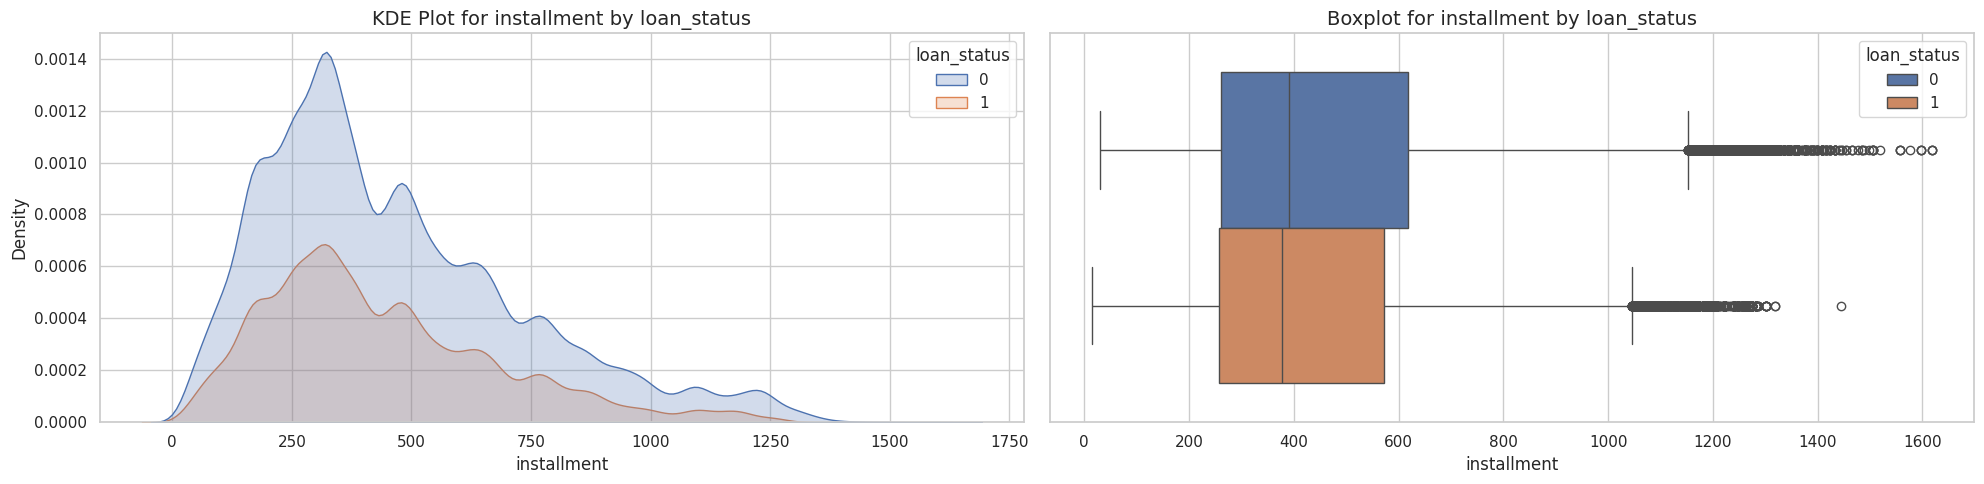

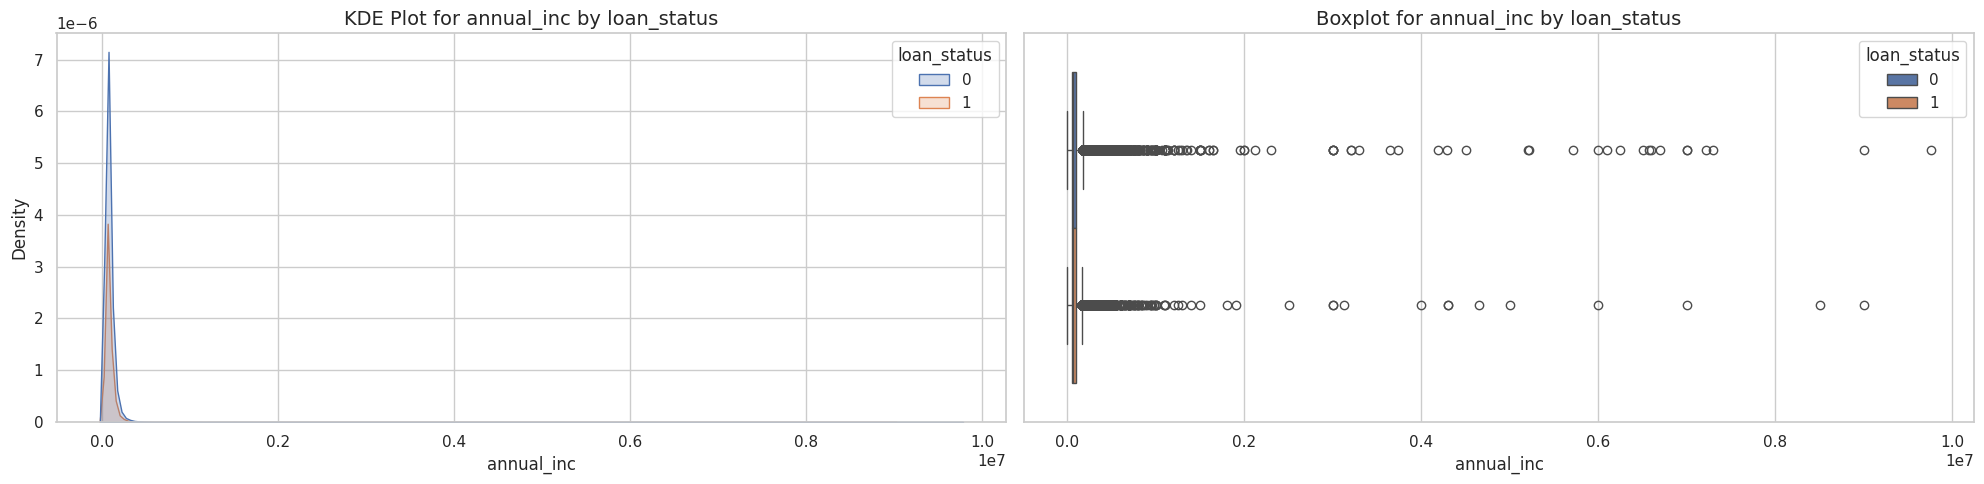

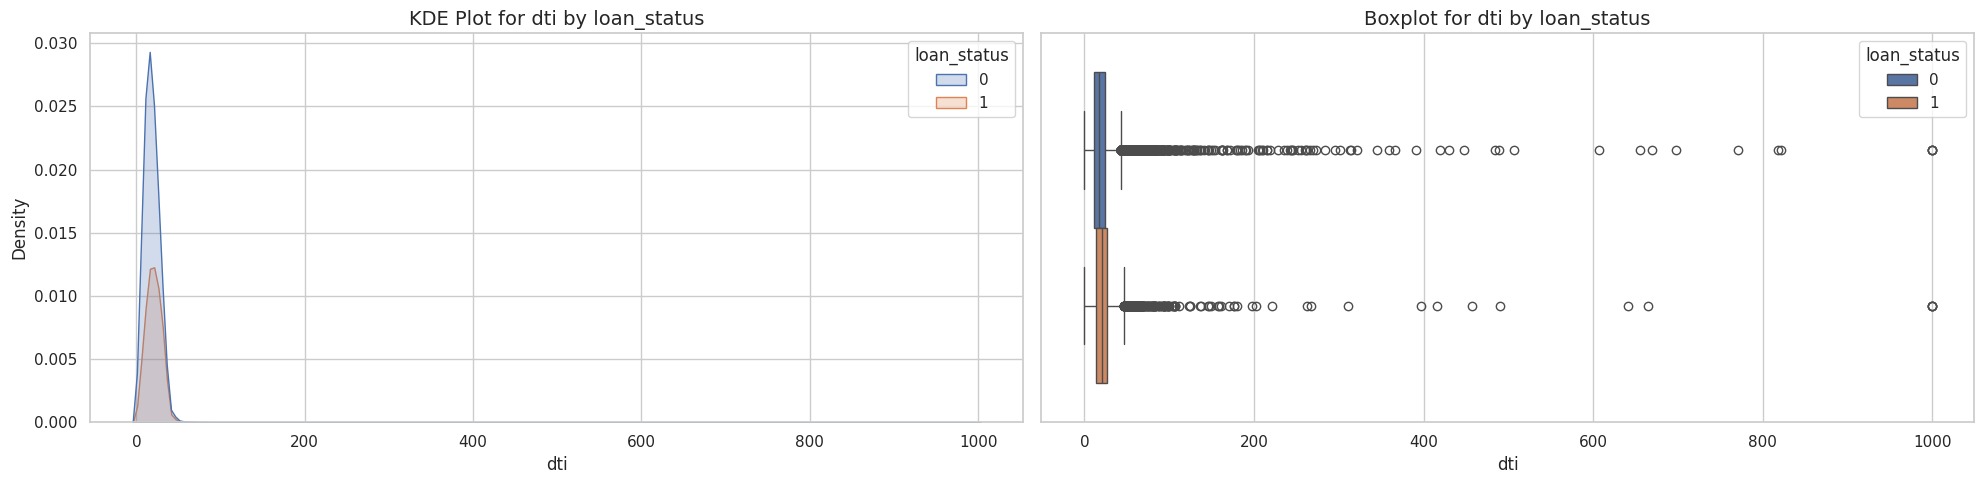

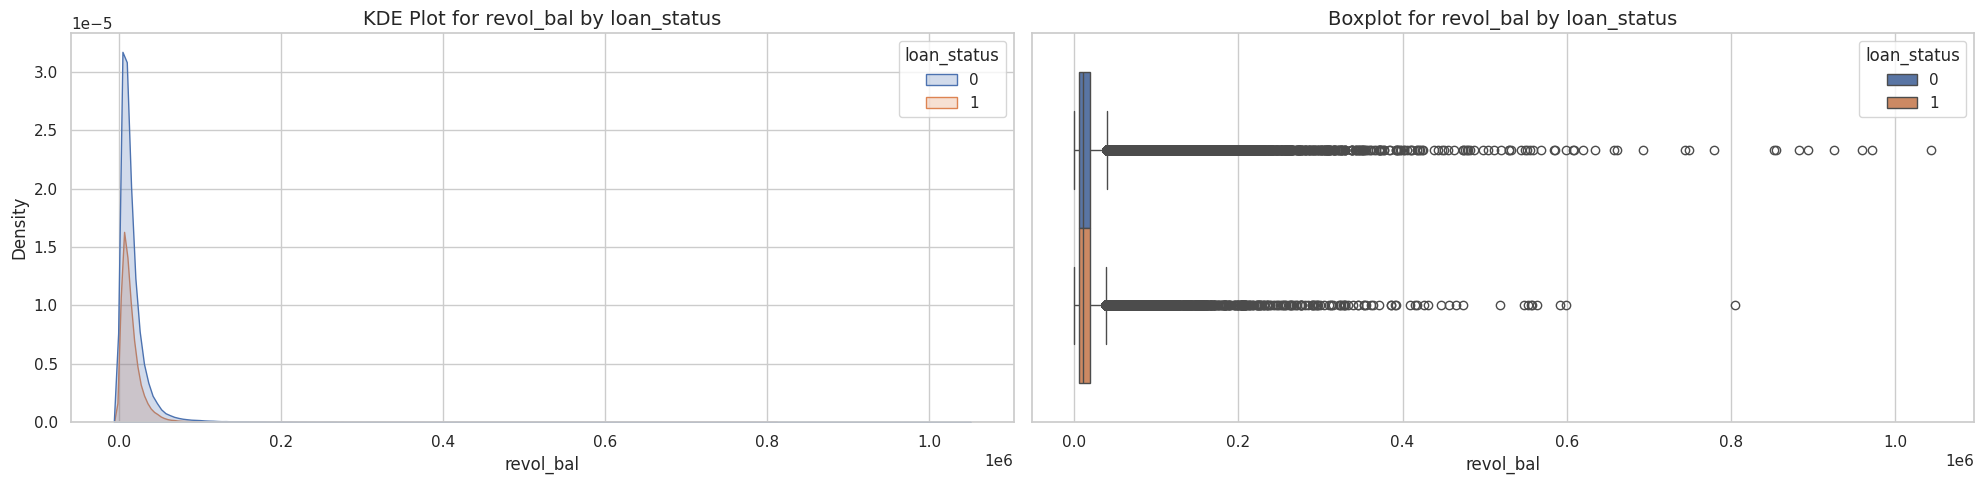

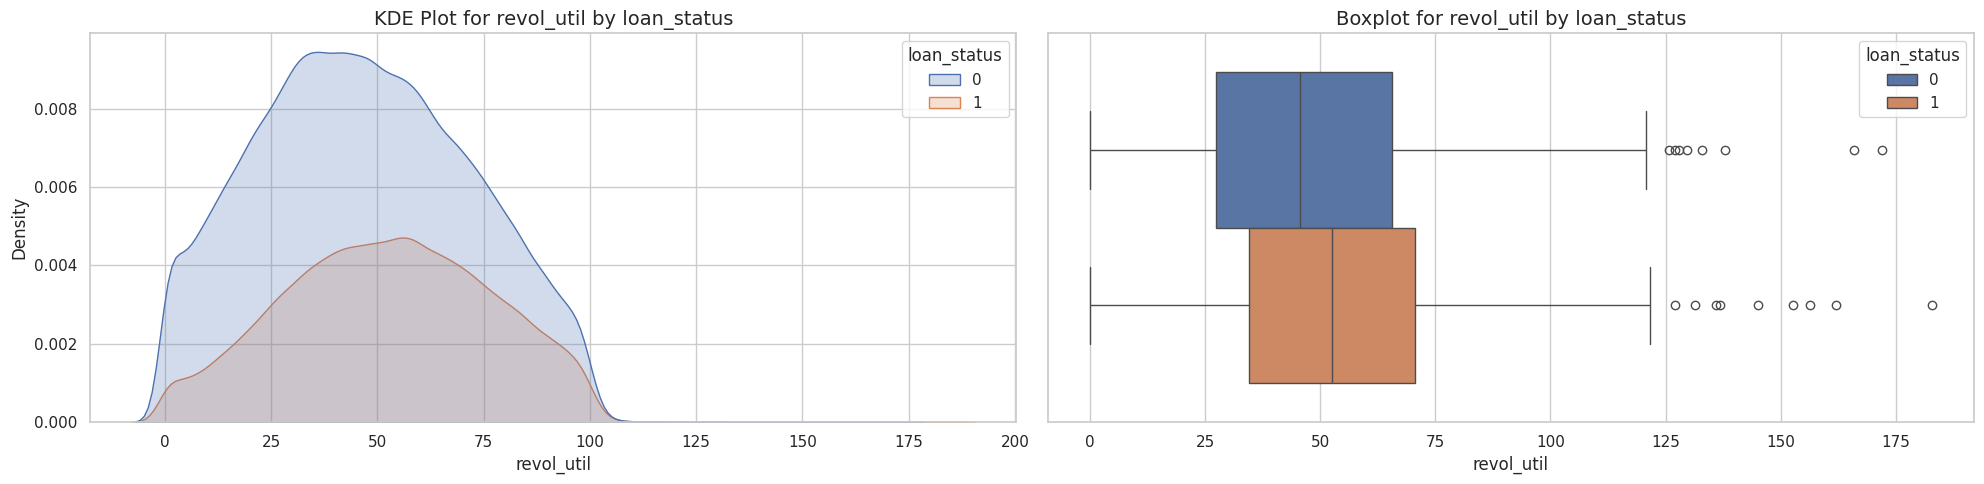

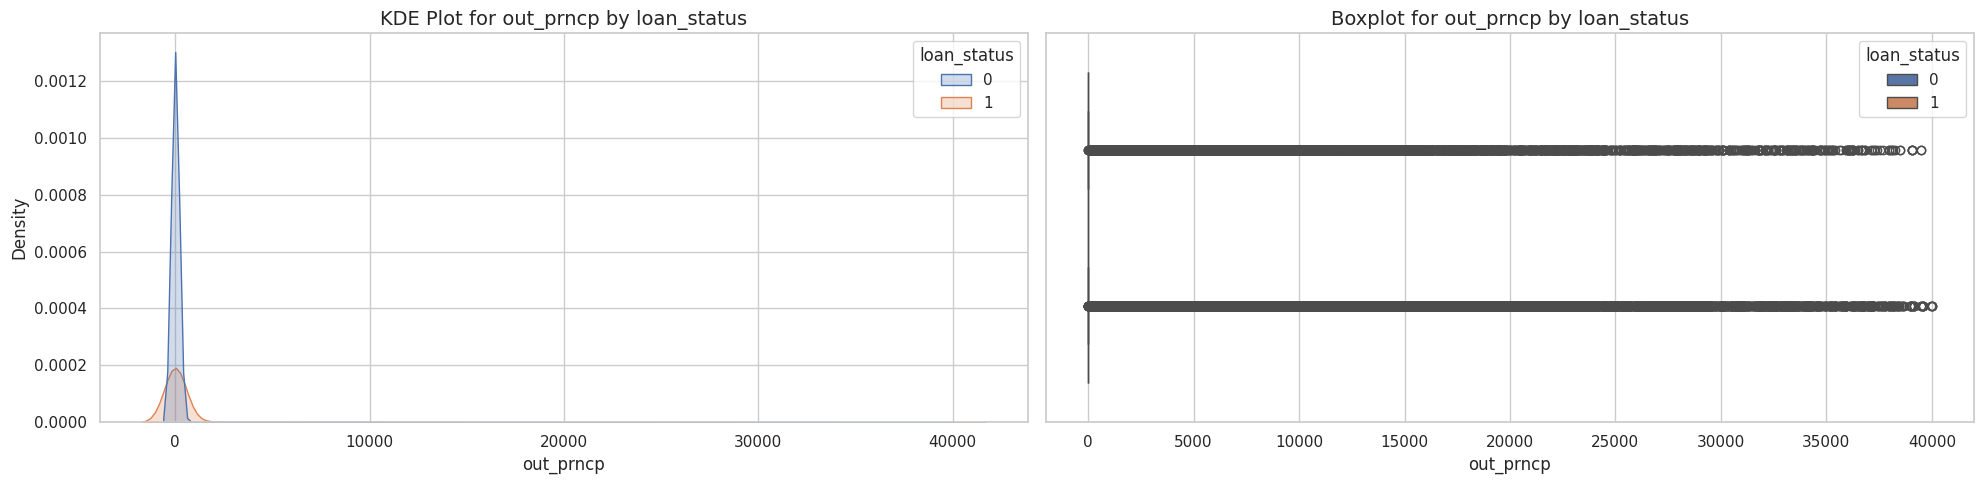

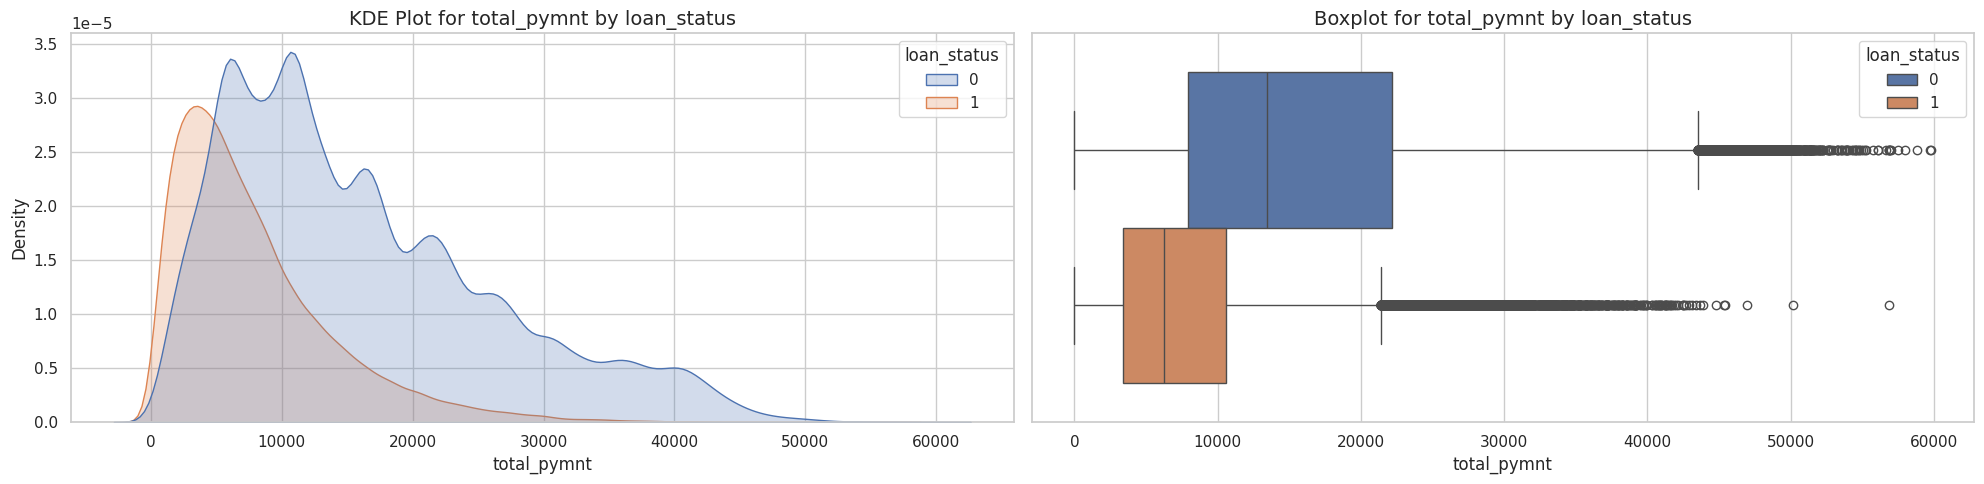

In [ ]:
# Looping through continuous variables and creating KDE plots and boxplots by loan status
for var in continuous_features:
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    # KDE Plot
    sns.kdeplot(data=df_train, x=var, hue=target_feature, fill=True, ax=axes[0])
    axes[0].set_title(f'KDE Plot for {var} by {target_feature}', fontsize=14)
    axes[0].set_xlabel(var, fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)

    # Boxplot
    sns.boxplot(data=df_train, x=var, hue=target_feature, ax=axes[1])
    axes[1].set_title(f'Boxplot for {var} by {target_feature}', fontsize=14)
    axes[1].set_xlabel(var, fontsize=12)

    plt.tight_layout()
    plt.show()

**Observations**

* (loan_amnt) & (funded_amnt) & (funded_amnt_inv): Basically the same distributions, with differences on defaults versus non-defaults lying on the largest outliers.
* (int_rate): Interest rates are narrower for defaulted loans.
* (installment): Installments are a bit more skewed for non/defaulted loans.
* (annual_inc) & (dti): Highly skewed both for defaults and non-defaults. Similar shapes for both.
* (revol_bal): Total credit revolving balance is less skewed for defaulted loans.
* (revol_util): Higher amount of credit the borrower is using relative to all available revolving credit for defaulted loans.
* (out_prncp): The remaining outstanding principal for the total amount funded is heavily concentrated around zero for both defaults and non-defaults.
* (total_pymnt): As expected, payments received for total amount funded is more skewed to the right for non-default loans.

**Decisions**
- Compute skewness of the features and consider log transformation for highly skewed features.
- Through the correlation matrix, consider removing features that are similar.
- Consider removing outstanding principal and total payments as this information will not be available at the loan request.


##### **Discrete Variables**

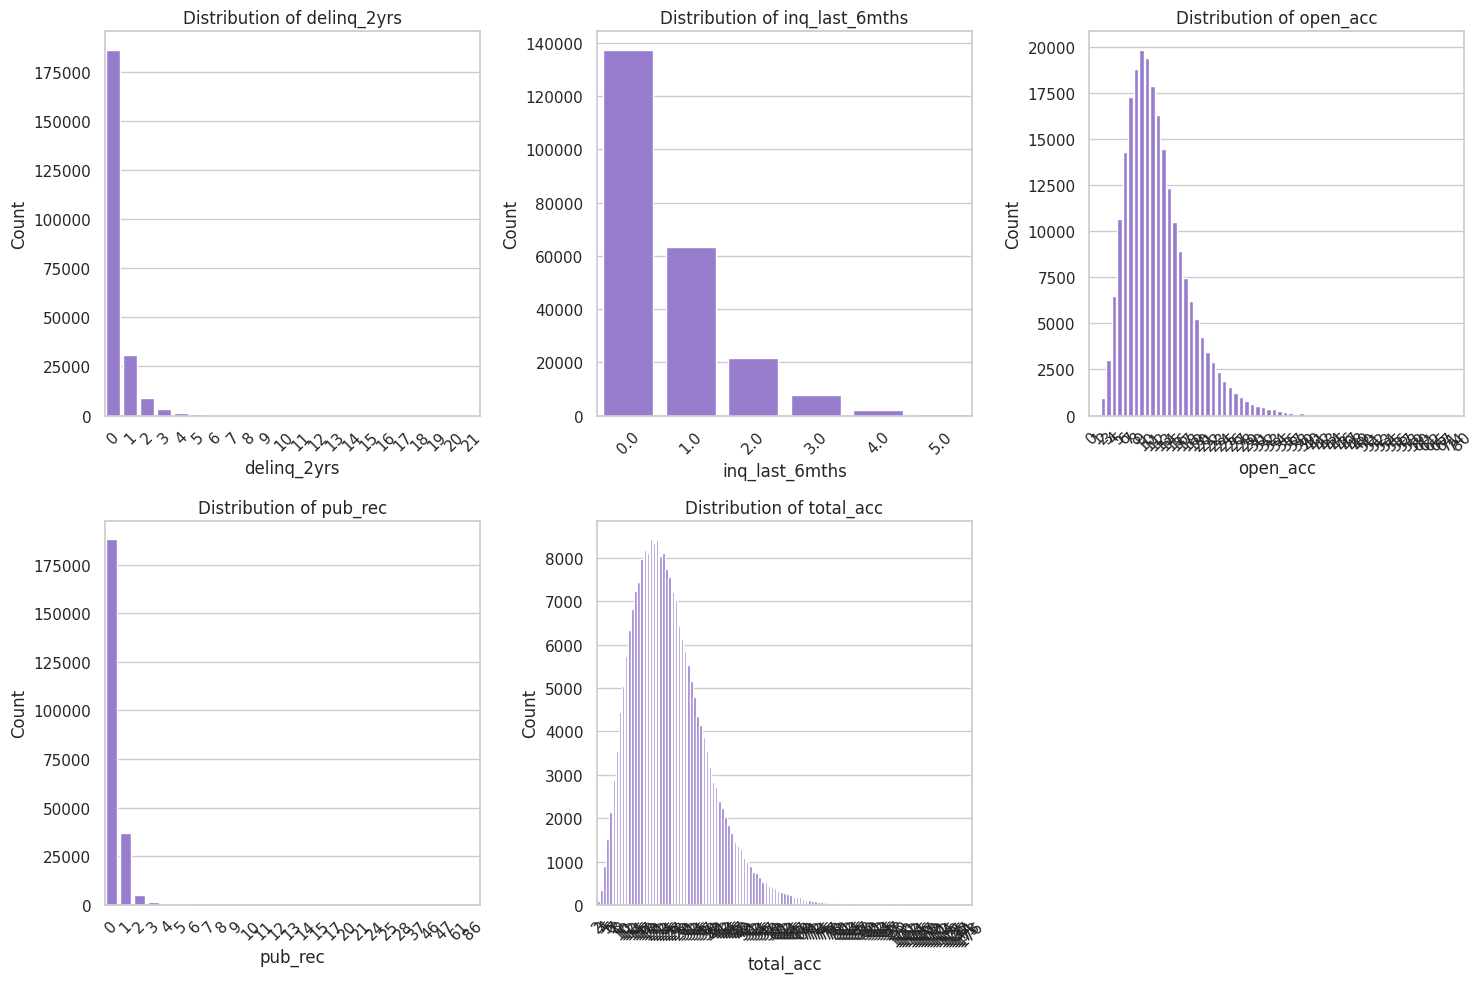

In [ ]:
# Count plots for each discrete feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(discrete_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df_train, x=feature, color="mediumpurple")
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

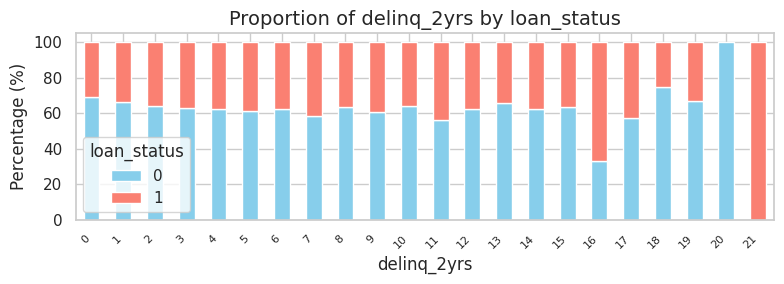

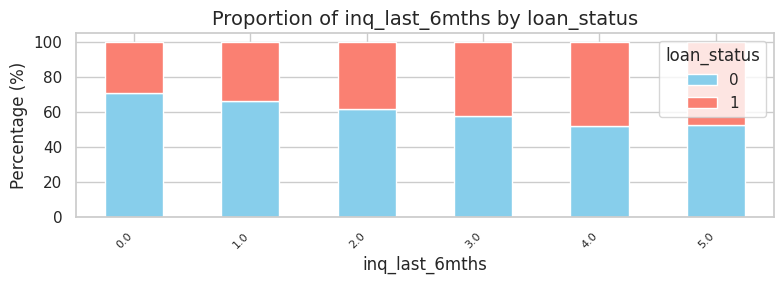

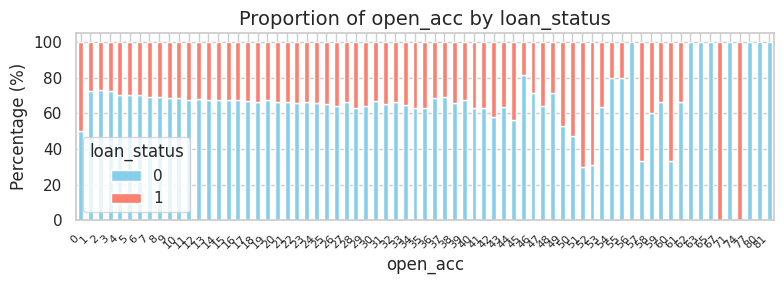

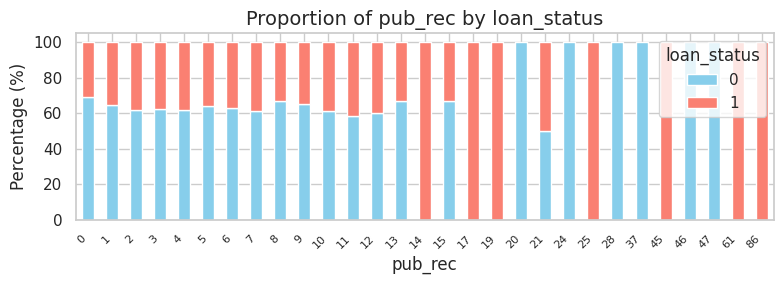

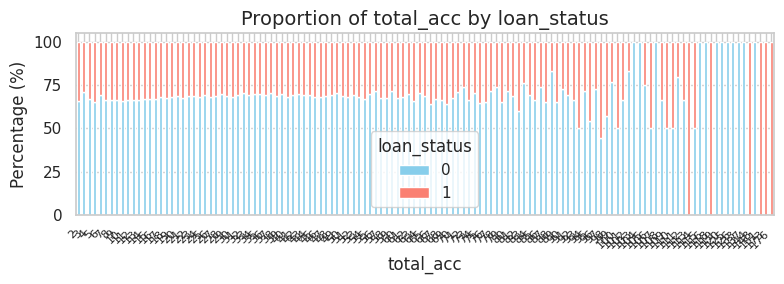

In [ ]:
# Perform cross-tabulations and barplots for discrete features by loan status
for var in discrete_features:

    # Cross-tabulation
    ct = pd.crosstab(df[var], df[target_feature], normalize='index') * 100

    # Bar plot of proportions
    ct.plot(kind='bar', stacked=True, figsize=(8, 3), color=['skyblue', 'salmon'])
    plt.title(f"Proportion of {var} by {target_feature}", fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.legend(title=target_feature)
    plt.tight_layout()
    plt.show()

**Observations and Decisions**

*   (delinq_2yrs): Defaulted loans stedily increase with higher delinquency counts. However, the histogram shows most observations have 3 or less delinquency counts, reducing the significance of the high default rates at higher counts.

Consider binning rare high values or removing outliers for model stability.

*   (inq_last_6mths): Steady increase in defaults at higher inquiries in the last 6 months.

No manual transformation required.

*   (open_acc): Defaults become slightly more prominent at higher open account counts, as well as when it is the client's only open credit line. The distribution again shows most clients have a low number of open credit lines.

Consider capping or binning extreme values (e.g., >30) to avoid skew.

*   (pub_rec): Defaults move erratically with public records, especially beyond 10. This is explained by the vast majority of clients having zero derrogatory public records.

Binning or removing rare high values (>20) could improve model performance. Could also be removed due to low information value.

*   (total_acc): Contrary to open_acc, defaults slightly decrease as the count of total credit lines increases until around 80-90 lines. This is also where most of the distribution lies. From there, we see erratic behaviour due to low sample size.

Capping or binning extreme values may be necessary.

#### Categorical Features

In [ ]:
print(f'There are {len(categorical_features)} categorical features in the dataset.')

There are 10 categorical features in the dataset.


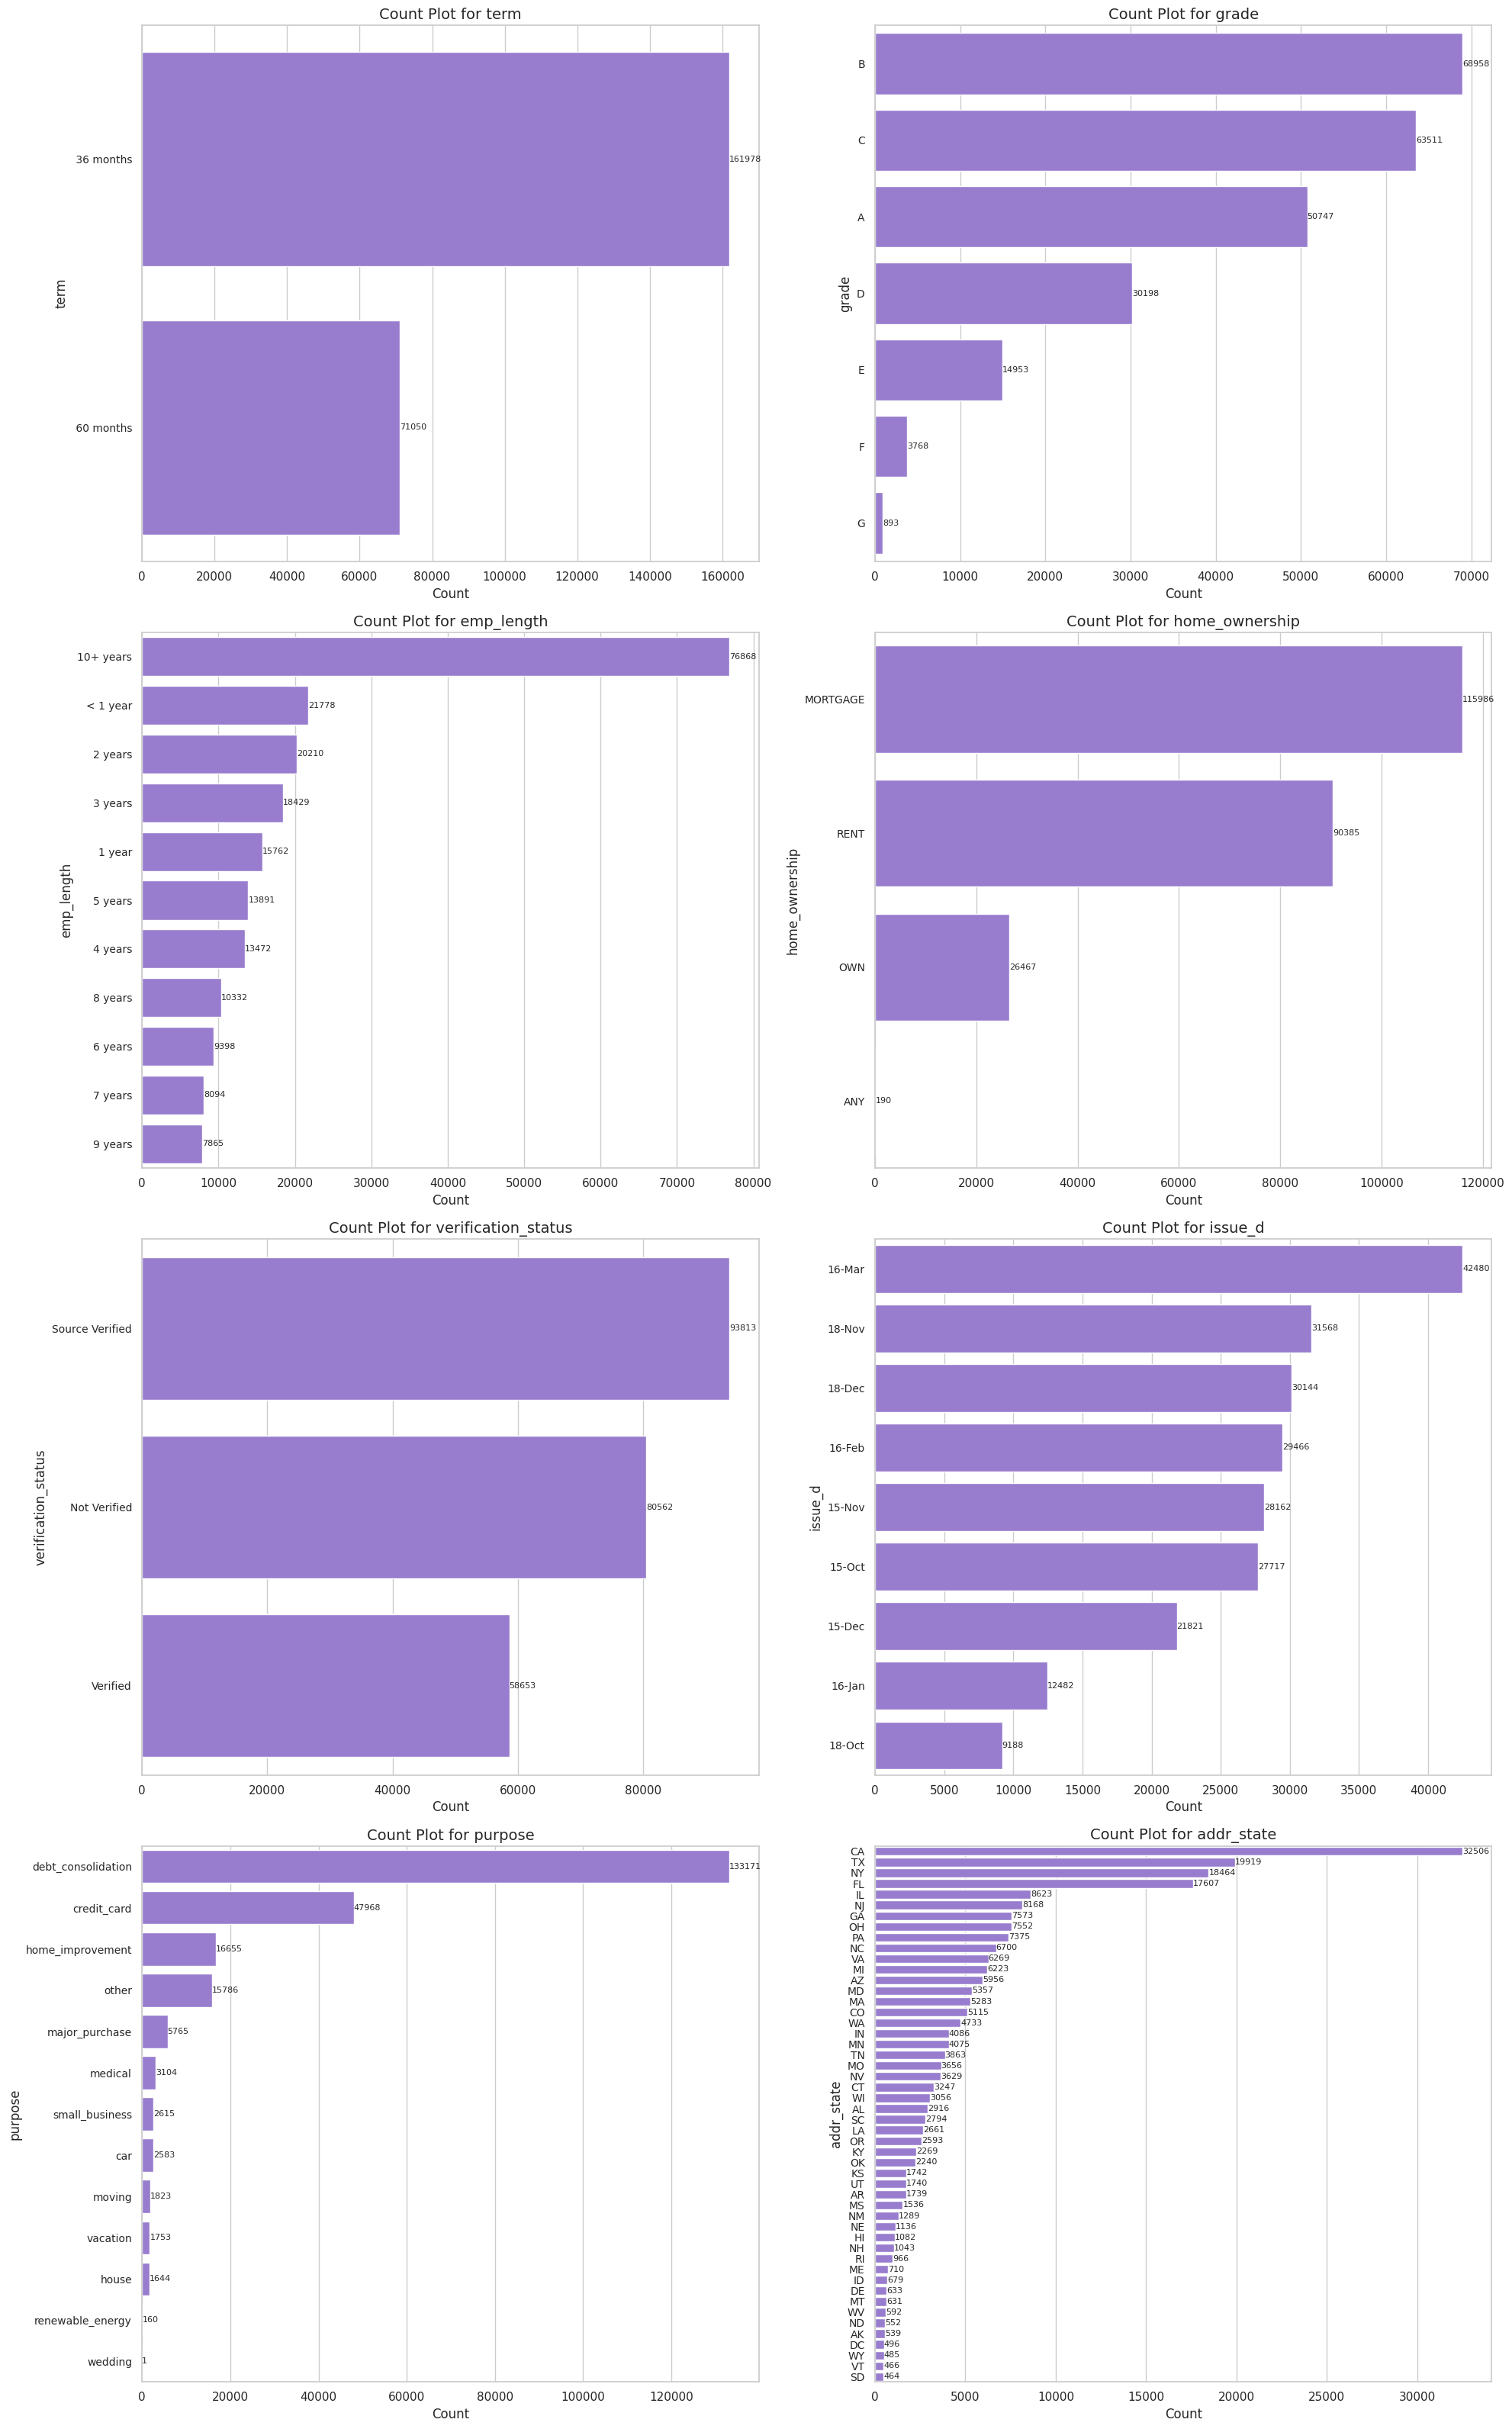

In [ ]:
categorical_features.remove('earliest_cr_line')
categorical_features.remove('emp_title')

# Define the number of rows and columns for the grid
n_cols = 2  # Number of plots per row
n_rows = -(-len(categorical_features) // n_cols)  # Ceiling division to determine rows

# Set up the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8 * n_rows))

# Loop through the categorical variables and create count plots
for i, var in enumerate(categorical_features):
    row, col = divmod(i, n_cols)
    ax = sns.countplot(data=df_train, y=var, ax=axes[row, col], color="mediumpurple", order=df_train[var].value_counts().index)
    ax.set_title(f"Count Plot for {var}", fontsize=14)
    ax.set_xlabel('Count', fontsize=12)
    ax.set_ylabel(var, fontsize=12)

    # Add data labels to the bars
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_width())}',
            (p.get_width(), p.get_y() + p.get_height() / 2),
            ha='left', va='center', fontsize=8
        )

    # Rotate y-axis labels for better readability
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

# Hide any empty subplots if the number of variables isn't a perfect multiple of the grid size
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

categorical_features.append('earliest_cr_line')
categorical_features.append('emp_title')

##### **Home Ownership**

In [ ]:
# Loop through each home_ownership category
for ownership_status in df_train['home_ownership'].unique():
    loans_in_ownership = df_train[df_train['home_ownership'] == ownership_status]
    defaulted_loans = loans_in_ownership[loans_in_ownership[target_feature] == 1] # 1 = Default

    print(f"\nCategory: {ownership_status}")
    print(f"\tTotal Count: {len(loans_in_ownership)} ({round(len(loans_in_ownership) / len(df_train) * 100, 2)}%)")
    print(f"\tDefault Count: {len(defaulted_loans)}")
    print(f"\tDefault Rate: {round(len(defaulted_loans) / len(loans_in_ownership) * 100, 2)}%")


Category: OWN
	Total Count: 26467 (11.36%)
	Default Count: 8197
	Default Rate: 30.97%

Category: RENT
	Total Count: 90385 (38.79%)
	Default Count: 28865
	Default Rate: 31.94%

Category: MORTGAGE
	Total Count: 115986 (49.77%)
	Default Count: 36825
	Default Rate: 31.75%

Category: ANY
	Total Count: 190 (0.08%)
	Default Count: 1
	Default Rate: 0.53%


**Observations:**
- The default rates across the primary home_ownership categories (MORTGAGE, RENT, OWN) are relatively consistent, indicating no strong signal from this feature alone.
- The ANY category is infrequent and displays an anomalously low default rate, which is likely attributable to an insufficient sample size rather than a meaningful pattern.

**Decisions:**
- Two binary indicators can be derived from the home_ownership feature to better capture meaningful distinctions in borrower housing status.
  - OwnsHouse - captures ownership status
    - 0 = Rent & Any
    - 1 = Mortgage & Own
  - HouseExpenses - indicates recurring housing-related financial obligations
    - 0 = Own & Any
    - 1 = Mortgage & Rent

##### **Verification Status**

In [ ]:
# Loop through each verification_status category
for verification_status in df_train['verification_status'].unique():
    loans_in_verification = df_train[df_train['verification_status'] == verification_status]
    defaulted_loans = loans_in_verification[loans_in_verification[target_feature] == 1]

    print(f"\nCategory: {verification_status}")
    print(f"\tTotal Count: {len(loans_in_verification)} ({round(len(loans_in_verification) / len(df_train) * 100, 2)}%)")
    print(f"\tDefault Count: {len(defaulted_loans)}")
    print(f"\tDefault Rate: {round(len(defaulted_loans) / len(loans_in_verification) * 100, 2)}%")


Category: Source Verified
	Total Count: 93813 (40.26%)
	Default Count: 31787
	Default Rate: 33.88%

Category: Not Verified
	Total Count: 80562 (34.57%)
	Default Count: 18288
	Default Rate: 22.7%

Category: Verified
	Total Count: 58653 (25.17%)
	Default Count: 23813
	Default Rate: 40.6%


In [ ]:
# Group "Source Verified" and "Verified" together
grouped_status = df_train['verification_status'].replace({
    'Source Verified': 'Verified'})

# Loop through each grouped verification status category
for verification_group in grouped_status.unique():
    loans_in_verification = df_train[grouped_status == verification_group]
    defaulted_loans = loans_in_verification[loans_in_verification[target_feature] == 1]

    print(f"Category: {verification_group}")
    print(f"  Total Count: {len(loans_in_verification)} ({round(len(loans_in_verification) / len(df_train) * 100, 2)}%)")
    print(f"  Default Count: {len(defaulted_loans)}")
    print(f"  Default Rate: {round(len(defaulted_loans) / len(loans_in_verification) * 100, 2)}%")
    print()

Category: Verified
  Total Count: 152466 (65.43%)
  Default Count: 55600
  Default Rate: 36.47%

Category: Not Verified
  Total Count: 80562 (34.57%)
  Default Count: 18288
  Default Rate: 22.7%



**Observations:**
- Although Verified and Source Verified are treated as distinct categories, functionally they represent the same verification status.
- Borrowers with Not Verified status exhibit a significant lower default rate.
- This pattern reveals a counterintuitive dynamic: verified borrowers exhibit higher default rates, suggesting that income or employment verification may be more frequently required for loans that are inherently riskier

**Decisions:**
- Join both Verified and Source Verified, which will leave us with a binary feature.
- Create a binary indicator to consolidates categories and improve model interpretabilibity
- IsVerified:
  - 1 - Verified & Source Verified
  - 0 - Not Verified

##### **Term**

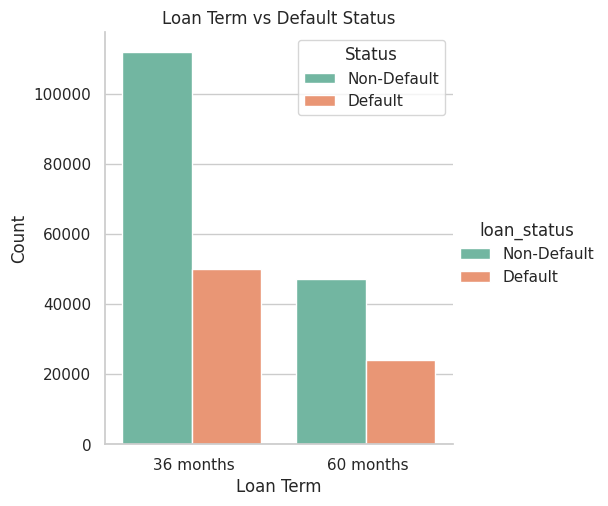

Percentage of defaulted for term " 60 months": 33.64%
Percentage of defaulted for term " 36 months": 30.86%


In [ ]:
# Loan Term vs Default
sns.catplot(data=df_train, x='term',
            hue=df[target_feature].map({0: 'Non-Default', 1: 'Default'}),
            kind='count', palette='Set2')

plt.title('Loan Term vs Default Status')
plt.xlabel('Loan Term')
plt.ylabel('Count')
plt.legend(title='Status')
plt.show()

# Percentage of defaulted loans for each term
for loan_term in df_train['term'].unique():
    loans_in_term = df_train[df_train['term'] == loan_term]
    defaulted_loans = loans_in_term[loans_in_term[target_feature] == 1]

    default_rate = round(len(defaulted_loans) / len(loans_in_term) * 100, 2)
    print(f'Percentage of defaulted for term "{loan_term}": {default_rate}%')

**Observations:**
- The difference in default rates between the loan terms is relatively modest.
- This feature is binary and captures the loan structure, however it shows limited standalone predictive power.

**Decisions:**
- Encode term as a binary variable
  - 0 = 36 months
  - 1 = 60 months

##### **Grade**

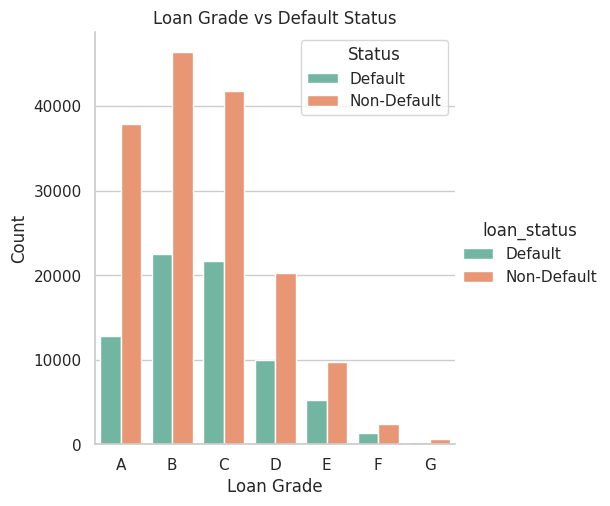


Grade: A
	Total Loans: 50747
	Default Percentage: 25.34%

Grade: B
	Total Loans: 68958
	Default Percentage: 32.64%

Grade: C
	Total Loans: 63511
	Default Percentage: 34.15%

Grade: D
	Total Loans: 30198
	Default Percentage: 32.9%

Grade: E
	Total Loans: 14953
	Default Percentage: 34.9%

Grade: F
	Total Loans: 3768
	Default Percentage: 36.7%

Grade: G
	Total Loans: 893
	Default Percentage: 32.81%


In [ ]:
# Define the correct grade order
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Loan grade vs Default
sns.catplot(data=df_train, x='grade',
            hue=df_train[target_feature].map({0: 'Non-Default', 1: 'Default'}),
            kind='count', order=grade_order, palette='Set2')

plt.title('Loan Grade vs Default Status')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.legend(title='Status')
plt.show()

# Default percentage and total loan count per grade
for grade_value in sorted(df_train['grade'].dropna().unique()):
    loans_in_grade = df_train[df_train['grade'] == grade_value]
    defaulted_loans = loans_in_grade[loans_in_grade[target_feature] == 1]

    total_loans = len(loans_in_grade)
    default_pct = round(len(defaulted_loans) / total_loans * 100, 2)

    print(f'\nGrade: {grade_value}')
    print(f'\tTotal Loans: {total_loans}')
    print(f'\tDefault Percentage: {default_pct}%')

**Observations:**
- The default percentage shows an increasing trend from Grade A to Grafe F, highlighting a strong relationship between loan grade and default risk.
- A few deviations from the overall trend are observed; however, these are likely attributable to limited sample sizes and appear to reflect statistical noise rather than a genuine shift in credit risk.
- The observed trend reinforces that grade is an ordinal feature, where the categories reflect meaningful and ordered risk hierarchy.

**Decisions:**
- Encode the grade features as ordered integers to preserve its ordinal nature
  - A=7, B=6, ..., F=2, G=1

##### **Issue Date**

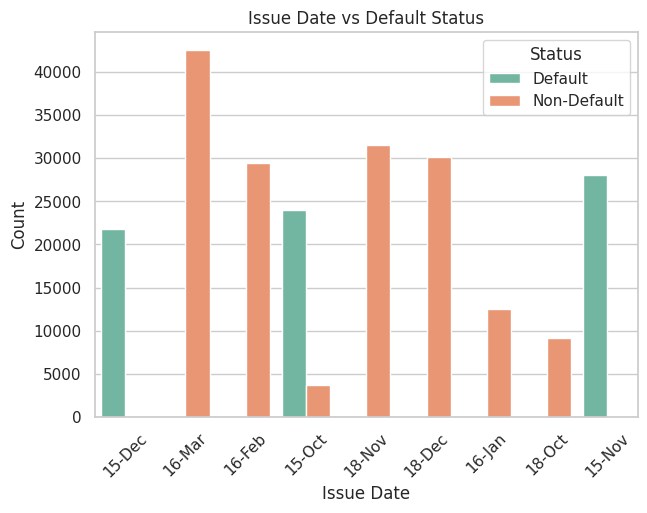

In [ ]:
# Check possible values in 'issue_d' column
df_train['issue_d'].value_counts().sort_index()

# Plot default count by issue date
sns.countplot(data=df_train, x='issue_d',
              hue=df_train[target_feature].map({0: 'Non-Default', 1: 'Default'}),
              palette='Set2')

plt.xticks(rotation=45)
plt.title('Issue Date vs Default Status')
plt.xlabel('Issue Date')
plt.ylabel('Count')
plt.legend(title='Status')
plt.show()

**Observations:**
- The issue_d feature captures the loan issuance date, including day and month, but excludes the year.
- Functionally, the variable lacks temporal context, without the year component, the feature is unlikely to contribute meaningful signal to the model and may introduce noise.

**Decisions:**
- Drop column issue_d

##### **Purpose**

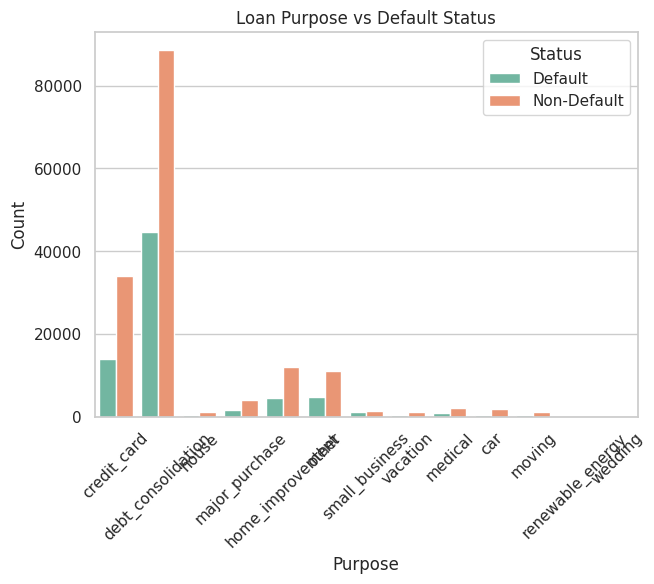

In [ ]:
# Check possible values in 'purpose' column
df_train['purpose'].value_counts()

# Plot default count by loan purpose
sns.countplot(data=df_train, x='purpose',
              hue=df_train[target_feature].map({0: 'Non-Default', 1: 'Default'}),
              palette='Set2')

plt.xticks(rotation=45)
plt.title('Loan Purpose vs Default Status')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.legend(title='Status')
plt.show()

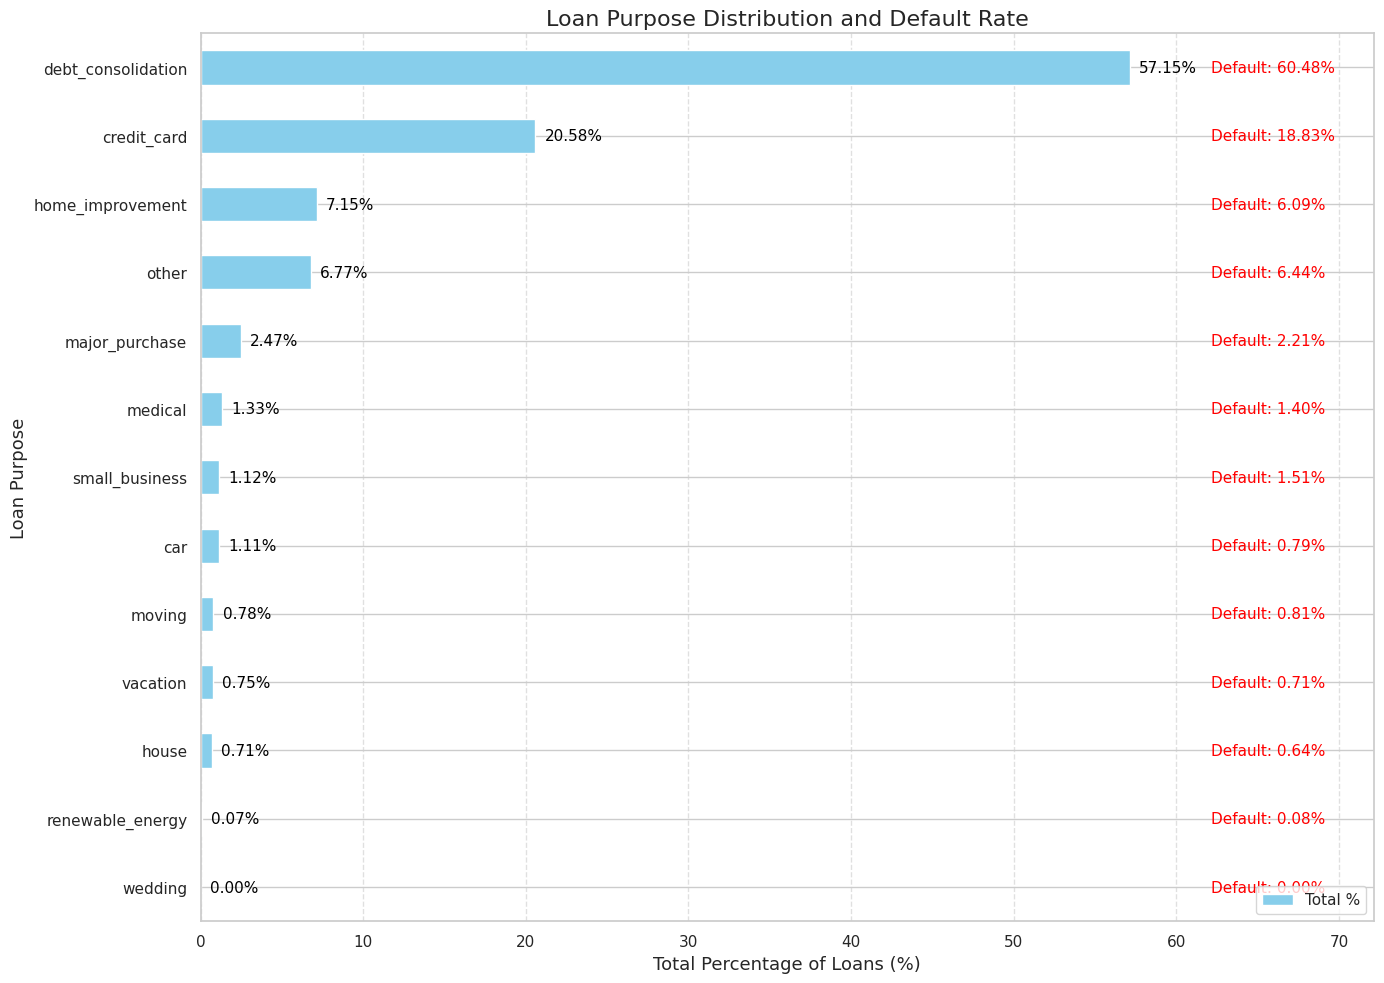

In [ ]:
# Group by purpose and calculate total and default percentages
purpose_total_pct = df_train['purpose'].value_counts(normalize=True) * 100
purpose_default_pct = df_train[df_train[target_feature] == 1]['purpose'].value_counts(normalize=True) * 100

# Combine into one DataFrame
purpose_summary = pd.DataFrame({
    'Total %': purpose_total_pct,
    'Default %': purpose_default_pct
}).fillna(0)

# Sort by total percentage for better visual order
purpose_summary = purpose_summary.sort_values('Total %')

# --- Plotting ---
plt.figure(figsize=(14, 10))
ax = purpose_summary['Total %'].plot(kind='barh', color='skyblue', label='Total %')

# Dynamically set max x-axis for label spacing
x_max = purpose_summary['Total %'].max()

# Add total % labels
for i, v in enumerate(purpose_summary['Total %']):
    ax.text(v + x_max * 0.01, i, f"{v:.2f}%", va='center', color='black', fontsize=11)

# Add default % labels on the right
for i, v in enumerate(purpose_summary['Default %']):
    ax.text(x_max + 5, i, f"Default: {v:.2f}%", va='center', color='red', fontsize=11)

# Formatting
plt.title('Loan Purpose Distribution and Default Rate', fontsize=16)
plt.xlabel('Total Percentage of Loans (%)', fontsize=13)
plt.ylabel('Loan Purpose', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, x_max + 15)
plt.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.show()

**Observations:**
- The majority of loans in the dataset are associated with debt consolidation, it also has the highest default rate.
- Credit cate and home improvement loans also account for a substantial portion of the overall loan volume.
- All other loan purposes occur far less frequently and contribute minimally to the dataset distribution.

**Decision:**
- To reduce categorical sparsity and improve model generalization, retain only the top three most common loan purposes
  - debt_consolidation
  - credit_card
  - home_improvement
- Reclassify all remaining categories under a single consolidated label
  - other

##### **Employment length**

16929


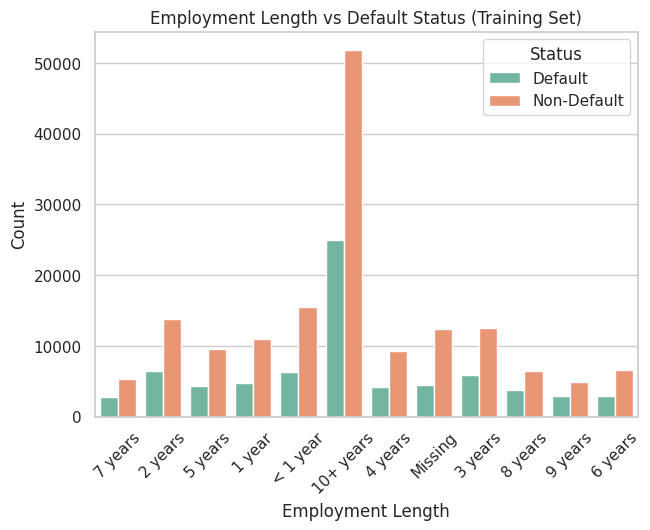

In [ ]:
# Count missing values
print(df_train['emp_length'].isnull().sum())

# Value counts
df_train["emp_length"].value_counts(dropna=False)

# Create a copy of df_train to include missing employment length
plot_df = df_train.copy()
plot_df['emp_length'] = plot_df['emp_length'].fillna('Missing')

# Plot default count by employment length (including missing)
sns.countplot(data=plot_df, x='emp_length',
              hue=plot_df[target_feature].map({0: 'Non-Default', 1: 'Default'}),
              palette='Set2')

plt.xticks(rotation=45)
plt.title('Employment Length vs Default Status (Training Set)')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.legend(title='Status')
plt.show()

In [ ]:
# Count total missing values in 'emp_length'
missing_emp_length_count = df_train['emp_length'].isnull().sum()

# Count rows where both 'emp_length' and 'emp_title' are missing
both_emp_fields_missing = df_train[df_train['emp_length'].isnull() & df_train['emp_title'].isnull()].shape[0]

# Rows where only 'emp_length' is missing but 'emp_title' is present
emp_length_only_missing = missing_emp_length_count - both_emp_fields_missing

# Calculate percentages
both_missing_pct = round(both_emp_fields_missing / missing_emp_length_count * 100, 2)
emp_length_only_missing_pct = round(emp_length_only_missing / missing_emp_length_count * 100, 2)

# Display results
print(f"Out of {missing_emp_length_count} rows with missing 'emp_length':")
print(f"- {both_emp_fields_missing} rows ({both_missing_pct}%) also have missing 'emp_title'")
print(f"- {emp_length_only_missing} rows ({emp_length_only_missing_pct}%) have a filled 'emp_title'")

Out of 16929 rows with missing 'emp_length':
- 16841 rows (99.48%) also have missing 'emp_title'
- 88 rows (0.52%) have a filled 'emp_title'


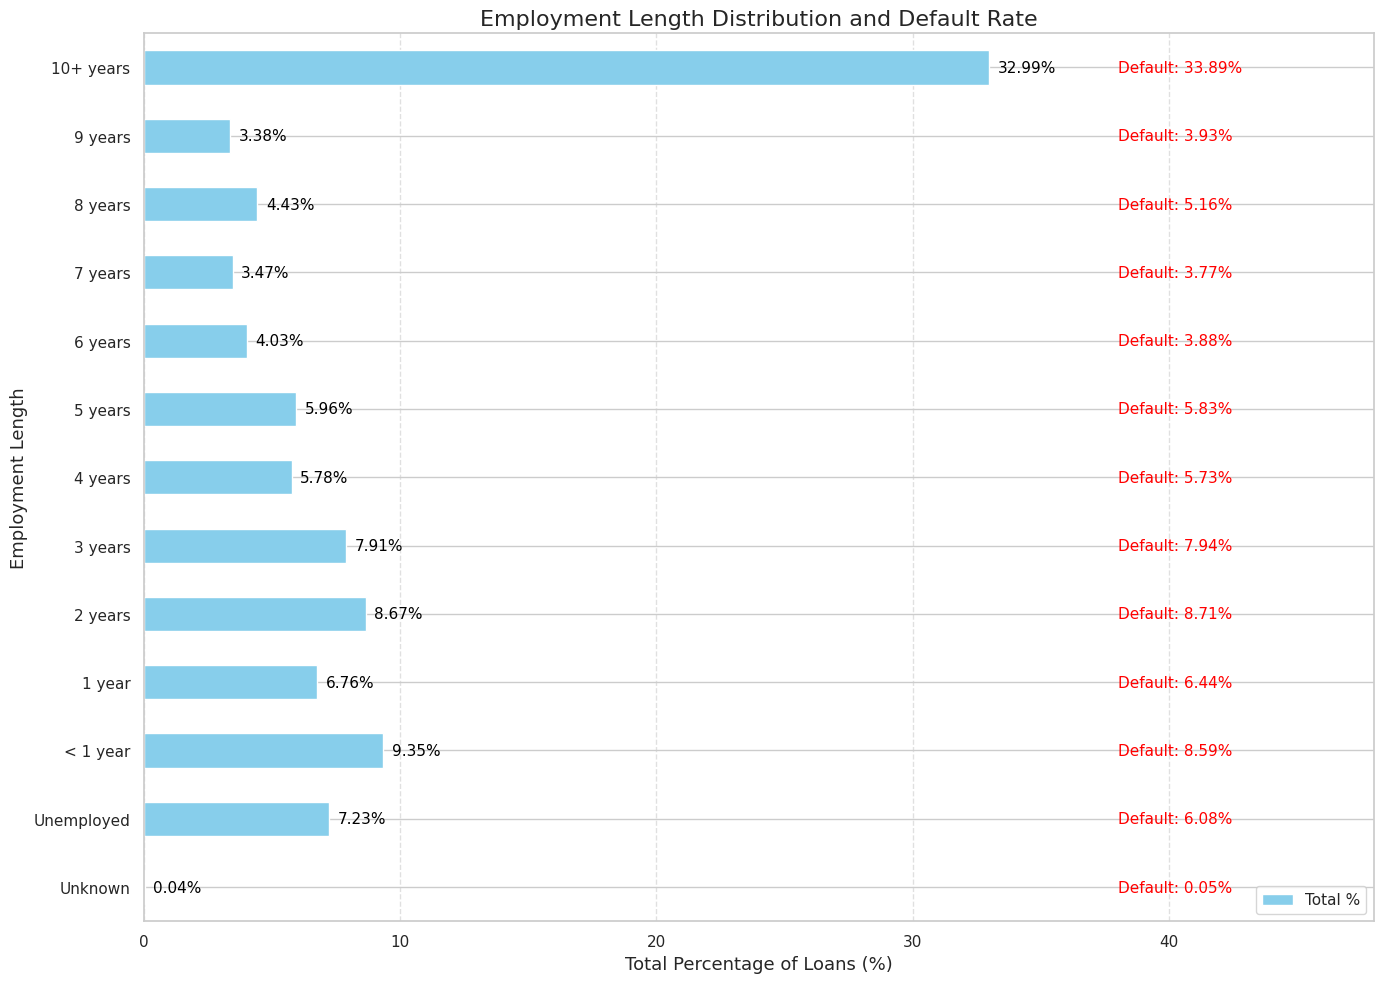

In [ ]:
# Generate a clean version of emp_length without modifying df_train
emp_length_series = df_train['emp_length'].copy()
emp_length_series[df_train['emp_length'].isnull() & df_train['emp_title'].isnull()] = 'Unemployed'
emp_length_series[df_train['emp_length'].isnull() & df_train['emp_title'].notnull()] = 'Unknown'

# Compute total % and default %
emp_total_pct = emp_length_series.value_counts(normalize=True) * 100
emp_default_pct = emp_length_series[df_train['loan_status'] == 1].value_counts(normalize=True) * 100

# Combine
emp_summary = pd.DataFrame({
    'Total %': emp_total_pct,
    'Default %': emp_default_pct
}).fillna(0)

# Order
emp_order = [
    'Unknown', 'Unemployed', '< 1 year', '1 year', '2 years', '3 years', '4 years',
    '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'
]
emp_summary = emp_summary.reindex(emp_order)

# Plot
plt.figure(figsize=(14, 10))
ax = emp_summary['Total %'].plot(kind='barh', color='skyblue', label='Total %')

x_max = emp_summary['Total %'].max()

# Add Total % labels
for i, v in enumerate(emp_summary['Total %']):
    if not pd.isna(v):
        ax.text(v + x_max * 0.01, i, f"{v:.2f}%", va='center', color='black', fontsize=11)

# Add Default % labels
for i, v in enumerate(emp_summary['Default %']):
    if not pd.isna(v):
        ax.text(x_max + 5, i, f"Default: {v:.2f}%", va='center', color='red', fontsize=11)

# Final formatting
plt.title('Employment Length Distribution and Default Rate', fontsize=16)
plt.xlabel('Total Percentage of Loans (%)', fontsize=13)
plt.ylabel('Employment Length', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, x_max + 15)
plt.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.show()

**Observations:**
- The emp_length captures the number of years the borrower has been employed.
- A significant portion of this feature contains missing values. However, the vast majority of these cases also have missing values in emp_title, suggesting that the borrower is unemployed at the time of application.
- Functionally, this is an ordinal feature, representing increasing levels of job stability with longer employment duration.
  - While the default rate does not decrease strictly with more years of employment, the distribution shows a strong concentration of loans among borrowers with 10+ years of experience, indicating a lender preference for long-term employment.
  - Although this dataset alone doesn’t statistically prove the ordinal relationship with default, the semantic structure of the feature clearly supports its ordinal nature.

**Decisions:**
- Fill  emp_length as "Unemployed" where both emp_length and emp_title are missing.
- Fill emp_length as "Unknown" where emp_length is missing but emp_title has a value.
- Map the cleaned emp_length values to ordinal intengers from 0 to 13:
  - 0 = Unknown
  - 1 = Unemployed
  - 2 = < 1 year
  - ...
  - 13 = "10+ years"

##### **Employment title**

In [ ]:
# Check for missing values in 'emp_title'
total_missing_emp_title = df_train['emp_title'].isnull().sum()
print(f"Missing values in emp_title: {total_missing_emp_title}\n")

# Count unique values in 'emp_title'
sum_unique_values_emp_title = df_train['emp_title'].nunique(dropna=False)
print(f"Unique values in 'emp_title': {sum_unique_values_emp_title}")

# Total missing emp_title
total_missing_emp_title = df_train['emp_title'].isnull().sum()

# Rows where emp_title is missing AND emp_length is also missing
both_missing = df_train[df_train['emp_title'].isnull() & df_train['emp_length'].isnull()].shape[0]

# Rows where emp_title is missing BUT emp_length is present
emp_length_present = total_missing_emp_title - both_missing

# Percentages
both_missing_pct = round(both_missing / total_missing_emp_title * 100, 2)
emp_length_present_pct = round(emp_length_present / total_missing_emp_title * 100, 2)

print(f"\nOut of {total_missing_emp_title} rows with missing 'emp_title':")
print(f"- {both_missing} rows ({both_missing_pct}%) also have missing 'emp_length'")
print(f"- {emp_length_present} rows ({emp_length_present_pct}%) have a filled 'emp_length'")

Missing values in emp_title: 22188

Unique values in 'emp_title': 72454

Out of 22188 rows with missing 'emp_title':
- 16841 rows (75.9%) also have missing 'emp_length'
- 5347 rows (24.1%) have a filled 'emp_length'


In [ ]:
# Get value counts and percentage for top 5 entries in emp_title
top_counts = df_train['emp_title'].value_counts(dropna=False).head(5)
top_percent = (top_counts / len(df_train)) * 100

# Results
summary = pd.DataFrame({'Count': top_counts, 'Percentage': top_percent.round(2)})
summary

,Count,Percentage
emp_title,,
NaN,22188,9.52
Teacher,4237,1.82
Manager,3699,1.59
Owner,2024,0.87
Registered Nurse,1825,0.78


**Observations:**
- The emp_title feature contains a very high number of unique values, reflecting a free-text nature of job titles entered by applicants.
- The majority of missing values in this column coincide with missing values in emp_length, suggesting that the individual is unemployed.
- even the most common job titles each account for less than 2% of the dataset, highlighting the lack of dominat categories.
- While potentially informative, the lack of standardization limits its value.
- Additionally, most of the useful information this column conveys is already captured by other features.
  - annual_inc reflects the borrower's income
  - emp_length already convetys employment status

**Decisions:**
- Drop emp_title

##### **Earliest Credit Line**

In [ ]:
df['earliest_cr_line'].sample(25)

,earliest_cr_line
238627,1-May
51380,7-Dec
240622,6-Aug
44421,6-Mar
50609,6-Oct
102078,Sep-97
6139,Dec-94
51935,Jun-00
105787,8-Jan
36874,Jan-83


In [ ]:
# Define format classifier
def classify_format(entry):
    entry = str(entry).strip()
    if re.match(r"^[A-Za-z]{3}-\d{2}$", entry):  # Jan-80
        return "MMM-YY"
    elif re.match(r"^\d{1,2}-[A-Za-z]{3}$", entry):  # 4-Dec
        return "D-MMM"
    elif re.match(r"^[A-Za-z]{3}-\d{4}$", entry):  # Dec-1996
        return "MMM-YYYY"
    elif re.match(r"^\d{4}-\d{2}$", entry):  # 1980-01
        return "YYYY-MM"
    else:
        return "Unknown"

# Create a copy to work safely
df_train_format = df_train.copy()
df_train_format['entry_format'] = df_train_format['earliest_cr_line'].astype(str).apply(classify_format)

# Show counts of each format
print("Format frequency:\n")
print(df_train_format['entry_format'].value_counts())

# Show sample values from each format
print("\nExample values from each format:\n")
for fmt in df_train_format['entry_format'].unique():
    examples = df_train_format[df_train_format['entry_format'] == fmt]['earliest_cr_line'].dropna().unique()[:5]
    print(f"\nFormat: {fmt} — {len(df_train_format[df_train_format['entry_format'] == fmt])} rows")
    print(examples)

Format frequency:

entry_format
D-MMM     128779
MMM-YY    104249
Name: count, dtype: int64

Example values from each format:


Format: D-MMM — 128779 rows
['4-Aug' '4-Jul' '11-Dec' '3-Apr' '3-Feb']

Format: MMM-YY — 104249 rows
['Sep-92' 'Jun-99' 'May-97' 'Apr-99' 'Dec-94']


**Observations:**
- The earliest_cr_line feature indicates the date of the borrower's first recorded credit line.
- The inconsistent formatting of this field across observations makes it difficult to extract meaningful information.
- While the year of first credit usage could offer valuable insights into credit history and borrower reliability, the lack of standardization prevents us from utilizing this feature effectively in its current state.

**Decisions:**
- Drop earliest_cr_line

##### **Address State**

In [ ]:
print(df_train['addr_state'].nunique())

df_train['addr_state'].sample(5)

50


,addr_state
98728,SC
256984,AL
152543,CA
304242,CO
58430,NY


In [ ]:
# 50 U.S. states
us_states = set([
    'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA',
    'HI','ID','IL','IN','IA','KS','KY','LA','ME','MD',
    'MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ',
    'NM','NY','NC','ND','OH','OK','OR','PA','RI','SC',
    'SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'
])

# Get unique values
addr_states = set(df_train['addr_state'].dropna().unique())

# Cross-check
states_missing = us_states - addr_states
non_states = addr_states - us_states

# Print results
print(f"Missing states from df_train ({len(states_missing)}):\n{sorted(states_missing)}\n")
print(f"Non-50 states found in df_train ({len(non_states)}):\n{sorted(non_states)}")

Missing states from df_train (1):
['IA']

Non-50 states found in df_train (1):
['DC']


**Observations:**
- The addr_state feature represents the U.S. state associated with the borrower's registered address.
- Each state can be mapped to one of the 9 standard U.S. Census Bureau divisions, a grouping that is commonly used in demographic analysis and credit risk modeling.
- Using divisions instead of individual states can help reduce dimensionality and capture regional economic patterns while preserving geographic relevance.

**Decisions:**
- Transform addr_state feature into its corresponding U.S. Census division

# 3. Preprocessing and Feature Engeneering

### 3.1. Numerical Features

#### Duplicate IDs

In [ ]:
# Check for duplicate rows based on the "id" column
duplicate_rows = df_train[df_train.duplicated(subset=['id'], keep=False)]

# Counting the number of duplicate rows
print("Number of records with duplicate loan ids:", duplicate_rows.shape[0])

Number of records with duplicate loan ids: 0


#### Outliers Treatment

In [ ]:
def remove_outliers_iqr(df, columns, threshold=1.5, method='any', log_transform=True, verbose=True, iqr_bounds=None):

    # Create temporary transformed copy
    temp_df = df.copy()

    # Apply log transformation to eligible columns
    if log_transform:
        for col in columns:
            # Skip columns with negative values or zeros
            if temp_df[col].min() >= 0 and temp_df[col].nunique() > 1:
                temp_df[col] = np.log1p(temp_df[col])

    # Initialize masks and bounds
    outlier_mask = pd.Series(False, index=df.index)
    col_outliers = {}
    computed_iqr_bounds = {} if iqr_bounds is None else iqr_bounds

    # Calculate or use provided IQR bounds
    for col in columns:
        # Skip constant columns
        if temp_df[col].nunique() <= 1:
            continue

        if iqr_bounds is None:
            # Calculate IQR bounds from the input DataFrame
            q1 = temp_df[col].quantile(0.25)
            q3 = temp_df[col].quantile(0.75)
            iqr = q3 - q1

            # Skip columns with IQR=0
            if iqr <= 0:
                continue

            lower_bound = q1 - threshold * iqr
            upper_bound = q3 + threshold * iqr
            computed_iqr_bounds[col] = (lower_bound, upper_bound)
        else:
            # Use provided IQR bounds
            if col not in iqr_bounds:
                continue
            lower_bound, upper_bound = iqr_bounds[col]

        # Find column outliers in transformed space
        col_outlier = (temp_df[col] < lower_bound) | (temp_df[col] > upper_bound)
        col_outliers[col] = col_outlier
        outlier_mask = outlier_mask | col_outlier if method == 'any' else outlier_mask & col_outlier

    # Split data
    df_outlier = df[outlier_mask]
    df_inlier = df[~outlier_mask]

    # Print diagnostics
    if verbose:
        n_outliers = outlier_mask.sum()
        perc_outliers = 100 * n_outliers / len(df)
        print(f"Total rows: {len(df)}")
        print(f"Outliers removed: {n_outliers} rows ({perc_outliers:.2f}%)")
        print(f"Remaining inliers: {len(df_inlier)} rows\n")

    if iqr_bounds is None:
        return df_inlier, df_outlier, computed_iqr_bounds
    return df_inlier, df_outlier

In [ ]:
# Apply to train and validation sets
# Compute IQR bounds from training data
train_clean, train_outliers, train_iqr_bounds = remove_outliers_iqr(df_train, continuous_features, threshold=3)

# Apply to validation set using training IQR bounds
val_clean, val_outliers = remove_outliers_iqr(df_val, continuous_features, threshold=3, iqr_bounds=train_iqr_bounds)

print(f'Training set shape: {train_clean.shape}')
print(f'Validation set shape: {val_clean.shape}')

Total rows: 233028
Outliers removed: 5438 rows (2.33%)
Remaining inliers: 227590 rows

Total rows: 77676
Outliers removed: 1678 rows (2.16%)
Remaining inliers: 75998 rows

Training set shape: (227590, 28)
Validation set shape: (75998, 28)


#### Missing Values Imputation

In [ ]:
# Calculate the number and percentage of missing values for
# numerical features of the training & validation sets
missing_values_num = train_clean[numerical_features].isnull().sum()
missing_values_num_val = val_clean[numerical_features].isnull().sum()

missing_values_percentage_num = train_clean[numerical_features].isnull().mean() * 100
missing_values_percentage_num_val = val_clean[numerical_features].isnull().mean() * 100

# Combine into a DataFrame and filter out columns with no missing values
missing_values_df_num = pd.DataFrame({
    "Number of Missing Values in Train": missing_values_num[missing_values_num > 0],
    "Percentage of Missing Values in Train": missing_values_percentage_num[missing_values_percentage_num > 0],
    "Number of Missing Values in Validation": missing_values_num_val[missing_values_num_val > 0],
    "Percentage of Missing Values in Validation": missing_values_percentage_num_val[missing_values_percentage_num_val > 0]
})

# Sort by percentage of missing values in descending order
missing_values_sorted_num = missing_values_df_num.sort_values(by="Percentage of Missing Values in Train", ascending=False)
missing_values_sorted_num

,Number of Missing Values in Train,Percentage of Missing Values in Train,Number of Missing Values in Validation,Percentage of Missing Values in Validation
dti,111,0.048772,31.0,0.040791
revol_util,32,0.014060,12.0,0.015790
inq_last_6mths,1,0.000439,NaN,NaN


In [ ]:
# Calculate imputation values from TRAIN set only
impute_values = {}
for col in train_clean.columns:
    if col in continuous_features:
        impute_values[col] = train_clean[col].mean()  # MEAN for continuous
    elif col in discrete_features:
        impute_values[col] = train_clean[col].median()  # MEDIAN for discrete
    elif col in categorical_features:
        impute_values[col] = train_clean[col].mode()[0]  # MODE for categorical

# Impute missing values in TRAIN and VALIDATION sets using train statistics
train_imputed = train_clean.copy()
val_imputed = val_clean.copy()
test_imputed = df_test.copy()

for col, value in impute_values.items():
    train_imputed[col].fillna(value, inplace=True)
    val_imputed[col].fillna(value, inplace=True)
    test_imputed[col].fillna(value, inplace=True)

# Verify results
print("Missing values in train_imputed:", train_imputed.isnull().sum().sum())
print("Missing values in val_imputed:", val_imputed.isnull().sum().sum())

Missing values in train_imputed: 0
Missing values in val_imputed: 0


#### Feature Creation

New numerical features created:

1. **Debt-to-Income Ratio with Loan Amount (dti_with_loan)**
  - Formula: `dti * (loan_amnt / annual_inc)`
  - Rationale: Combines the debt-to-income ratio (dti) with the loan amount relative to annual income to assess the borrower's ability to manage additional debt.

2. **Payment-to-Income Ratio (payment_to_income)**
  - Formula: `installment / annual_inc`
  - Rationale: Measures the proportion of income dedicated to monthly loan payments, indicating financial strain.

3. **Utilization-to-Loan Ratio (util_to_loan)**
  - Formula: `revol_util * (revol_bal / loan_amnt)`
  - Rationale: Combines revolving credit utilization (revol_util) and balance (revol_bal) with the loan amount to evaluate the borrower's overall credit usage relative to the loan.

4. **Delinquency Impact Score (delinq_impact)**
  - Formula: `delinq_2yrs * (loan_amnt / total_acc)`
  - Rationale: Reflects the severity of past delinquencies (delinq_2yrs) adjusted by loan size and total credit lines (total_acc), highlighting risk from past behavior.

5. **Remaining Principal Ratio (remaining_principal_ratio)**
  - Formula: `out_prncp / loan_amnt`
  - Rationale: Indicates the proportion of the original loan amount still outstanding, useful for assessing repayment progress.

6. **Total Payment Efficiency (payment_efficiency)**
  - Formula: `total_pymnt / (loan_amnt + out_prncp)`
  - Rationale: Measures how efficiently payments have been made relative to the funded amount and remaining principal.

In [ ]:
def create_numerical_features(df, fill_value=0):
    # New feature calculations
    df = df.copy()
    df['dti_with_loan'] = df['dti'] * (df['loan_amnt'] / df['annual_inc'])
    df['payment_to_income'] = df['installment'] / df['annual_inc']
    df['util_to_loan'] = df['revol_util'] * (df['revol_bal'] / df['loan_amnt'])
    df['delinq_impact'] = df['delinq_2yrs'] * (df['loan_amnt'] / df['total_acc'])
    df['remaining_principal_ratio'] = df['out_prncp'] / df['loan_amnt']
    df['payment_efficiency'] = df['total_pymnt'] / (df['loan_amnt'] + df['out_prncp'])

    # Handle division by zero and missing values
    new_features = ['dti_with_loan', 'payment_to_income', 'util_to_loan', 'delinq_impact', 'remaining_principal_ratio', 'payment_efficiency']
    df[new_features] = df[new_features].replace([np.inf, -np.inf], np.nan)
    df[new_features] = df[new_features].fillna(fill_value)

    return df

df_train = create_numerical_features(train_imputed)
df_val = create_numerical_features(val_imputed)
df_test = create_numerical_features(test_imputed)

In [ ]:
# Add new features to the numerical features list and assign them to the continuous and discrete features lists
new_features = ['dti_with_loan', 'payment_to_income', 'util_to_loan', 'delinq_impact', 'remaining_principal_ratio', 'payment_efficiency']
numerical_features = numerical_features + new_features
continuous_features = continuous_features + new_features
print(len(numerical_features))

22


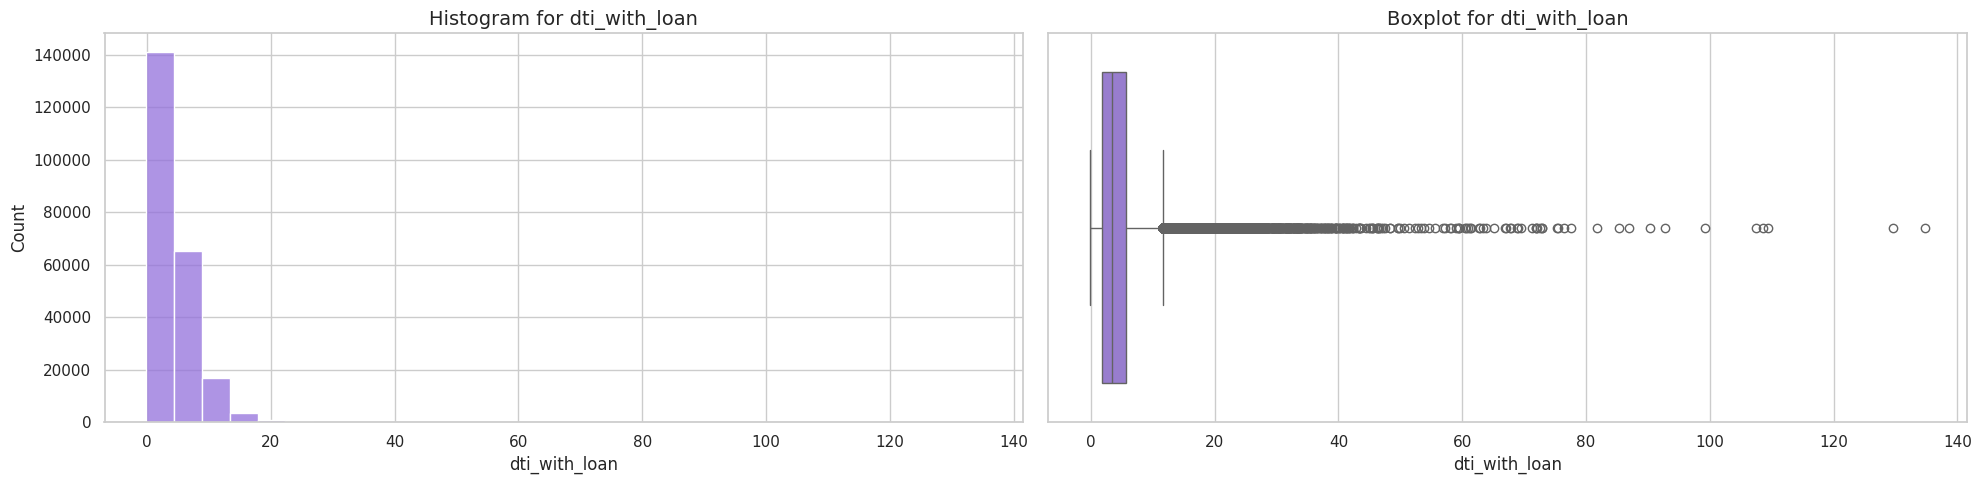

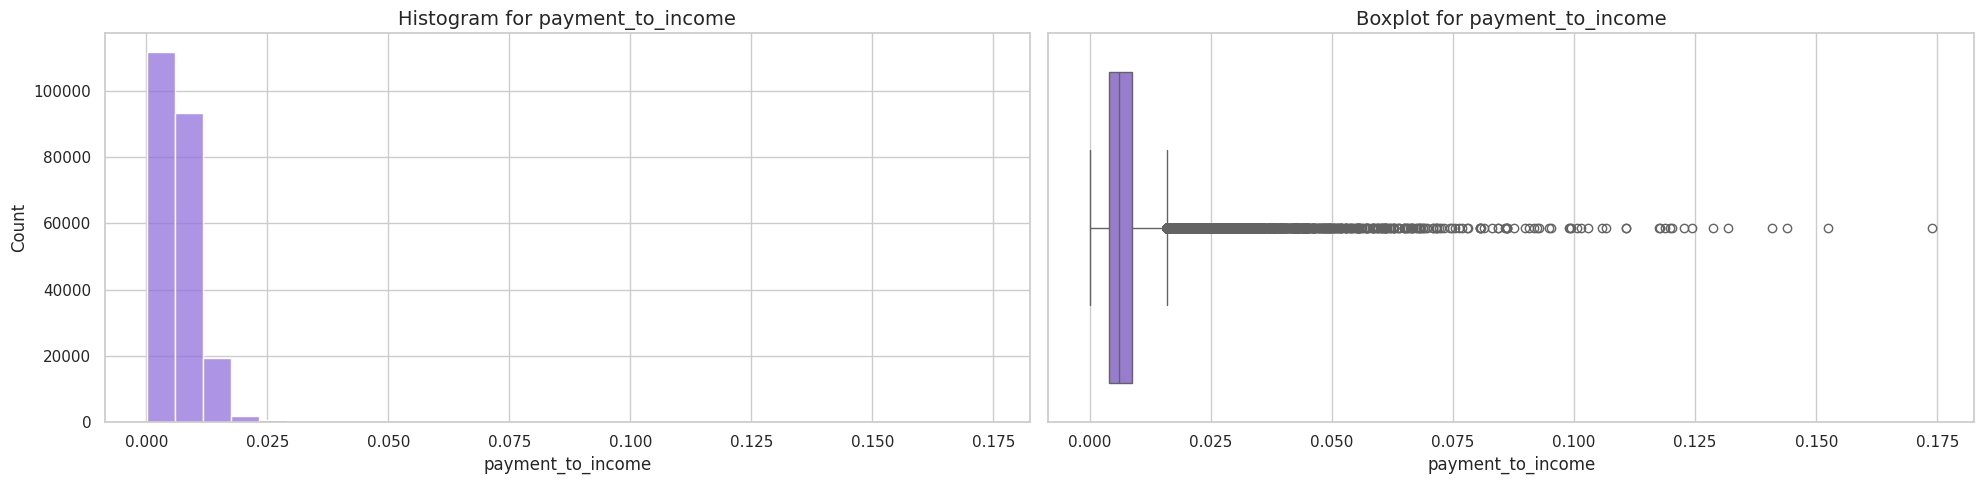

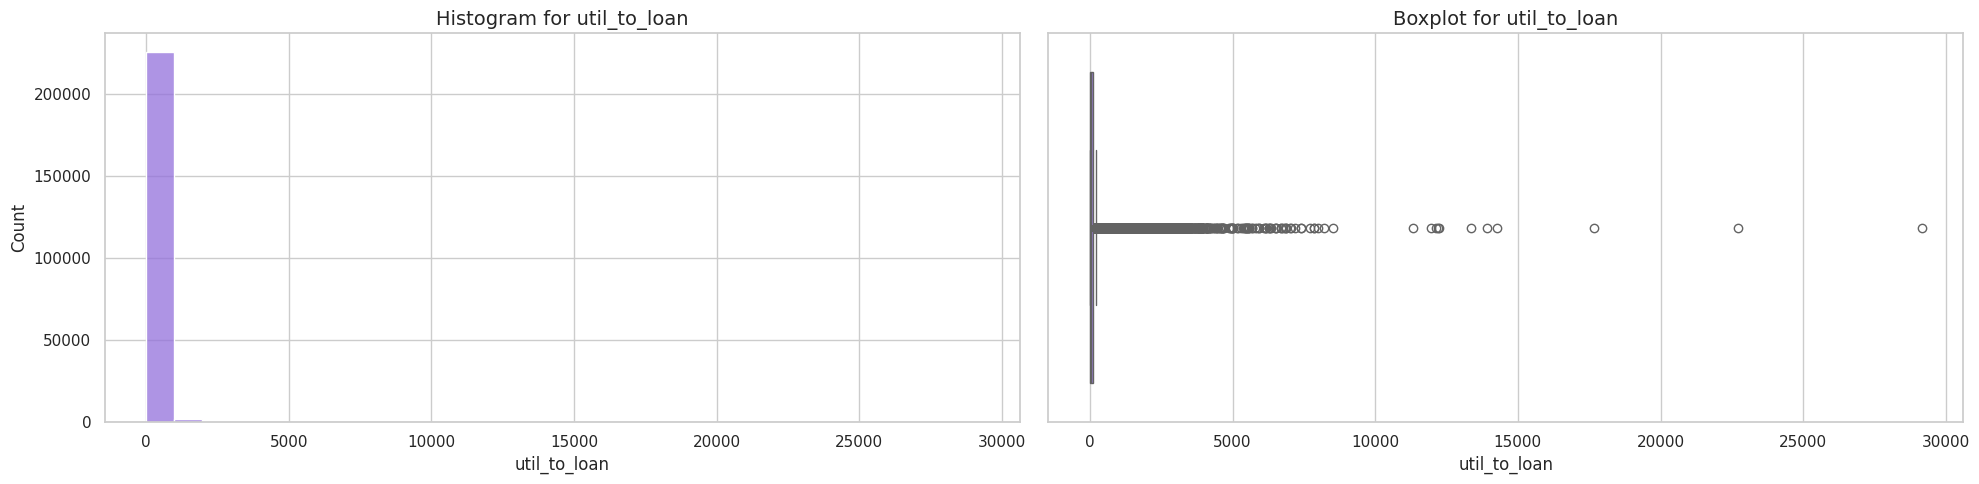

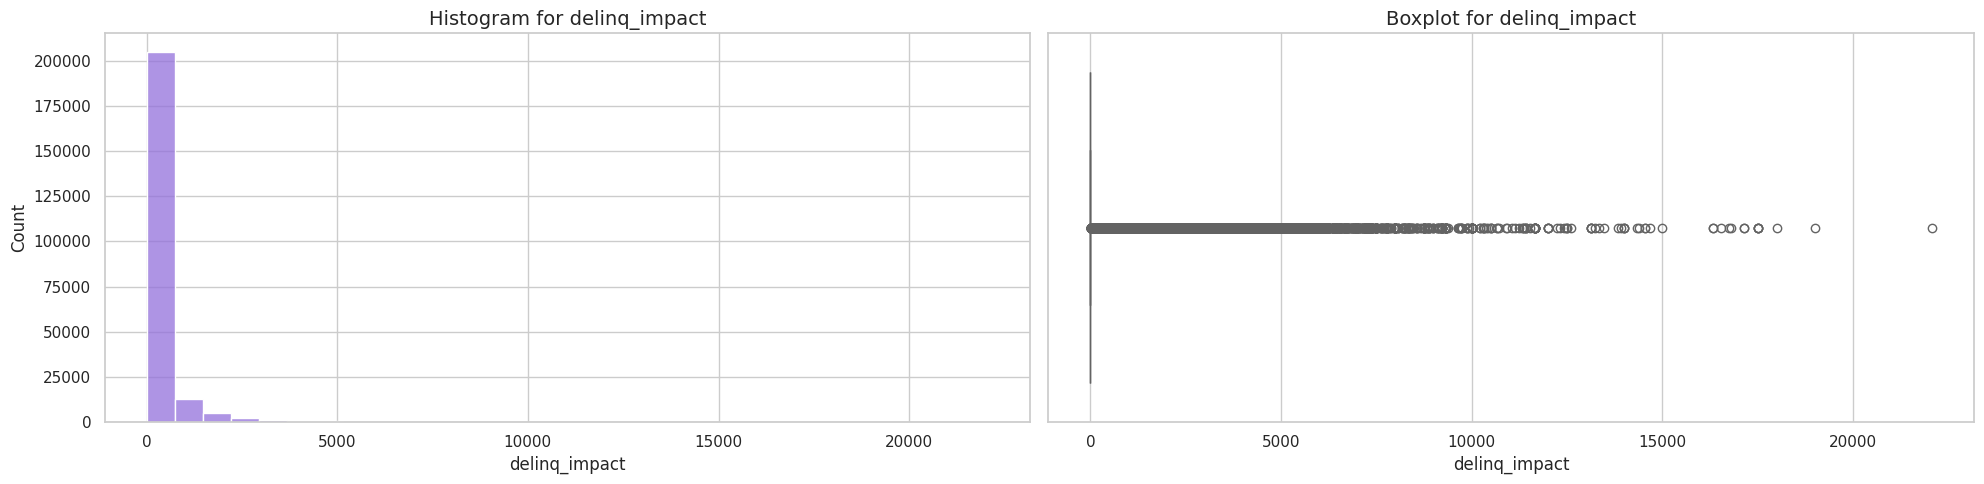

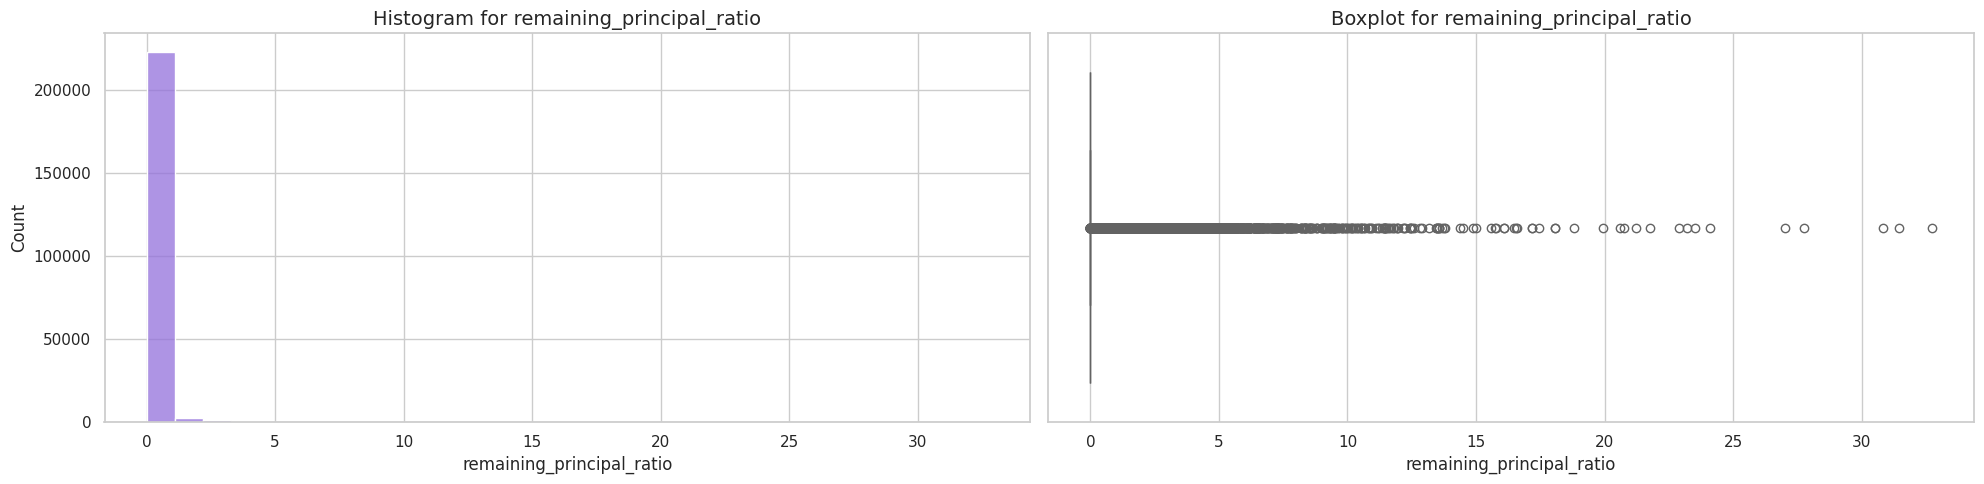

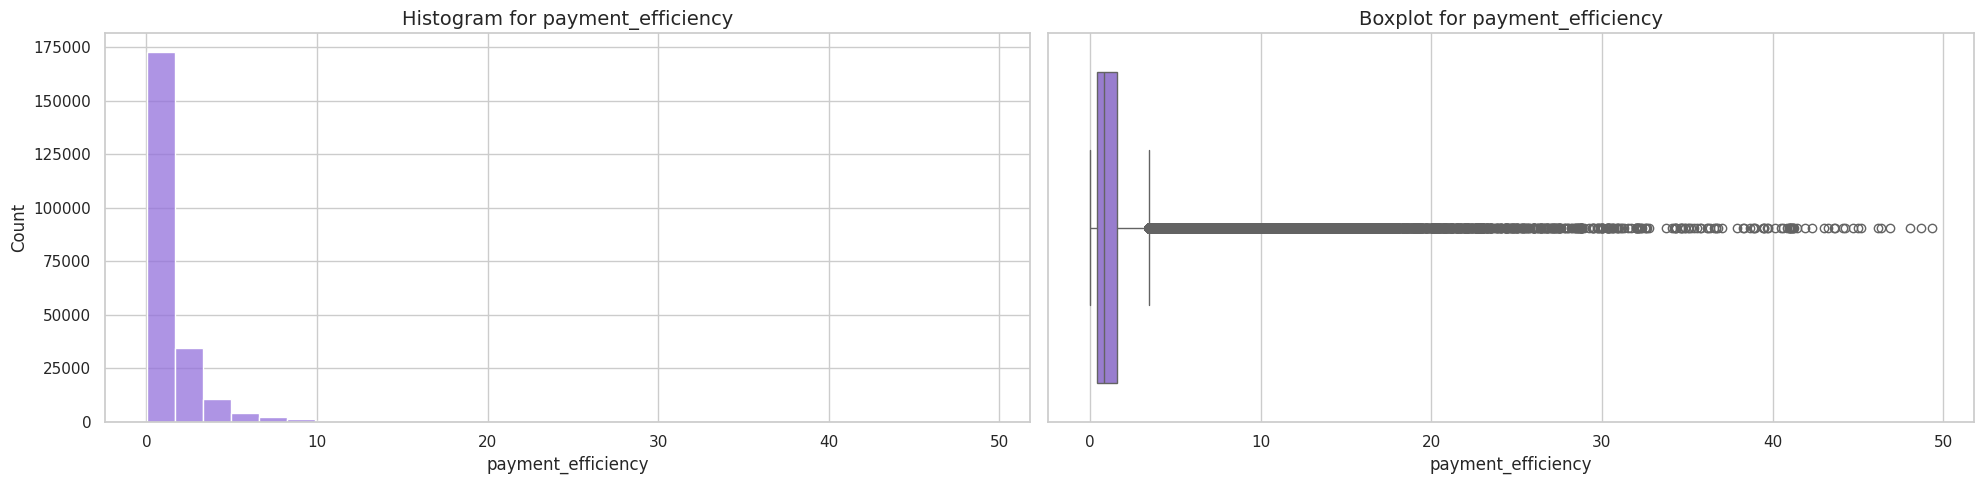

In [ ]:
# Looping through new variables and create plots
for var in new_features:
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    # Histogram
    sns.histplot(data=df_train, x=var, bins=30, kde=False, ax=axes[0], color="mediumpurple")
    axes[0].set_title(f'Histogram for {var}', fontsize=14)
    axes[0].set_xlabel(var, fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)

    # Boxplot
    sns.boxplot(data=df_train, x=var, ax=axes[1], color="mediumpurple")
    axes[1].set_title(f'Boxplot for {var}', fontsize=14)
    axes[1].set_xlabel(var, fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227590 entries, 194787 to 306702
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         227590 non-null  int64  
 1   loan_amnt                  227590 non-null  int64  
 2   funded_amnt                227590 non-null  int64  
 3   funded_amnt_inv            227590 non-null  float64
 4   term                       227590 non-null  object 
 5   int_rate                   227590 non-null  float64
 6   installment                227590 non-null  float64
 7   grade                      227590 non-null  object 
 8   emp_title                  227590 non-null  object 
 9   emp_length                 227590 non-null  object 
 10  home_ownership             227590 non-null  object 
 11  annual_inc                 227590 non-null  float64
 12  verification_status        227590 non-null  object 
 13  issue_d                    22

### 3.2. Categorical Features

#### Feature Engineering

In [ ]:
def categorical_preproc(df, target_variable=None):
    import pandas as pd

    # HOME OWNERSHIP
    df['owns_house'] = df['home_ownership'].apply(lambda x: 1 if x in ['MORTGAGE', 'OWN'] else 0)
    df['house_expenses'] = df['home_ownership'].apply(lambda x: 1 if x in ['MORTGAGE', 'RENT'] else 0)
    df.drop('home_ownership', axis=1, inplace=True)

    # VERIFICATION STATUS
    df['is_verified'] = df['verification_status'].apply(lambda x: 1 if x in ['Verified', 'Source Verified'] else 0)
    df.drop('verification_status', axis=1, inplace=True)

    # TERM
    df['term'] = df['term'].map(lambda x: 0 if '36 months' in str(x) else 1)

    # GRADE
    grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
    df['grade'] = df['grade'].map(grade_mapping)

    # ISSUE DATE
    df.drop('issue_d', axis=1, inplace=True)

    # PURPOSE
    top_purposes = ['debt_consolidation', 'credit_card', 'home_improvement']
    df['purpose'] = df['purpose'].apply(lambda x: x if x in top_purposes else 'other')

    # EMPLOYMENT LENGTH — Enhanced Imputation and Mapping
    df['emp_length'] = df.apply(
        lambda row: 'Unemployed' if pd.isna(row['emp_length']) and pd.isna(row['emp_title'])
        else ('Unknown' if pd.isna(row['emp_length']) else row['emp_length']),
        axis=1
    )

    emp_length_mapping = {
        'Unknown': 0,
        'Unemployed': 1,
        '< 1 year': 2,
        '1 year': 3,
        '2 years': 4,
        '3 years': 5,
        '4 years': 6,
        '5 years': 7,
        '6 years': 8,
        '7 years': 9,
        '8 years': 10,
        '9 years': 11,
        '10 years': 12,
        '10+ years': 13
    }

    df['emp_length'] = df['emp_length'].map(emp_length_mapping)

    # EMP_TITLE
    df.drop('emp_title', axis=1, inplace=True)

    # EARLIEST CREDIT LINE
    df.drop('earliest_cr_line', axis=1, inplace=True)

    # ADDR_STATE → DIVISION
    state_to_division = {
        'CT': 'New England', 'ME': 'New England', 'MA': 'New England',
        'NH': 'New England', 'RI': 'New England', 'VT': 'New England',
        'NJ': 'Middle Atlantic', 'NY': 'Middle Atlantic', 'PA': 'Middle Atlantic',
        'IL': 'East North Central', 'IN': 'East North Central',
        'MI': 'East North Central', 'OH': 'East North Central', 'WI': 'East North Central',
        'IA': 'West North Central', 'KS': 'West North Central',
        'MN': 'West North Central', 'MO': 'West North Central',
        'NE': 'West North Central', 'ND': 'West North Central', 'SD': 'West North Central',
        'DE': 'South Atlantic', 'FL': 'South Atlantic', 'GA': 'South Atlantic',
        'MD': 'South Atlantic', 'NC': 'South Atlantic', 'SC': 'South Atlantic',
        'VA': 'South Atlantic', 'DC': 'South Atlantic', 'WV': 'South Atlantic',
        'AL': 'East South Central', 'KY': 'East South Central',
        'MS': 'East South Central', 'TN': 'East South Central',
        'AR': 'West South Central', 'LA': 'West South Central',
        'OK': 'West South Central', 'TX': 'West South Central',
        'AZ': 'Mountain', 'CO': 'Mountain', 'ID': 'Mountain', 'MT': 'Mountain',
        'NV': 'Mountain', 'NM': 'Mountain', 'UT': 'Mountain', 'WY': 'Mountain',
        'AK': 'Pacific', 'CA': 'Pacific', 'HI': 'Pacific', 'OR': 'Pacific', 'WA': 'Pacific'
    }

    df['addr_division'] = df['addr_state'].map(state_to_division)
    df.drop('addr_state', axis=1, inplace=True)

    # Reorder columns if target feature is specified
    if target_variable:
        cols = [col for col in df.columns if col != target_variable] + [target_variable]
        df = df[cols]

    return df

In [ ]:
df_train = categorical_preproc(df_train, target_feature)
df_val = categorical_preproc(df_val, target_feature)
df_test = categorical_preproc(df_test)

print('Initial categorical features list length:', len(categorical_features))
binary_features = ['owns_house', 'house_expenses', 'is_verified', 'term']
ordinal_features = ['grade', 'emp_length']
updated_cat_features = ['addr_division']
removed_cat_features = ['home_ownership', 'verification_status', 'term', 'grade', 'issue_d', 'emp_length', 'emp_title', 'earliest_cr_line', 'addr_state']
categorical_features = categorical_features + updated_cat_features
categorical_features = [x for x in categorical_features if x not in removed_cat_features]
print('Final categorical features list length:', len(categorical_features))

print("\nShape of Training Data:", df_train.shape)
print("Shape of Validation Data:", df_val.shape)

Initial categorical features list length: 10
Final categorical features list length: 2

Shape of Training Data: (227590, 32)
Shape of Validation Data: (75998, 32)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227590 entries, 194787 to 306702
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         227590 non-null  int64  
 1   loan_amnt                  227590 non-null  int64  
 2   funded_amnt                227590 non-null  int64  
 3   funded_amnt_inv            227590 non-null  float64
 4   term                       227590 non-null  int64  
 5   int_rate                   227590 non-null  float64
 6   installment                227590 non-null  float64
 7   grade                      227590 non-null  int64  
 8   emp_length                 227590 non-null  int64  
 9   annual_inc                 227590 non-null  float64
 10  purpose                    227590 non-null  object 
 11  dti                        227590 non-null  float64
 12  delinq_2yrs                227590 non-null  int64  
 13  inq_last_6mths             22

In [ ]:
print("="*50)
print("FEATURE TYPE SUMMARY:")
print("="*50)
print("\nID FEATURE:")
print(id_feature)
print("="*50)
print("\nTARGET FEATURES:")
print(target_feature)
print("="*50)
print("\nNUMERICAL FEATURES:")
print(numerical_features)
print("="*50)
print("\nCONTINUOUS FEATURES:")
print(continuous_features)
print("="*50)
print("\nDISCRETE FEATURES:")
print(discrete_features)
print("="*50)
print("\nCATEGORICAL FEATURES:")
print(categorical_features)
print("="*50)
print("\nBINARY FEATURES:")
print(binary_features)
print("="*50)
print("\nORDINAL FEATURES:")
print(ordinal_features)
print("="*50)

FEATURE TYPE SUMMARY:

ID FEATURE:
id

TARGET FEATURES:
loan_status

NUMERICAL FEATURES:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_pymnt', 'dti_with_loan', 'payment_to_income', 'util_to_loan', 'delinq_impact', 'remaining_principal_ratio', 'payment_efficiency']

CONTINUOUS FEATURES:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'out_prncp', 'total_pymnt', 'dti_with_loan', 'payment_to_income', 'util_to_loan', 'delinq_impact', 'remaining_principal_ratio', 'payment_efficiency']

DISCRETE FEATURES:
['delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc']

CATEGORICAL FEATURES:
['purpose', 'addr_division']

BINARY FEATURES:
['owns_house', 'house_expenses', 'is_verified', 'term']

ORDINAL FEATURES:
['grade', 'emp_length']


### 3.3 Feature Normalization and Encoding

##### **Numerical Feature Normalization**

- **Log Transformation**: Addresses the right-skewness observed in some continuous features like annual_inc, revol_bal, and loan_amnt. Using np.log1p handles zeros safely and prepares the data for better model performance across all algorithms.

In [ ]:
# Calculate skewness for numerical features
skewness = df_train[numerical_features].skew()

# Create a Table to visualize skewness
skew_df = pd.DataFrame({
    'Feature': numerical_features,
    'Skewness': skewness.values,
    'Skew Level': np.select(
        [abs(skewness) <= 0.5, (abs(skewness) > 0.5) & (abs(skewness) <= 1), abs(skewness) > 1],
        ['Symmetric', 'Moderately Skewed', 'Highly Skewed'],
        default='Unknown'
    ),
    'Log Transform Recommended': np.where(abs(skewness) > 1, 'Yes', 'No')
})

# Display with conditional coloring
def highlight_skew(val):
    color = '#ea0900' if abs(val) > 1 else ('#eaa000' if abs(val) > 0.5 else '#0a9900')
    return f'background-color: {color}'

styled_skew = skew_df.style.applymap(
    lambda x: highlight_skew(x) if isinstance(x, float) else '',
    subset=['Skewness']
).format({'Skewness': '{:.4f}'})

print("\n\nSkewness Analysis for Numerical Features:\n")
display(styled_skew)



Skewness Analysis for Numerical Features:



,Feature,Skewness,Skew Level,Log Transform Recommended
0,loan_amnt,0.6964,Moderately Skewed,No
1,funded_amnt,0.6964,Moderately Skewed,No
2,funded_amnt_inv,0.6964,Moderately Skewed,No
3,int_rate,0.7433,Moderately Skewed,No
4,installment,0.9477,Moderately Skewed,No
5,annual_inc,3.1651,Highly Skewed,Yes
6,dti,0.3898,Symmetric,No
7,delinq_2yrs,5.3479,Highly Skewed,Yes
8,inq_last_6mths,1.6920,Highly Skewed,Yes
9,open_acc,1.3341,Highly Skewed,Yes


In [ ]:
# Create copies of DataFrames to avoid modifying originals
train_log = df_train.copy()
val_log = df_val.copy()
test_log = df_test.copy()

# Calculate skewness on training data for continuous features
skewness = train_log[continuous_features].skew()

# Identify features to transform (highly skewed and non-negative)
features_to_transform = [
    feat for feat in continuous_features
    if abs(skewness[feat]) > 1.0  # Using 1.0 threshold from the analysis
    and train_log[feat].min() >= 0
]

# Apply log1p transformation to selected features
for feat in features_to_transform:
    # Transform training data
    train_log[feat] = np.log1p(train_log[feat])

    # Transform validation data if no negative values
    if val_log[feat].min() >= 0:
        val_log[feat] = np.log1p(val_log[feat])
    else:
        print(f"Warning: Negative values in validation for {feat} - skipping log transform")

    # Transform test data if no negative values
    if feat in test_log.columns and test_log[feat].min() >= 0:
        test_log[feat] = np.log1p(test_log[feat])
    else:
        print(f"Warning: Negative values or missing column in test for {feat} - skipping log transform")

# Summary
print(f"Applied log transform to {len(features_to_transform)} features:")
print(", ".join(features_to_transform))
print("\nFeatures not transformed:")
print(", ".join(set(continuous_features) - set(features_to_transform)))

Applied log transform to 9 features:
annual_inc, revol_bal, out_prncp, total_pymnt, payment_to_income, util_to_loan, delinq_impact, remaining_principal_ratio, payment_efficiency

Features not transformed:
funded_amnt, int_rate, dti_with_loan, dti, installment, loan_amnt, revol_util, funded_amnt_inv


- **Min-Max Scaling**: Ensures all features are on a [0, 1] scale, which is optimal for deep learning models and compatible with logistic regression and other machine learning algorithms after transformation.

In [ ]:
# Define the features to be scaled (numerical and ordinal)
features_to_scale = numerical_features + ordinal_features

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit on training data and transform both sets
df_train_normalized = train_log.copy()
df_val_normalized = val_log.copy()
df_test_normalized = test_log.copy()

# Apply scaling to all numerical features (including log-transformed ones)
df_train_normalized[features_to_scale] = scaler.fit_transform(train_log[features_to_scale])
df_val_normalized[features_to_scale] = scaler.transform(val_log[features_to_scale])
df_test_normalized[features_to_scale] = scaler.transform(test_log[features_to_scale])

# Verify
print("Scaling completed. Sample scaled values:")
df_train_normalized.sample(3)

Scaling completed. Sample scaled values:


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,dti_with_loan,payment_to_income,util_to_loan,delinq_impact,remaining_principal_ratio,payment_efficiency,owns_house,house_expenses,is_verified,addr_division,loan_status
296430,94004,0.193590,0.193590,0.199236,0,0.122322,0.150889,1.000000,0.000000,0.358503,debt_consolidation,0.315216,0.000000,0.2,0.088608,0.05814,0.422246,0.315470,0.063218,0.0,0.694897,0.036308,0.047455,0.350027,0.000000,0.0,0.197790,0,1,0,New England,0
147503,801196,0.358974,0.358974,0.363463,0,0.084534,0.274797,1.000000,0.181818,0.411455,debt_consolidation,0.117304,0.095238,0.2,0.303797,0.00000,0.402244,0.179558,0.189655,0.0,0.664521,0.017341,0.063905,0.232404,0.675333,0.0,0.112867,1,1,1,South Atlantic,0
98169,1013079,0.282051,0.282051,0.287078,1,0.220880,0.145285,0.833333,1.000000,0.339621,credit_card,0.444649,0.000000,0.0,0.088608,0.00000,0.491862,0.279558,0.074713,0.0,0.494438,0.078683,0.050206,0.364079,0.000000,0.0,0.057974,1,1,1,Pacific,1


##### **Categorical Feature Encoding**

In [ ]:
df_train_normalized[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 227590 entries, 194787 to 306702
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   purpose        227590 non-null  object
 1   addr_division  227590 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


In [ ]:
def one_hot_encode(df, features_list, categories_used=None, target_col=None):
    df_encoded = df.copy()
    new_categories_used = {}

    for feature in features_list:
        if feature not in df_encoded.columns:
            continue

        # Get categories: from existing if provided, otherwise from data
        if categories_used and feature in categories_used:
            categories_to_encode = categories_used[feature]
        else:
            categories = sorted(df_encoded[feature].unique())
            if len(categories) > 1:
                categories_to_encode = categories[:-1]
            else:
                continue
            new_categories_used[feature] = categories_to_encode

        # Create one-hot encoded columns
        for category in categories_to_encode:
            df_encoded[f"{feature}_{category}"] = (df_encoded[feature] == category).astype(int)

        df_encoded.drop(feature, axis=1, inplace=True)

    # Move target column to end
    if target_col and target_col in df_encoded.columns:
        cols = [col for col in df_encoded.columns if col != target_col] + [target_col]
        df_encoded = df_encoded[cols]

    # Return either new or reused category info
    return df_encoded, new_categories_used if not categories_used else categories_used

def align_encoded_datasets(train_encoded, val_encoded, test_encoded=None, target_col=None):
    # Get all columns from train and val datasets
    all_columns = list(train_encoded.columns) + [col for col in val_encoded.columns if col not in train_encoded.columns]

    # Add missing columns to train and val datasets
    for col in all_columns:
        if col not in train_encoded.columns:
            train_encoded[col] = 0
        if col not in val_encoded.columns:
            val_encoded[col] = 0

    # Ensure same column order (target last if exists)
    if target_col and target_col in train_encoded.columns:
        ordered_cols = [col for col in all_columns if col != target_col] + [target_col]
    else:
        ordered_cols = all_columns

    train_encoded = train_encoded[ordered_cols]
    val_encoded = val_encoded[ordered_cols]

    # Handle test set if provided
    if test_encoded is not None:
        # Add missing columns from train/val to test
        for col in all_columns:
            if col not in test_encoded.columns:
                test_encoded[col] = 0
        
        # Reorder test columns, excluding target_col since it's not in test
        test_ordered_cols = [col for col in ordered_cols if col != target_col]
        test_encoded = test_encoded[test_ordered_cols]

    return train_encoded, val_encoded, test_encoded if test_encoded is not None else (train_encoded, val_encoded)

In [ ]:
# Encode training and validation sets
train_encoded, categories_used = one_hot_encode(df_train_normalized, categorical_features, target_feature)
val_encoded, _ = one_hot_encode(df_val_normalized, categorical_features, categories_used=categories_used, target_col=target_feature)
test_encoded, _ = one_hot_encode(df_test_normalized, categorical_features, categories_used=categories_used)
train_encoded, val_encoded, test_encoded = align_encoded_datasets(train_encoded, val_encoded, test_encoded, target_col=target_feature)

train_encoded.sample(3)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,dti_with_loan,payment_to_income,util_to_loan,delinq_impact,remaining_principal_ratio,payment_efficiency,owns_house,house_expenses,is_verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,addr_division_East North Central,addr_division_East South Central,addr_division_Middle Atlantic,addr_division_Mountain,addr_division_New England,addr_division_Pacific,addr_division_South Atlantic,addr_division_West North Central,loan_status
59921,1045259,0.025641,0.025641,0.032463,0,0.363459,0.024475,0.666667,0.181818,0.547925,0.364962,0.000000,0.0,0.126582,0.0,0.679194,0.434254,0.143678,0.751611,0.856975,0.004854,0.004551,0.736094,0.000000,0.253241,0.470018,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1
171500,803164,0.166667,0.166667,0.172502,0,0.212700,0.135154,0.833333,1.000000,0.516260,0.149854,0.047619,0.0,0.113924,0.0,0.528145,0.325414,0.120690,0.000000,0.723985,0.007511,0.020153,0.453384,0.578899,0.000000,0.242208,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0
59195,722097,0.639744,0.639744,0.642266,0,0.298792,0.531522,0.666667,1.000000,0.539907,0.266083,0.000000,0.0,0.113924,0.0,0.735335,0.449171,0.235632,0.000000,0.792083,0.038886,0.065094,0.537571,0.000000,0.000000,0.132078,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0


### 3.4 Feature Selection

In [ ]:
def split_features_target(df, id_col, target_col):

    # Create copies to avoid issues
    X = df.drop(columns=[id_col, target_col]).copy()
    y = df[target_col].copy()

    return X, y

X_train, y_train = split_features_target(train_encoded, id_col='id', target_col='loan_status')
X_val, y_val = split_features_target(val_encoded, id_col='id', target_col='loan_status')

##### **Feature Correlation**

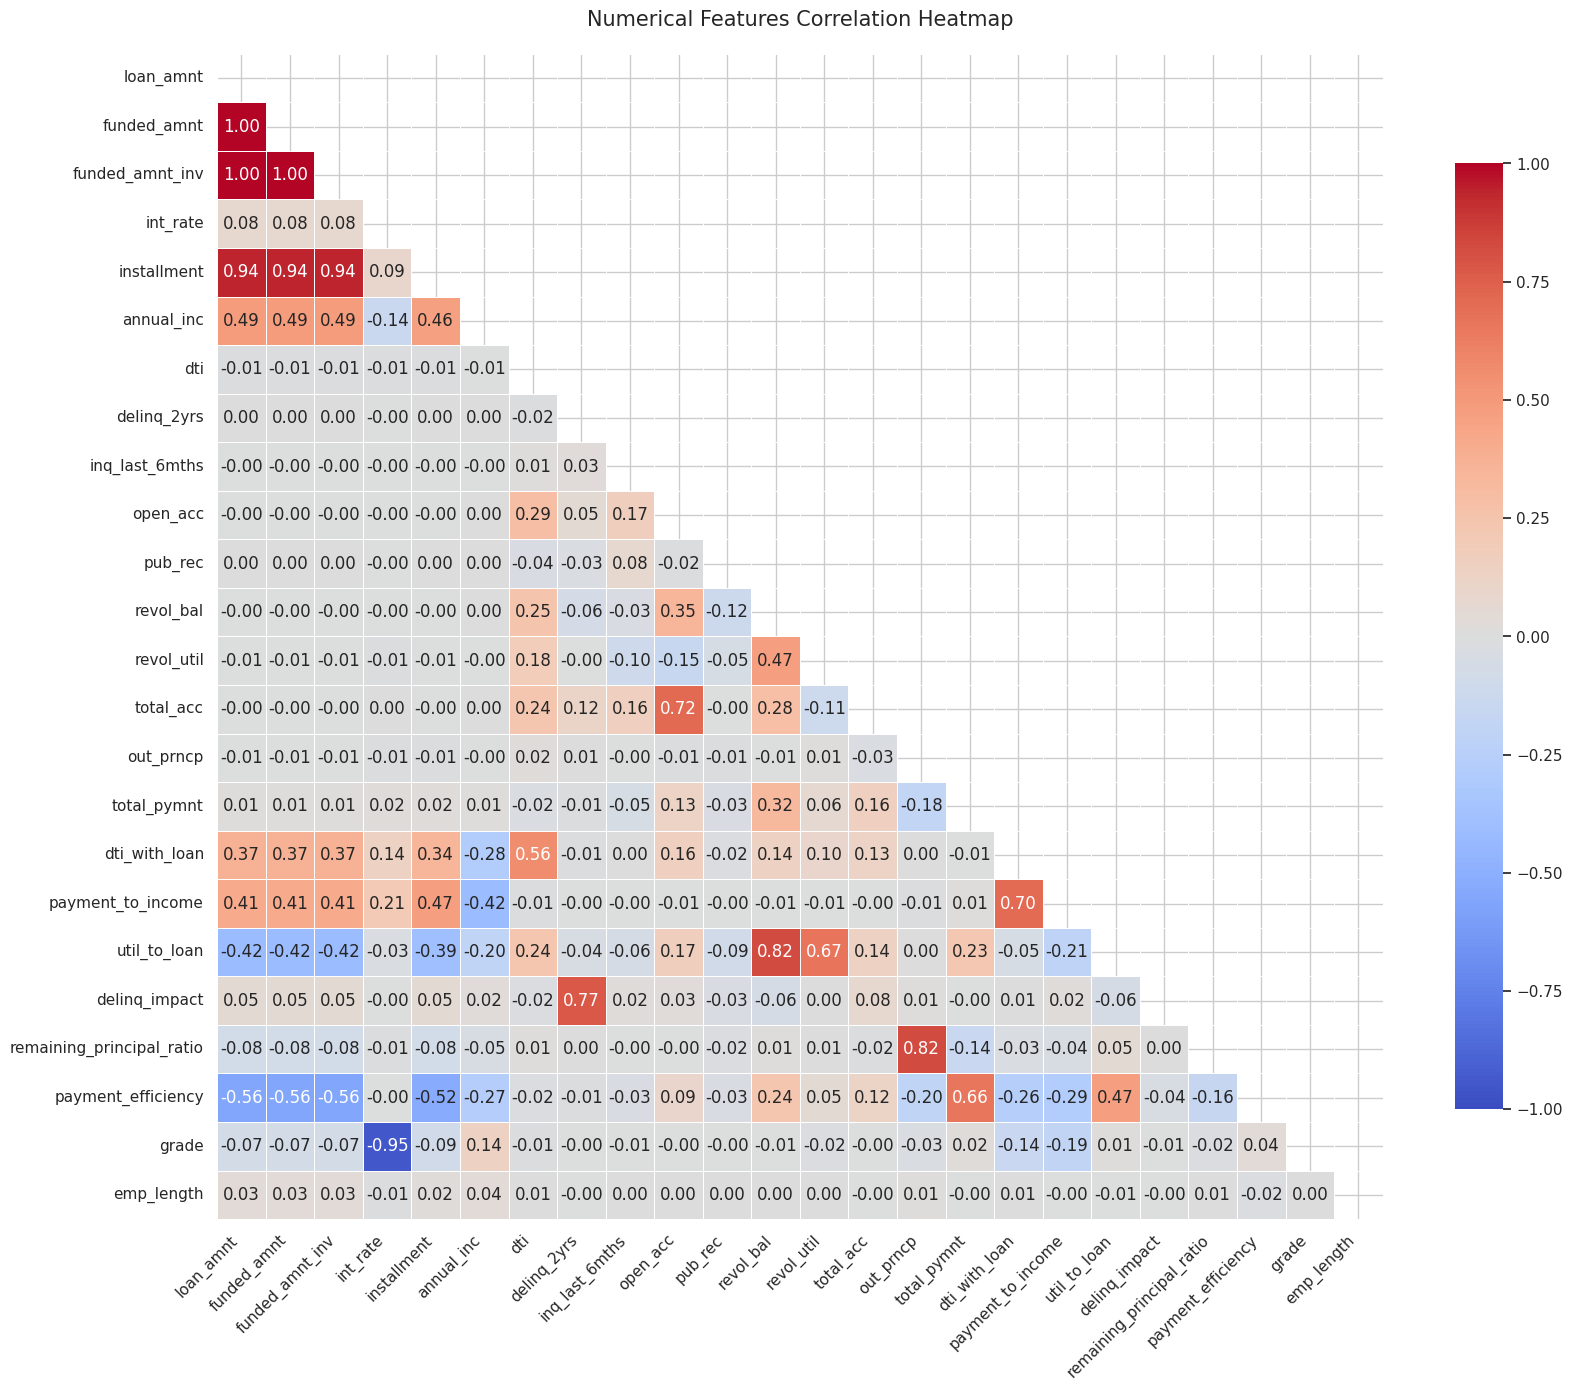

In [ ]:
# Select numerical and ordinal features
numerical_cols = numerical_features + ordinal_features

# Calculate correlation matrix
corr_matrix = X_train[numerical_cols].corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(17, 14))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create heatmap with seaborn
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": .8})

# Adjust title and rotation
plt.title('Numerical Features Correlation Heatmap', pad=20, fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
def remove_highly_correlated_features(X, threshold=0.99):

    # Create copy to avoid modifying original
    X = X.copy()

    # Select only numerical features
    numerical_data = X.select_dtypes(include=['int64', 'float64'])

    # Compute correlation matrix
    corr_matrix = numerical_data.corr().abs()
    features_to_remove = set()

    # Iterate over upper triangle
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]

                # Calculate mean absolute correlation with other features
                avg_corr_feature1 = corr_matrix[feature1].drop([feature1, feature2]).mean()
                avg_corr_feature2 = corr_matrix[feature2].drop([feature1, feature2]).mean()

                # Keep feature with lower average correlation
                if avg_corr_feature1 > avg_corr_feature2:
                    features_to_remove.add(feature1)
                else:
                    features_to_remove.add(feature2)

    # Convert to list and sort for reproducibility
    features_to_remove = sorted(list(features_to_remove))

    # Create reduced dataset
    X_reduced = X.drop(columns=features_to_remove)

    print("="*50)
    print(f"\nRemoved {len(features_to_remove)} highly correlated features:")
    print(", ".join(features_to_remove))
    print(f"\nRemaining features: {X_reduced.shape[1]}")
    print("="*50)

    return X_reduced, features_to_remove

In [ ]:
X_train_reduced, removed_features = remove_highly_correlated_features(X_train, threshold=0.8)

X_val_reduced = X_val.drop(columns=removed_features)
X_test_reduced = test_encoded.drop(columns=removed_features)


Removed 6 highly correlated features:
funded_amnt, funded_amnt_inv, grade, loan_amnt, remaining_principal_ratio, util_to_loan

Remaining features: 33


# 4. Modeling

## 4.1. Logistic Regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Logistic Regression Results
Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Mean CV F1: 0.5880
Validation F1: 0.5867
Validation AUC: 0.8213

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84     51807
           1       0.70      0.51      0.59     24191

    accuracy                           0.77     75998
   macro avg       0.75      0.70      0.72     75998
weighted avg       0.76      0.77      0.76     75998



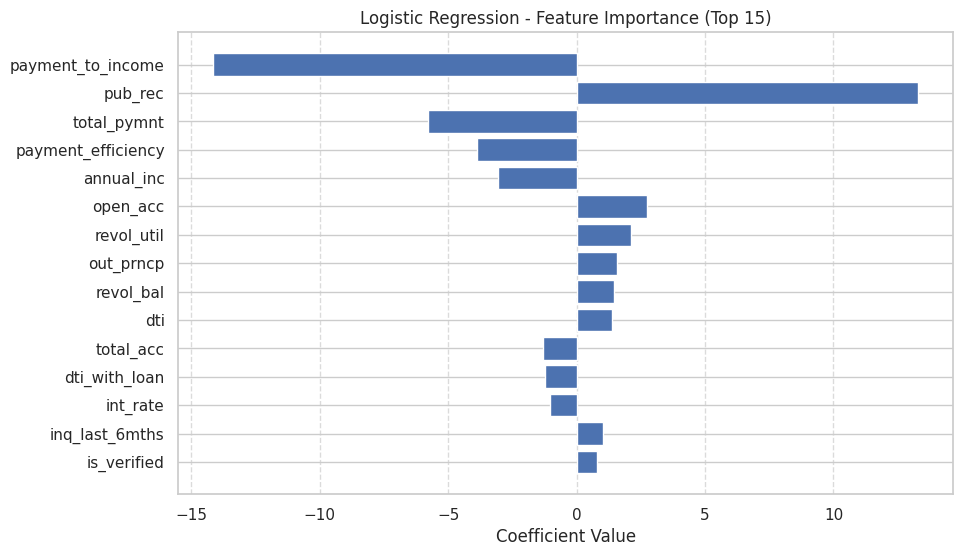

In [ ]:
def fine_tune_logistic_regression(X_train, y_train, X_val, y_val):

    # Defining the Logistic Regression model
    log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

    # Defining the hyperparameters grid
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [1, 10],
        'solver': ['liblinear']}

 # Grid search with cross-validation (F1 optimized)
    grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid,
                               scoring='f1', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    best_lr = grid_search.best_estimator_
    best_lr_params = grid_search.best_params_

    # Cross-validation scores (F1)
    cv_scores = cross_val_score(best_lr, X_train, y_train, scoring='f1', cv=5)
    mean_cv_f1 = cv_scores.mean()

    # Validation set evaluation
    y_val_pred = best_lr.predict(X_val)
    y_val_pred_proba = best_lr.predict_proba(X_val)[:, 1]
    val_f1 = f1_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)

    # Results
    print("=" * 50)
    print("Logistic Regression Results")
    print("=" * 50)
    print(f"Best Hyperparameters: {best_lr_params}")
    print(f"Mean CV F1: {mean_cv_f1:.4f}")
    print(f"Validation F1: {val_f1:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    coefficients = best_lr.coef_[0]
    feature_names = X_train.columns
    indices = np.argsort(np.abs(coefficients))[-15:]
    plt.title('Logistic Regression - Feature Importance (Top 15)')
    plt.barh(range(len(indices)), coefficients[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Coefficient Value')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    return best_lr

best_log_reg_model = fine_tune_logistic_regression(X_train_reduced, y_train, X_val_reduced, y_val)

## 4.2. Deep Learning

In [ ]:
# Splitting the data again in because we will not use kfold to assess the model
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_reduced, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Convert labels to float32
y_train_split = y_train_split.astype(np.float32)
y_val_split = y_val_split.astype(np.float32)

# Defining the input size and model parameters
input_size = X_train_reduced.shape[1]
hidden_layer_size = 64
output_size = 1  # binary classification

# Computing the class weights to handle the imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_split),
    y=y_train_split
)
class_weights = dict(enumerate(class_weights))

# Building the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu', input_shape=(input_size,)),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='sigmoid')  # sigmoid for binary output
])

# Compiling the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Training parameters
batch_size = 128
max_epochs = 100

# Defining early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

# Trainiing the model with class weights
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=max_epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=2)

Epoch 1/100
1423/1423 - 7s - 5ms/step - accuracy: 0.7377 - auc: 0.8136 - loss: 0.5287 - val_accuracy: 0.7541 - val_auc: 0.8284 - val_loss: 0.5029
Epoch 2/100
1423/1423 - 3s - 2ms/step - accuracy: 0.7539 - auc: 0.8337 - loss: 0.5027 - val_accuracy: 0.7572 - val_auc: 0.8374 - val_loss: 0.4974
Epoch 3/100
1423/1423 - 3s - 2ms/step - accuracy: 0.7573 - auc: 0.8388 - loss: 0.4956 - val_accuracy: 0.7520 - val_auc: 0.8398 - val_loss: 0.5051
Epoch 4/100
1423/1423 - 3s - 2ms/step - accuracy: 0.7600 - auc: 0.8413 - loss: 0.4923 - val_accuracy: 0.7725 - val_auc: 0.8418 - val_loss: 0.4745
Epoch 5/100
1423/1423 - 4s - 3ms/step - accuracy: 0.7607 - auc: 0.8428 - loss: 0.4901 - val_accuracy: 0.7315 - val_auc: 0.8420 - val_loss: 0.5341
Epoch 6/100
1423/1423 - 4s - 3ms/step - accuracy: 0.7613 - auc: 0.8437 - loss: 0.4889 - val_accuracy: 0.7622 - val_auc: 0.8431 - val_loss: 0.4877
Epoch 7/100
1423/1423 - 4s - 3ms/step - accuracy: 0.7624 - auc: 0.8451 - loss: 0.4869 - val_accuracy: 0.7406 - val_auc: 0.84

In [ ]:
# Predicting probabilities
y_pred_probs = model.predict(X_val_reduced)

# Converting probabilities to binary predictions (default threshold = 0.5)
y_pred = (y_pred_probs > 0.5).astype(int)

# F1 Score calculating
f1 = f1_score(y_val, y_pred)
print(f"F1 Score on validation set: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

2375/2375 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
F1 Score on validation set: 0.6770

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83     51807
           1       0.63      0.73      0.68     24191

    accuracy                           0.78     75998
   macro avg       0.75      0.77      0.75     75998
weighted avg       0.79      0.78      0.78     75998


Confusion Matrix:
[[41282 10525]
 [ 6426 17765]]


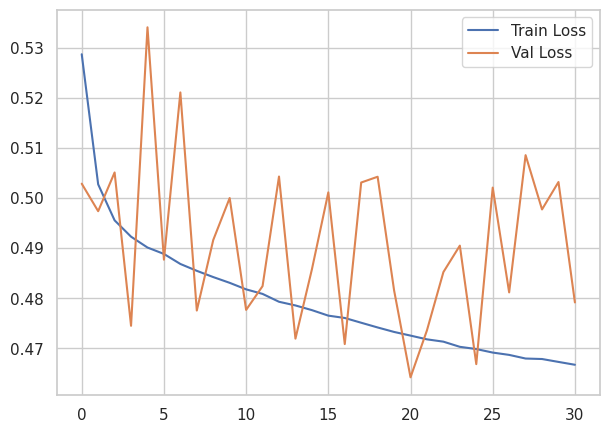

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

## 4.3. ML Algorithms

##### **Random Forest**

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest Results
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
Mean CV F1: 0.6894
Validation F1: 0.6855
Validation AUC: 0.8549

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83     51807
           1       0.63      0.76      0.69     24191

    accuracy                           0.78     75998
   macro avg       0.75      0.77      0.76     75998
weighted avg       0.80      0.78      0.78     75998



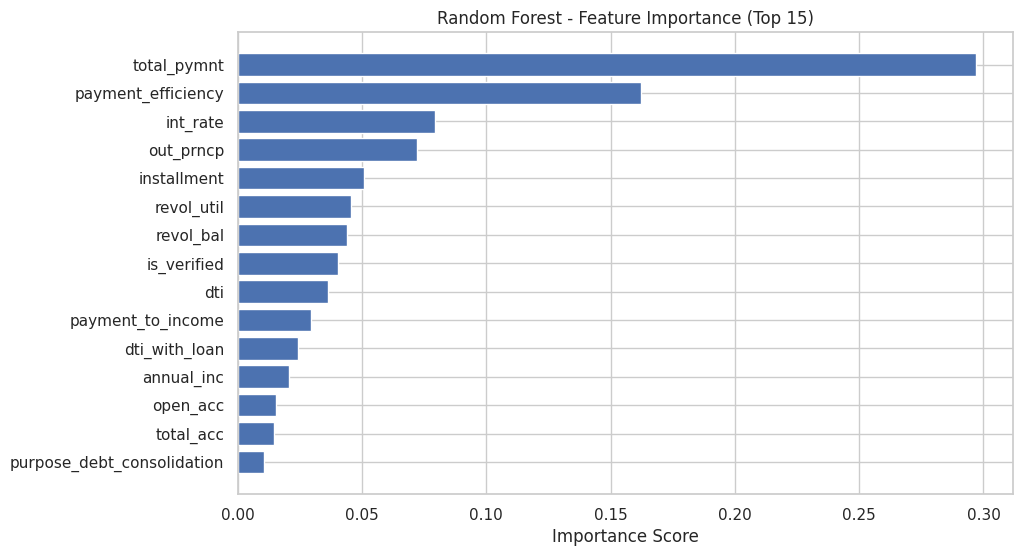

In [ ]:
def fine_tune_random_forest(X_train, y_train, X_val, y_val):
    # Initialize model with class weighting
    rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

    # Parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_leaf': [1, 5, 10],
        'max_features': ['sqrt', 'log2']
    }

    # Grid search
    grid_search = GridSearchCV(rf, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Best model
    best_rf = grid_search.best_estimator_
    best_rf_params = grid_search.best_params_

    # Cross-validation scores (F1-Score)
    cv_scores = cross_val_score(best_rf, X_train, y_train, scoring='f1', cv=5)
    mean_cv_f1 = cv_scores.mean()

    # Validation set evaluation
    y_val_pred = best_rf.predict(X_val)
    y_val_pred_proba = best_rf.predict_proba(X_val)[:, 1]
    val_f1 = f1_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)

    # Results
    print("=" * 50)
    print("Random Forest Results")
    print("=" * 50)
    print(f"Best Hyperparameters: {best_rf_params}")
    print(f"Mean CV F1: {mean_cv_f1:.4f}")
    print(f"Validation F1: {val_f1:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[-15:]
    plt.title('Random Forest - Feature Importance (Top 15)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Importance Score')
    plt.show()

    return best_rf

best_rf_model = fine_tune_random_forest(X_train_reduced, y_train, X_val_reduced, y_val)

##### **CatBoost**

* CatBoost is a black-box model, meaning its predictions lack interpretability. Management may find it difficult to justify decisions like loan rejection or approval.

* While CatBoost is optimized for speed compared to other boosting algorithms, it still requires substantial computational resources, especially for large datasets or hyperparameter tuning.

* Like Gradient Boosting, CatBoost can overfit noisy or imbalanced datasets if not properly tuned, which may lead to unreliable predictions in production.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CatBoost Results:
Best Hyperparameters: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.2}
Mean CV F1: 0.9130
Validation F1: 0.9107
Validation AUC: 0.9888

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     51807
           1       0.86      0.96      0.91     24191

    accuracy                           0.94     75998
   macro avg       0.92      0.95      0.93     75998
weighted avg       0.94      0.94      0.94     75998



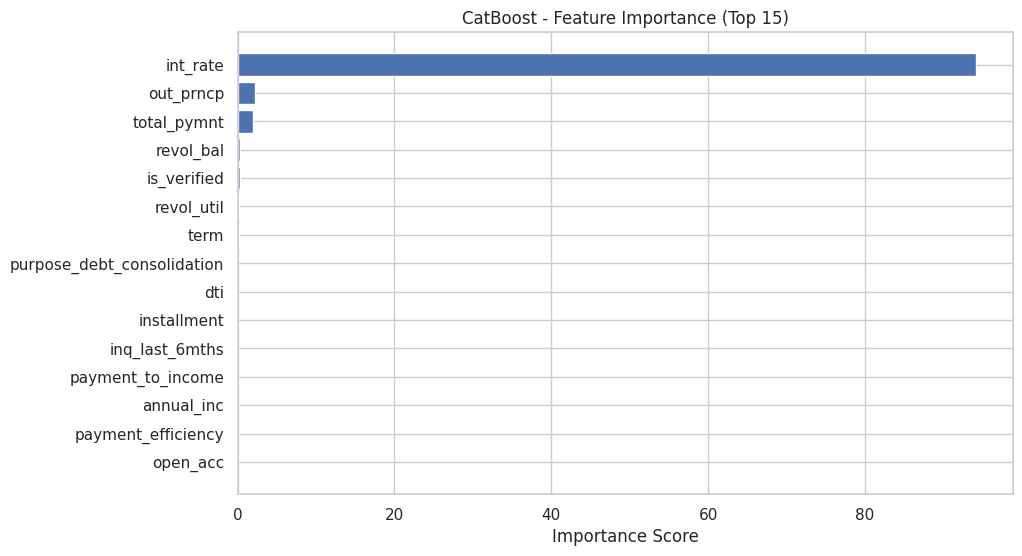

In [ ]:
def fine_tune_catboost(X_train, y_train, X_val, y_val):

    # Defining the CatBoost model
    catboost = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced')

    # Defining the hyperparameters grid
    param_grid = {
        'iterations': [100, 200],
        'learning_rate': [0.1, 0.2],
        'depth': [4, 6],
        'l2_leaf_reg': [3, 5],
    }

    # Defining the GridSearchCV with cross-validation
    grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid,
                               scoring='f1', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)


    # Best model
    best_cb = grid_search.best_estimator_
    best_cb_params = grid_search.best_params_

    # Cross-validation scores (F1)
    cv_scores = cross_val_score(best_cb, X_train, y_train, scoring='f1', cv=5)
    mean_cv_f1 = cv_scores.mean()

    # Validation set evaluation
    y_val_pred = best_cb.predict(X_val)
    y_val_pred_proba = best_cb.predict_proba(X_val)[:, 1]
    val_f1 = f1_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)

    # Results
    print("=" * 50)
    print("CatBoost Results:")
    print("=" * 50)
    print(f"Best Hyperparameters: {best_cb_params}")
    print(f"Mean CV F1: {mean_cv_f1:.4f}")
    print(f"Validation F1: {val_f1:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))

    # Feature importance plot (CatBoost)
    plt.figure(figsize=(10, 6))
    importances = best_cb.get_feature_importance()
    indices = np.argsort(importances)[-15:]
    plt.title('CatBoost - Feature Importance (Top 15)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Importance Score')
    plt.show()

    return best_cb

best_catboost_model = fine_tune_catboost(X_train_reduced, y_train, X_val_reduced, y_val)

##### **Gradient Boosting**

* Gradient Boosting can overfit the training data, especially if hyperparameters such as the number of trees, tree depth, and learning rate are not carefully tuned.

* Although Gradient Boosting provides feature importance scores, its overall predictions are harder to interpret than simpler models like Logistic Regression. This lack of interpretability can make it challenging for management to understand and trust the model's decisions.

* Training these models requires significant computational resources, which could delay deployment or real-time decision-making processes.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Gradient Boosting Results:
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Mean CV F1: 0.9119
Validation F1: 0.9090
Validation AUC: 0.9867

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     51807
           1       0.90      0.92      0.91     24191

    accuracy                           0.94     75998
   macro avg       0.93      0.93      0.93     75998
weighted avg       0.94      0.94      0.94     75998



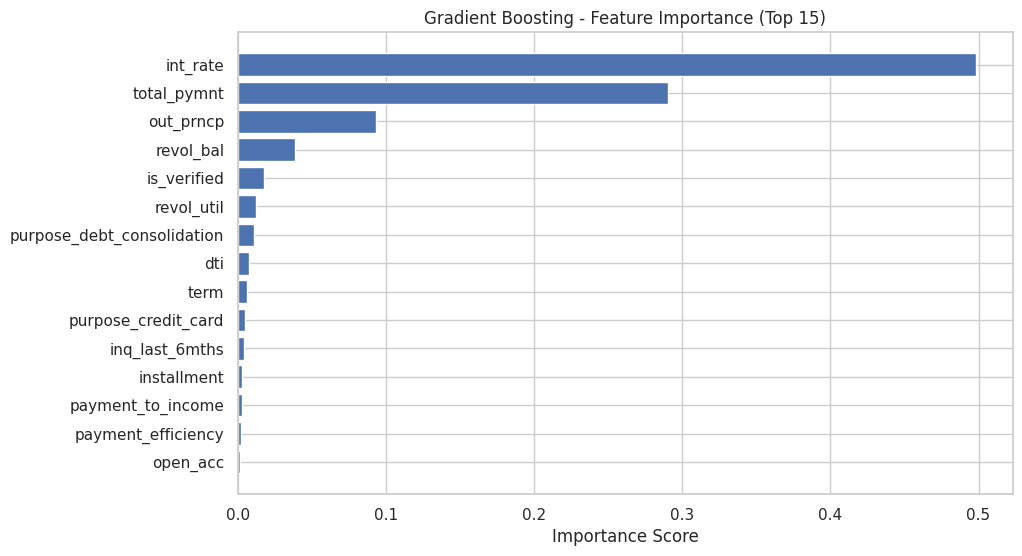

In [ ]:
def fine_tune_gradient_boosting(X_train, y_train, X_val, y_val):

    # Defining the Gradient Boosting model
    gbm = GradientBoostingClassifier(random_state=42)

    # Defining the hyperparameters grid
    param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
    }

    # Defining the GridSearchCV with cross-validation
    grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid,
                               scoring='f1', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    best_gbm = grid_search.best_estimator_
    best_gbm_params = grid_search.best_params_

    # Cross-validation scores (F1)
    cv_scores = cross_val_score(
        best_gbm,
        X_train,
        y_train,
        scoring='f1',
        cv=5
    )
    mean_cv_f1 = cv_scores.mean()

    # Validation set evaluation
    y_val_pred = best_gbm.predict(X_val)
    y_val_pred_proba = best_gbm.predict_proba(X_val)[:, 1]
    val_f1 = f1_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)

    # Results
    print("=" * 50)
    print("Gradient Boosting Results:")
    print("=" * 50)
    print(f"Best Hyperparameters: {best_gbm_params}")
    print(f"Mean CV F1: {mean_cv_f1:.4f}")
    print(f"Validation F1: {val_f1:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    importances = best_gbm.feature_importances_
    indices = np.argsort(importances)[-15:]
    plt.title('Gradient Boosting - Feature Importance (Top 15)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Importance Score')
    plt.show()

    return best_gbm

best_gbm_model = fine_tune_gradient_boosting(X_train_reduced, y_train, X_val_reduced, y_val)

## 4.4. Logistic Regression and ML Algorithms Confusion Matrices

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(C=10, penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
lr_model.fit(X_train_reduced, y_train)
lr_pred = lr_model.predict(X_val_reduced)
lr_cm = confusion_matrix(y_val, lr_pred)
print("Logistic Regression Confusion Matrix:")
print(lr_cm)

# Random Forest
rf_model = RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=5, n_estimators=100, random_state=42)
rf_model.fit(X_train_reduced, y_train)
rf_pred = rf_model.predict(X_val_reduced)
rf_cm = confusion_matrix(y_val, rf_pred)
print("\nRandom Forest Confusion Matrix:")
print(rf_cm)

# CatBoost
cb_model = CatBoostClassifier(depth=6, iterations=200, l2_leaf_reg=3, learning_rate=0.2, random_state=42, verbose=0)
cb_model.fit(X_train_reduced, y_train)
cb_pred = cb_model.predict(X_val_reduced)
cb_cm = confusion_matrix(y_val, cb_pred)
print("\nCatBoost Confusion Matrix:")
print(cb_cm)

# Gradient Boosting
gb_model = GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8, random_state=42)
gb_model.fit(X_train_reduced, y_train)
gb_pred = gb_model.predict(X_val_reduced)
gb_cm = confusion_matrix(y_val, gb_pred)
print("\nGradient Boosting Confusion Matrix:")
print(gb_cm)

# 5. Predicting the Test Set

In [ ]:
X_train_reduced.to_csv('processed_train_set.csv', index=False)
X_val_reduced.to_csv('processed_val_set.csv', index=False)
X_test_reduced.to_csv('processed_test_set.csv', index=False)

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Nova Ims/Credit Risk Scoring/Project/processed_test_set.csv")

test.set_index("id", inplace = True)

test.head()

,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,dti_with_loan,payment_to_income,delinq_impact,payment_efficiency,owns_house,house_expenses,is_verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,addr_division_East North Central,addr_division_East South Central,addr_division_Middle Atlantic,addr_division_Mountain,addr_division_New England,addr_division_Pacific,addr_division_South Atlantic,addr_division_West North Central
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
924308,1,0.291001,0.551413,0.000000,0.772772,0.097037,0.047619,0.0,0.037975,0.000000,-0.218388,-0.008840,0.028736,0.0,0.913942,0.007239,0.022116,0.864905,0.163410,1,1,1,0,0,1,0,0,0,0,0,0,1,0
924309,0,0.400078,0.751398,1.000000,0.595920,0.037003,0.047619,0.4,0.050633,0.000000,0.440107,0.504420,0.063218,0.0,0.821692,0.004316,0.069836,0.789684,0.119435,1,0,1,0,1,0,0,0,0,0,0,1,0,0
924310,0,0.291001,0.150259,0.727273,0.370211,0.515124,0.142857,0.0,0.088608,0.011628,0.364103,0.182320,0.183908,0.0,0.748409,0.053119,0.044707,0.655947,0.254631,1,1,1,0,1,0,0,0,0,0,0,0,1,0
924311,0,0.291001,0.025458,0.272727,0.318880,0.188853,0.095238,0.0,0.265823,0.000000,0.712357,0.213260,0.396552,0.0,0.897058,0.006995,0.014709,0.409605,0.716840,0,1,1,1,0,0,1,0,0,0,0,0,0,0
924312,0,0.240358,0.084842,0.454545,0.528967,0.493321,0.000000,0.0,0.151899,0.000000,0.576538,0.223204,0.264368,0.0,0.793287,0.015613,0.012622,0.000000,0.387577,1,1,1,0,1,0,0,0,1,0,0,0,0,0


In [ ]:
# Predicting binary class using the trained CatBoost model

y_test_pred = best_catboost_model.predict(test)

# Predicting probabilities for class 1

y_test_probs = best_catboost_model.predict_proba(test)[:, 1]

test['predicted_default'] = y_test_pred

test['predicted_default_probability'] = y_test_probs

test.to_csv("/content/drive/MyDrive/Nova Ims/Credit Risk Scoring/Project/predicted_test_set.csv")